# <span style='font-family:"Times New Roman"'> <span styel=''> **GROUP EXPLORATION**

*Emile Cohen* 
    
*March 2020*

**Goal:** In this notebook, we create subgroups of the cohort, based on their Copy Number State and their mutational profile. For that we create functions to visualize vaf, ccf, purity, 'Expected Number of copies of TP53 mutations' densities but also scatterplots of VAF1/VAF2, CCF1/CCF2 and VAF/CF.
    
The Notebook is divided in 2 parts:
   
* **1. Function Definition**
* **2. Loading Master**
* **3. Group Creation**
* **4. Data Exploration**
* **5. Final Subgroups Analysis**

**NB1:** In each part, you must run the cells from the begining in order to initialize the variables

**NB2:** All functions used for the plots are located in utils/custom_tools.py

---

In [2]:
%run -i '../../utils/setup_environment.ipy'
from utils.analysis_tools import *

import warnings, math
warnings.filterwarnings('ignore')
import ptitprince as pt
import IPython.display

data_path = '../../data/'
data_wgd = data_path + 'impact-facets-tp53/processed/wgd/'
data_no_wgd = data_path + 'impact-facets-tp53/processed/no_wgd/'

Setup environment... done!


<span style="color:green">✅ Working on **mskimpact_env** conda environment.</span>

In [6]:
# Load the masters
master_cleaned = non_wgd_load_and_cut(data_path + 'impact-facets-tp53/processed/no_wgd/master_no_wgd.pkl')
display(get_groupby(master_cleaned, 'tp53_group', 'count').sort_values(by=['count'], ascending=False))


count
tp53_group        
>=1_LOSS      3465
0_HETLOSS     2431
>=1_cnLOH      679
1_WILD_TYPE    496
>1muts         428
HOMDEL         139

---
## Function Definition

In this part we define the needed functions to plot summaries of each subgroup.

---

The following *f1, f2* and *f3* allow to recompute the ccf (cancer cell fraction), based on Teng repository Github (https://github.com/papaemmelab/driverclone/blob/master/utils.r#L124-L175)

In [7]:
def f1(x):
    if math.isnan(x.tp53_exp_nb_1):
        return float('NaN')
    else: 
        if x.tp53_exp_nb_1 >= 1 :
            m_star = round(x.tp53_exp_nb_1)
        else : m_star = 1
        return (x.tp53_exp_nb_1/m_star)
    
def f2(x):
    if math.isnan(x.tp53_exp_nb_2):
        return float('NaN')
    else: 
        if x.tp53_exp_nb_2 >= 1 :
            m_star = round(x.tp53_exp_nb_2)
        else : m_star = 1
        return (x.tp53_exp_nb_2/m_star)
    
def f3(x):
    if math.isnan(x.tp53_exp_nb_3):
        return float('NaN')
    else: 
        if x.tp53_exp_nb_3 >= 1 :
            m_star = round(x.tp53_exp_nb_3)
        else : m_star = 1
        return (x.tp53_exp_nb_3/m_star)

---
We define 4 functions that will allow us to print easily the summary report of our subgroups.

1. plot_ccf_vaf
2. plot_scatters
3. plot_purity_numbers
4. plot_copies_tcn

In [8]:
def plot_ccf_vaf(data, group_name):
    
    data_vaf = list(data['tp53_vaf_1']) + list(data['tp53_vaf_2']) + list(data['tp53_vaf_3'])
    data_ccf = list(data['tp53_ccf_1']) + list(data['tp53_ccf_2']) + list(data['tp53_ccf_3'])
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3), sharex=True)
    
    sns.distplot(data_vaf, kde_kws={'clip': (0.0, 1.0), "shade": True}, hist=False, ax=ax1)
    ax1.set_ylabel('Density Estimation')
    ax1.set_xlabel('VAF of TP53 mutations')
    ax1.set_title('VAF Distribution' , weight = 'bold')

    sns.distplot(data_ccf,kde_kws={"shade": True}, hist=False, ax=ax2)
    ax2.set_xlabel('CCF of TP53 mutations')
    ax2.set_title('CCF Distribution', weight = 'bold')
    
    plt.show()

    
    
def plot_scatters(data, txt, group):
    
    data_vaf = data[['tp53_vaf_1', 'tp53_vaf_2', 'tp53_vaf_3']]
    max_table_vaf = pd.DataFrame(np.sort(data_vaf.fillna(0).values)[:,-2:], columns=['2nd-largest','largest'])
    max_table_vaf = pd.concat([max_table_vaf, data.reset_index().tp53_cn_state], axis=1)
    
    data_ccf = data[['tp53_ccf_1', 'tp53_ccf_2', 'tp53_ccf_3']]
    max_table_ccf = pd.DataFrame(np.sort(data_ccf.fillna(0).values)[:,-2:], columns=['2nd-largest','largest'])
    max_table_ccf = pd.concat([max_table_ccf, data.reset_index().tp53_cn_state], axis=1)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharex=True)
    
    sns.scatterplot(x='largest', y='2nd-largest', data=max_table_vaf, hue='tp53_cn_state',hue_order=group, ax=ax1, palette="muted")
    ax1.plot([0,1], [0,1], linewidth=0.5, color='grey')
    ax1.set_ylabel('VAF_2')
    ax1.set_xlabel('VAF_1')
    ax1.set_title('VAF' + txt, weight = 'bold')
    
    sns.scatterplot(x='largest', y='2nd-largest', data=max_table_ccf, hue='tp53_cn_state',hue_order=group, ax=ax2, palette="muted")
    ax2.plot([0,1], [0,1], linewidth=0.5, color='grey')
    ax2.set_ylabel('CCF_2')
    ax2.set_xlabel('CCF_1')
    ax2.set_title('CCF' + txt, weight = 'bold')
    
    plt.show()

def plot_purity_cancer(data, group, group_name, mut_cn_group=False): 
        f, axs = plt.subplots(1, 2, figsize=(14, 4))
        f.suptitle(group_name+' SUMMARY', fontsize=16, weight = 'bold')
        ax1 = axs[0]
        sns.distplot(data['purity'], hist=False,kde_kws={'clip': (0.0, 1.0), "shade": True}, ax=ax1)
        ax1.set_xlim([0,1])
        ax1.set_xlabel('Purity')
        ax1.set_ylabel('Density Estimation')
        ax1.set_title('Purity', weight = 'bold')

        ax2 = axs[1]
        data_cancer = pd.DataFrame(get_groupby(data, 'Cancer_Type', 'count')).sort_values(by=['count'], ascending=False).head(10)
        sns.barplot(y='count', x=data_cancer.index, data=data_cancer, ax=ax2, color=plt.cm.Blues(0.4))
        ax2.set_xlabel('Cancer Types')
        ax2.set_ylabel('# of Samples')
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=40, ha="right")
        ax2.set_title('Cancer Type Distribution', weight = 'bold')

def plot_copies_tcn(data, group, group_name, nb_muts):
    data = filter_muts(data, nb_muts)
    data_1 =  pd.DataFrame(data[['Tumor_Id','tp53_exp_nb_1']])
    data_1.columns = ['Tumor_Id', 'tp53_exp_nb']
    data_2 = pd.DataFrame(data[['Tumor_Id','tp53_exp_nb_2']])
    data_2.columns = ['Tumor_Id', 'tp53_exp_nb']
    data_3 = pd.DataFrame(data[['Tumor_Id','tp53_exp_nb_3']])
    data_3.columns = ['Tumor_Id', 'tp53_exp_nb']
    data_4 = pd.DataFrame(data[['Tumor_Id','tp53_exp_nb_4']])
    data_4.columns = ['Tumor_Id', 'tp53_exp_nb']
    data_5 = pd.DataFrame(data[['Tumor_Id','tp53_exp_nb_5']])
    data_5.columns = ['Tumor_Id', 'tp53_exp_nb']
    data_tot = data_1.append(data_2)
    data_tot = data_tot.append(data_3)
    data_tot = data_tot.append(data_4)
    data_tot = data_tot.append(data_5)
    
    data_tot = pd.merge(left=data_tot, right=data[['Tumor_Id','tp53_cn_state', 'tp53_tcn']],how='left', left_on='Tumor_Id',right_on='Tumor_Id')

    dx="tp53_tcn"; dy="tp53_exp_nb"; ort="h"; pal = "muted"; sigma = .2; dhue = "tp53_cn_state"; dhue_order=group
    f, ax = plt.subplots(figsize=(15, 10))
    
    # Little trick for indeterminate group
    if group_name == 'INDETERMINATE':
        ax=pt.RainCloud(x = dx, y = dy, data = data_tot, palette = pal, bw = sigma,
                 width_viol = .6, ax = ax, orient = ort, alpha=.6, mv=.2)
    else:
        ax=pt.RainCloud(x = dx, y = dy, data = data_tot, palette = pal, bw = sigma, hue=dhue, hue_order=dhue_order,
                 width_viol = .6, ax = ax, orient = ort, alpha=.6, mv=.2)
    ax.set_ylabel('Total Copy Number')
    ax.set_xlabel('Expected number of copies of Tp53 mutations')
    ax.set_title(group_name, weight = 'bold')

Finally, we define *plot_summary* that uses the functions above to compute a visual summary of the group

In [9]:
def plot_summary(group: list, group_name: str, nb_muts_density=[1,2,3], nb_muts_scatter=[2,3], mut_cn_group=False, sample_type=False):
    
    sns.set_style("whitegrid", {'grid.color': '1'})
    sns.despine(top=True, right=True, left=False, bottom=False)
    
    master_cutoff = master[master['purity'] > 0.25]
    master_cutoff.drop( master_cutoff[master_cutoff['tp53_group'] == '1_WILD_TYPE'][master_cutoff['purity'] <= 0.32].index , inplace=True)
    
    # DENSITY PLOTS
    master_density = filter_muts(master_cutoff, nb_muts_density)
    
    # Plot Purity distribution and cancer distribution
    plot_purity_cancer(master_density, group, group_name, mut_cn_group)
    
    # Plot vaf and ccf densities
    if mut_cn_group:
        master_density = filter_general(master_density, 'tp53_group', group)
        #display(master_density)
    else: master_density = filter_cn_state(master_density, group)

    sns.set_palette("muted", len(set(master_density.tp53_cn_state)),1)
    
    display_side_by_side(get_groupby(master_density, 'tp53_cn_state', 'count'),get_groupby(master_density, 'Cancer_Type', 'count').sort_values(by=['count'], ascending=False).head(15),get_groupby(master_density, 'tp53_count', 'count'))
    plot_ccf_vaf(master_density, group_name)
    
    # SCATTER PLOTS
    if nb_muts_scatter != 0:
        master_scatter = filter_muts(master_cutoff, nb_muts_scatter)
        if mut_cn_group:
            master_scatter = filter_general(master_scatter, 'tp53_group', group)
            group = list(set(master_scatter.tp53_cn_state))
        else: 
            master_scatter = filter_cn_state(master_scatter, group)
        
        plot_scatters(master_scatter, '', group)
        
        # Metastasis VS Primary
        if sample_type:
            master_scatter_prim = master_scatter[master_scatter['Sample_Type'] == 'Primary']
            master_scatter_met = master_scatter[master_scatter['Sample_Type'] == 'Metastasis']
            plot_scatters(master_scatter_prim, ' - Primary Samples', group)
            plot_scatters(master_scatter_met, ' - Metastatic Samples', group)
    
    
    # Plot number of mut copies VS tcn 
    cn_state_group = list(set(master_density.tp53_cn_state))
    plot_copies_tcn(master_density, cn_state_group, group_name, [1,2,3,4,5])

---
## Loading Master

We load the master file and create 3 new columns: for each mutation we compute a Cancer Cell Fraction (CCF), from the Lab Github. This CCF is uncapped and go above 1, contrary to the one given in the Facets output.

In [10]:
# LOADING THE MASTER FILE
master = non_wgd_load_and_cut(data_path + 'impact-facets-tp53/processed/no_wgd/master_no_wgd.pkl')

master['tp53_ccf_comp_1'] = master.apply(f1, axis = 1)
master['tp53_ccf_comp_2'] = master.apply(f2, axis = 1)
master['tp53_ccf_comp_3'] = master.apply(f3, axis = 1)

master.head()

Sample_Id           Tumor_Id Patient_Id  \
0  P-0034223-T01-IM6_P-0034223-N01-IM6  P-0034223-T01-IM6  P-0034223   
1  P-0009819-T01-IM5_P-0009819-N01-IM5  P-0009819-T01-IM5  P-0009819   
2  P-0027408-T01-IM6_P-0027408-N01-IM6  P-0027408-T01-IM6  P-0027408   
3  P-0006554-T01-IM5_P-0006554-N01-IM5  P-0006554-T01-IM5  P-0006554   
4  P-0036980-T01-IM6_P-0036980-N01-IM6  P-0036980-T01-IM6  P-0036980   

                  Cancer_Type             Cancer_Type_Detailed  \
0               Breast Cancer        Invasive Breast Carcinoma   
1             Prostate Cancer          Prostate Adenocarcinoma   
2  Non-Small Cell Lung Cancer       Non-Small Cell Lung Cancer   
3                      Glioma     Anaplastic Oligodendroglioma   
4        Hepatobiliary Cancer  Intrahepatic Cholangiocarcinoma   

   Patient_Current_Age     Sex Sample_Type    purity    ploidy  \
0                 63.0  Female  Metastasis  0.946448  2.241830   
1                 72.0    Male     Primary  0.278140  2.681075   
2                 67.0  Female  Metastasis  0.275073  1.811066   
3                 55.0  Female     Primary  0.775152  1.910719   
4                 54.0  Female     Primary  0.845207  2.267573   

   Overall_Survival_Months Overall_Survival_Status  MSI_Score MSI_Type  \
0                      NaN                  LIVING       0.55   Stable   
1                   23.441                  LIVING       0.00   Stable   
2                   22.586                  LIVING       0.27   Stable   
3                   26.170                  LIVING       1.30   Stable   
4                    9.501                  LIVING       0.45   Stable   

   TMB_Score                          tp53_key_1          tp53_vc_1  \
0        5.3                                None               None   
1        1.0                                None               None   
2       17.6  P-0027408-T01-IM6-17_7578409_CT_TC  Missense_Mutation   
3       46.2                                None               None   
4        4.4                                None               None   

   tp53_ccf_1  tp53_vaf_1 tp53_HGVSp_1 tp53_spot_1 tp53_vt_1 tp53_key_2  \
0         NaN         NaN         None        None      None       None   
1         NaN         NaN         None        None      None       None   
2         1.0    0.168901  p.Arg174Glu         174       DNP       None   
3         NaN         NaN         None        None      None       None   
4         NaN         NaN         None        None      None       None   

  tp53_vc_2  tp53_ccf_2  tp53_vaf_2 tp53_HGVSp_2 tp53_spot_2 tp53_vt_2  \
0      None         NaN         NaN         None        None      None   
1      None         NaN         NaN         None        None      None   
2      None         NaN         NaN         None        None      None   
3      None         NaN         NaN         None        None      None   
4      None         NaN         NaN         None        None      None   

  tp53_key_3 tp53_vc_3  tp53_ccf_3  tp53_vaf_3 tp53_HGVSp_3 tp53_spot_3  \
0       None      None         NaN         NaN         None        None   
1       None      None         NaN         NaN         None        None   
2       None      None         NaN         NaN         None        None   
3       None      None         NaN         NaN         None        None   
4       None      None         NaN         NaN         None        None   

  tp53_vt_3 tp53_key_4 tp53_vc_4  tp53_ccf_4  tp53_vaf_4 tp53_HGVSp_4  \
0      None       None      None         NaN         NaN         None   
1      None       None      None         NaN         NaN         None   
2      None       None      None         NaN         NaN         None   
3      None       None      None         NaN         NaN         None   
4      None       None      None         NaN         NaN         None   

  tp53_spot_4 tp53_vt_4 tp53_key_5 tp53_vc_5  tp53_ccf_5  tp53_vaf_5  \
0        None      None       None      None         NaN         NaN   


---
## Group Creation

We defined these two sets of cn_state groups earlier in the work, when we wanted to discover the data. The last one is in **Data Exploration** part, with the summary plots associated.

In [11]:
# Groups definition
WT_present = ['DIPLOID', 'TETRAPLOID', 'LOSS AFTER', 'DOUBLE LOSS AFTER']
loh = ['CNLOH', 'CNLOH BEFORE & LOSS', 'CNLOH AFTER', 'CNLOH BEFORE', 'CNLOH & GAIN', 'CNLOH BEFORE & GAIN', 'AMP (LOH)']
loss_withorwithout_WT = ['HETLOSS', 'LOSS BEFORE', 'HOMDEL', 'LOSS BEFORE & AFTER']
gain = ['GAIN', 'AMP', 'AMP (BALANCED)', 'LOSS & GAIN']

In [12]:
# Groups definition
CNLOH = ['CNLOH', 'CNLOH BEFORE & LOSS', 'CNLOH AFTER', 'CNLOH BEFORE', 'CNLOH & GAIN', 'CNLOH BEFORE & GAIN', 'AMP (LOH)']
LOSS = ['HETLOSS', 'LOSS BEFORE', 'LOSS AFTER', 'HOMDEL', 'LOSS BEFORE & AFTER', 'DOUBLE LOSS AFTER']
GAIN = ['GAIN', 'AMP', 'AMP (BALANCED)', 'LOSS & GAIN']
DI_TETRA = ['DIPLOID', 'TETRAPLOID']
indeterminate = ['INDETERMINATE', '']
total = CNLOH + LOSS + GAIN + DI_TETRA

count 
 
 
 tp53_cn_state 
 
 
 
 
 
 AMP 
 1 
 
 
 AMP (BALANCED) 
 1 
 
 
 GAIN 
 37 
 
 
 
 
 
 
 count 
 
 
 Cancer_Type 
 
 
 
 
 
 Glioma 
 9 
 
 
 Endometrial Cancer 
 4 
 
 
 Bladder Cancer 
 4 
 
 
 Non-Small Cell Lung Cancer 
 4 
 
 
 Cancer of Unknown Primary 
 3 
 
 
 Uterine Sarcoma 
 2 
 
 
 Breast Cancer 
 2 
 
 
 Colorectal Cancer 
 2 
 
 
 Appendiceal Cancer 
 1 
 
 
 Pancreatic Cancer 
 1 
 
 
 Renal Cell Carcinoma 
 1 
 
 
 Prostate Cancer 
 1 
 
 
 Gastrointestinal Stromal Tumor 
 1 
 
 
 Ovarian Cancer 
 1 
 
 
 Gastrointestinal Neuroendocrine Tumor 
 1 
 
 
 
 
 
 
 count 
 
 
 tp53_count 
 
 
 
 
 
 1 
 26 
 
 
 2 
 11 
 
 
 3 
 2

<Figure size 600x600 with 0 Axes>

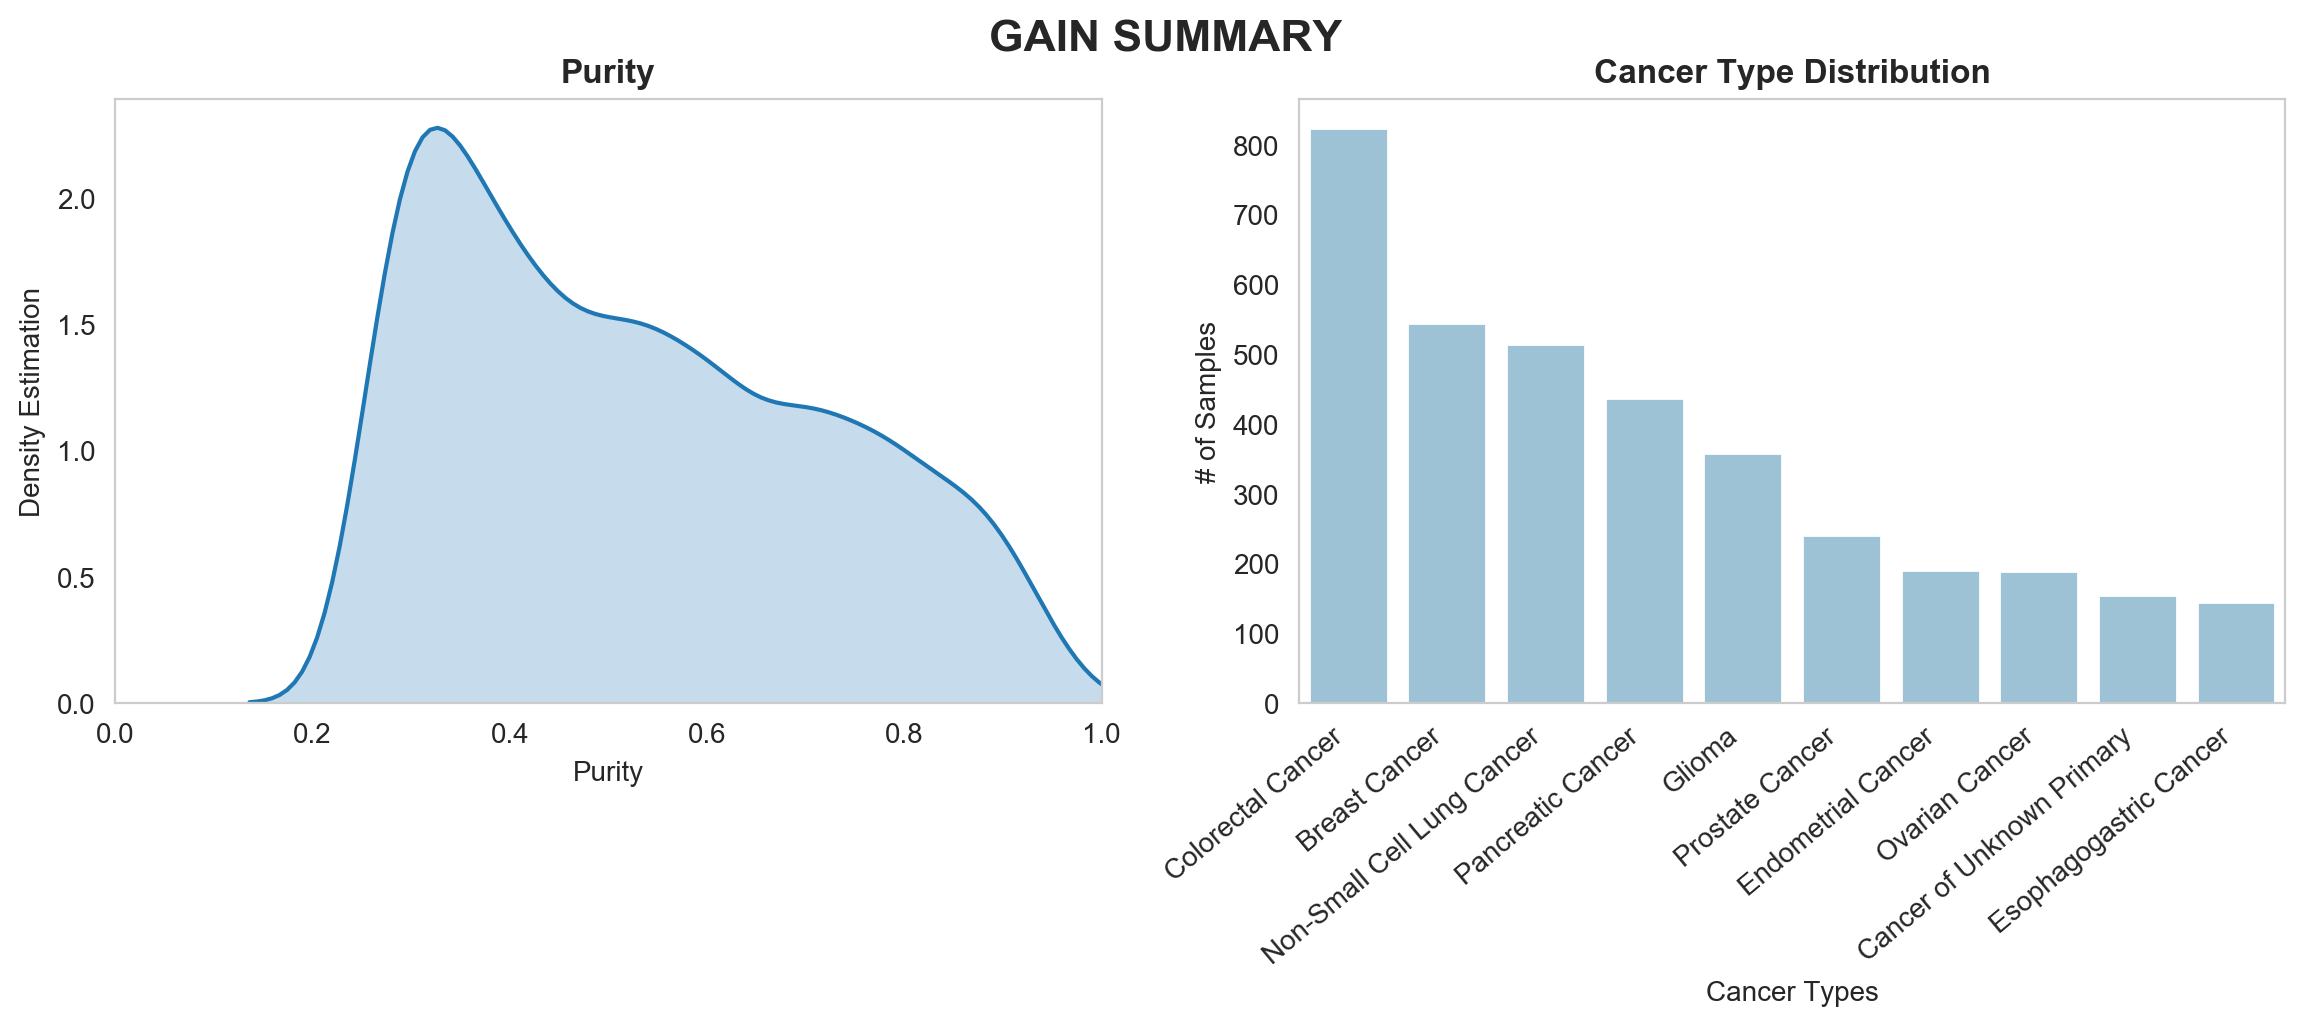

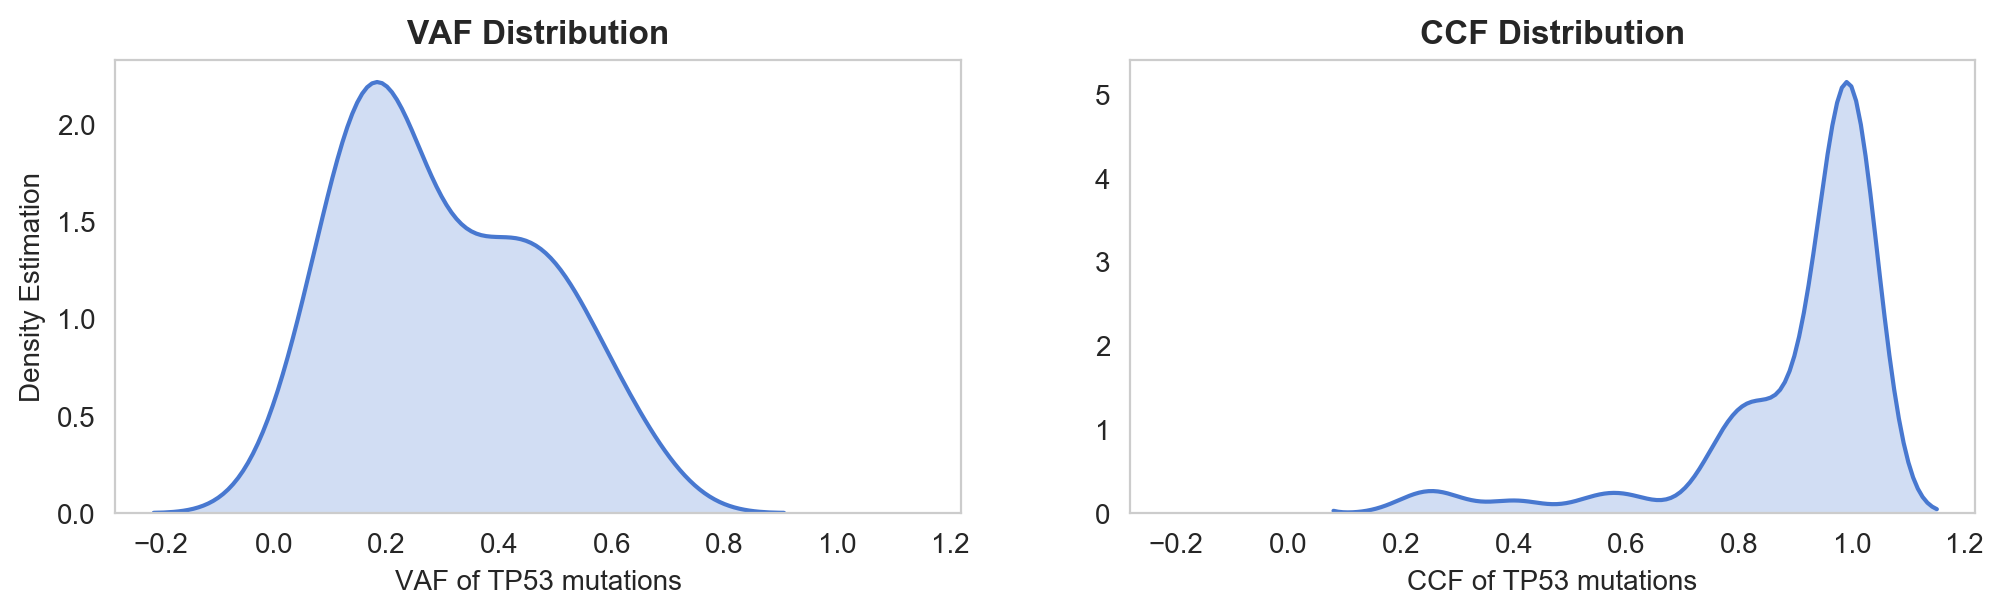

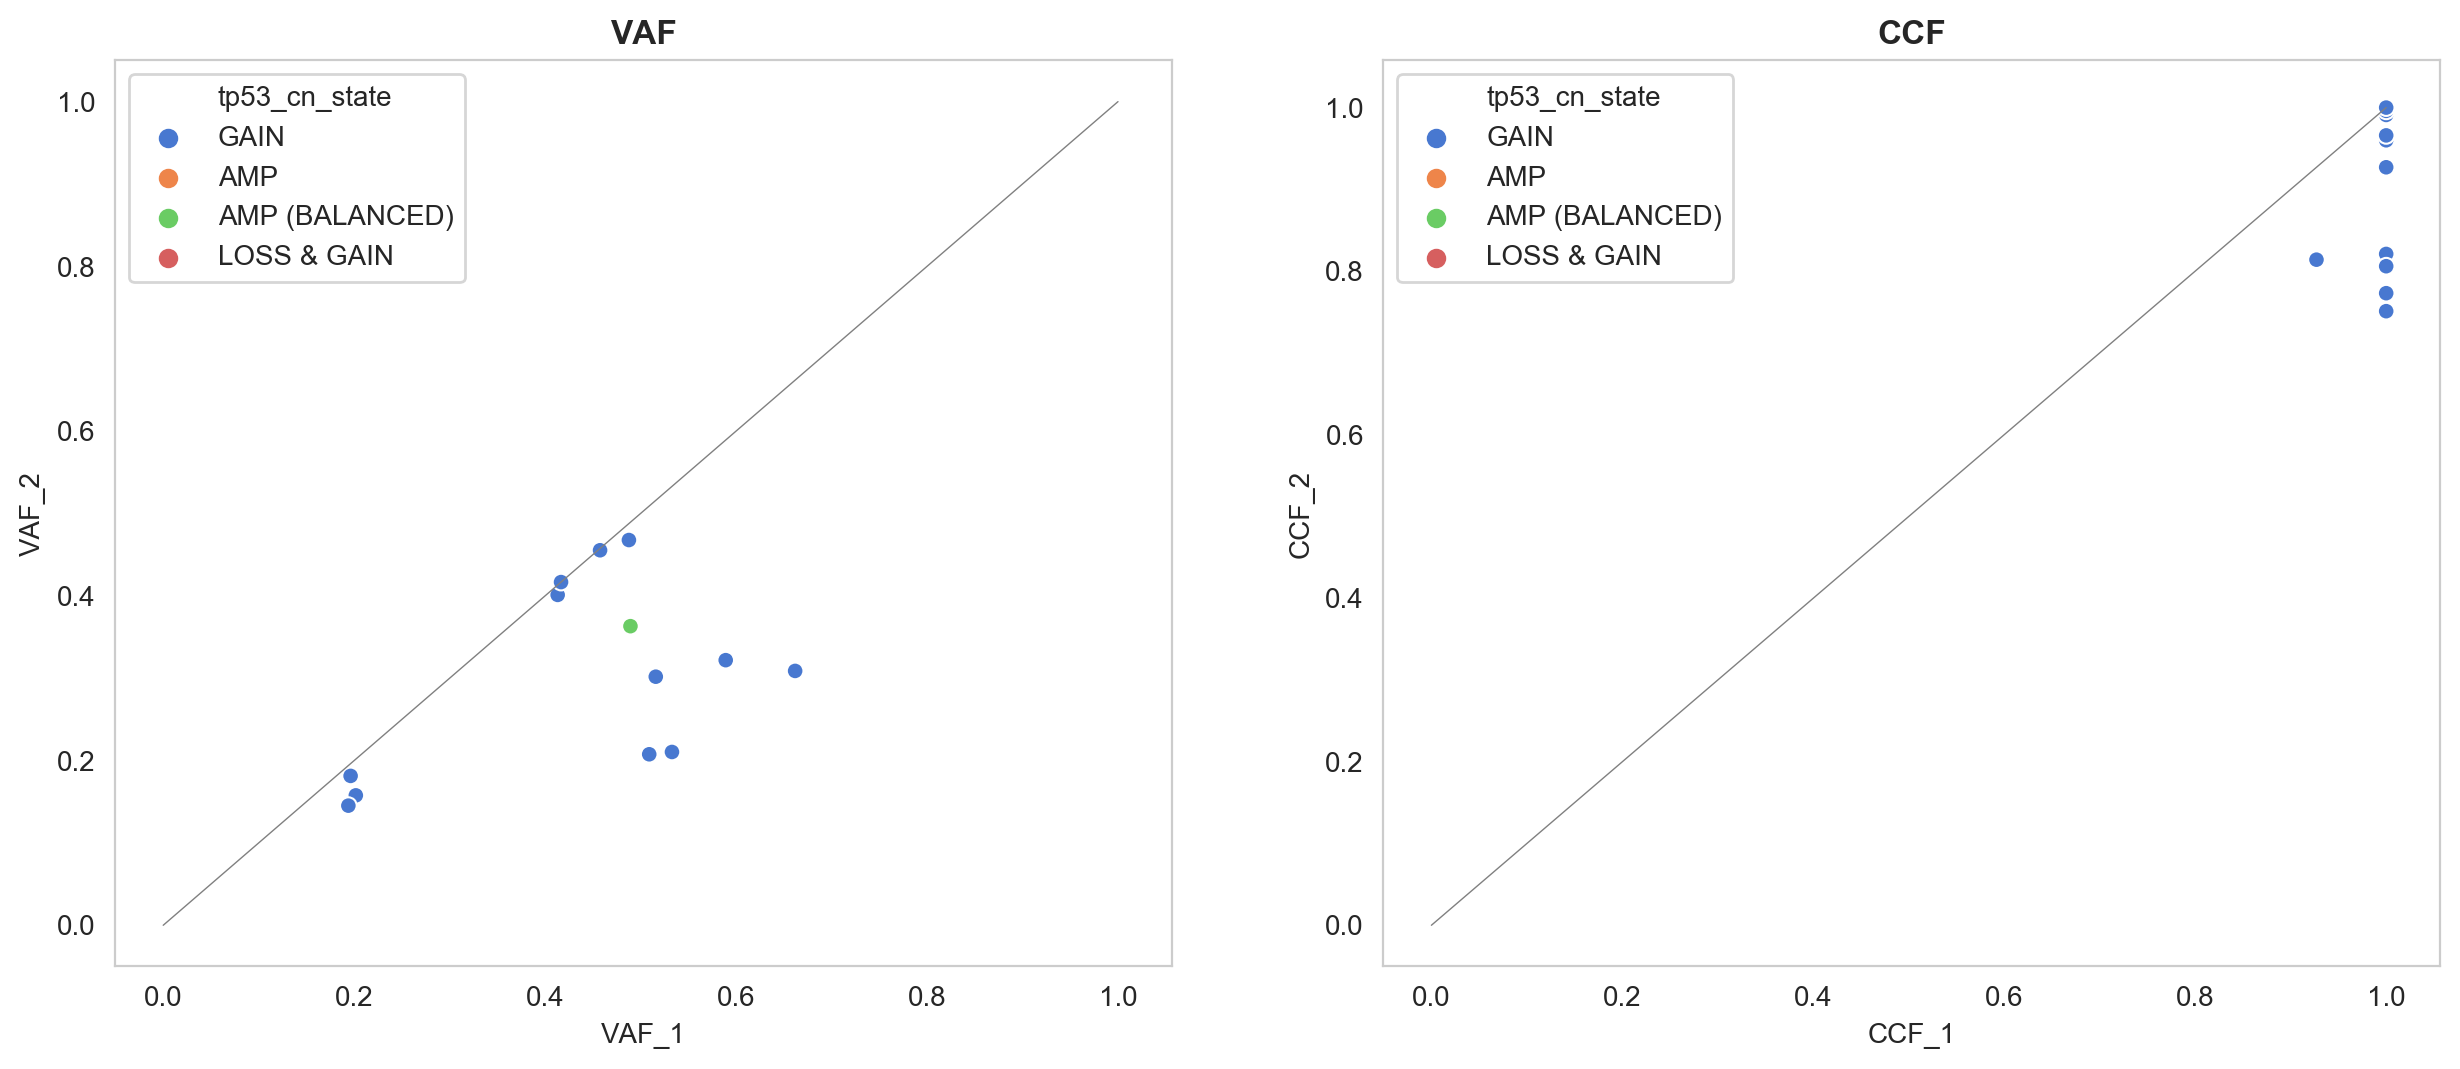

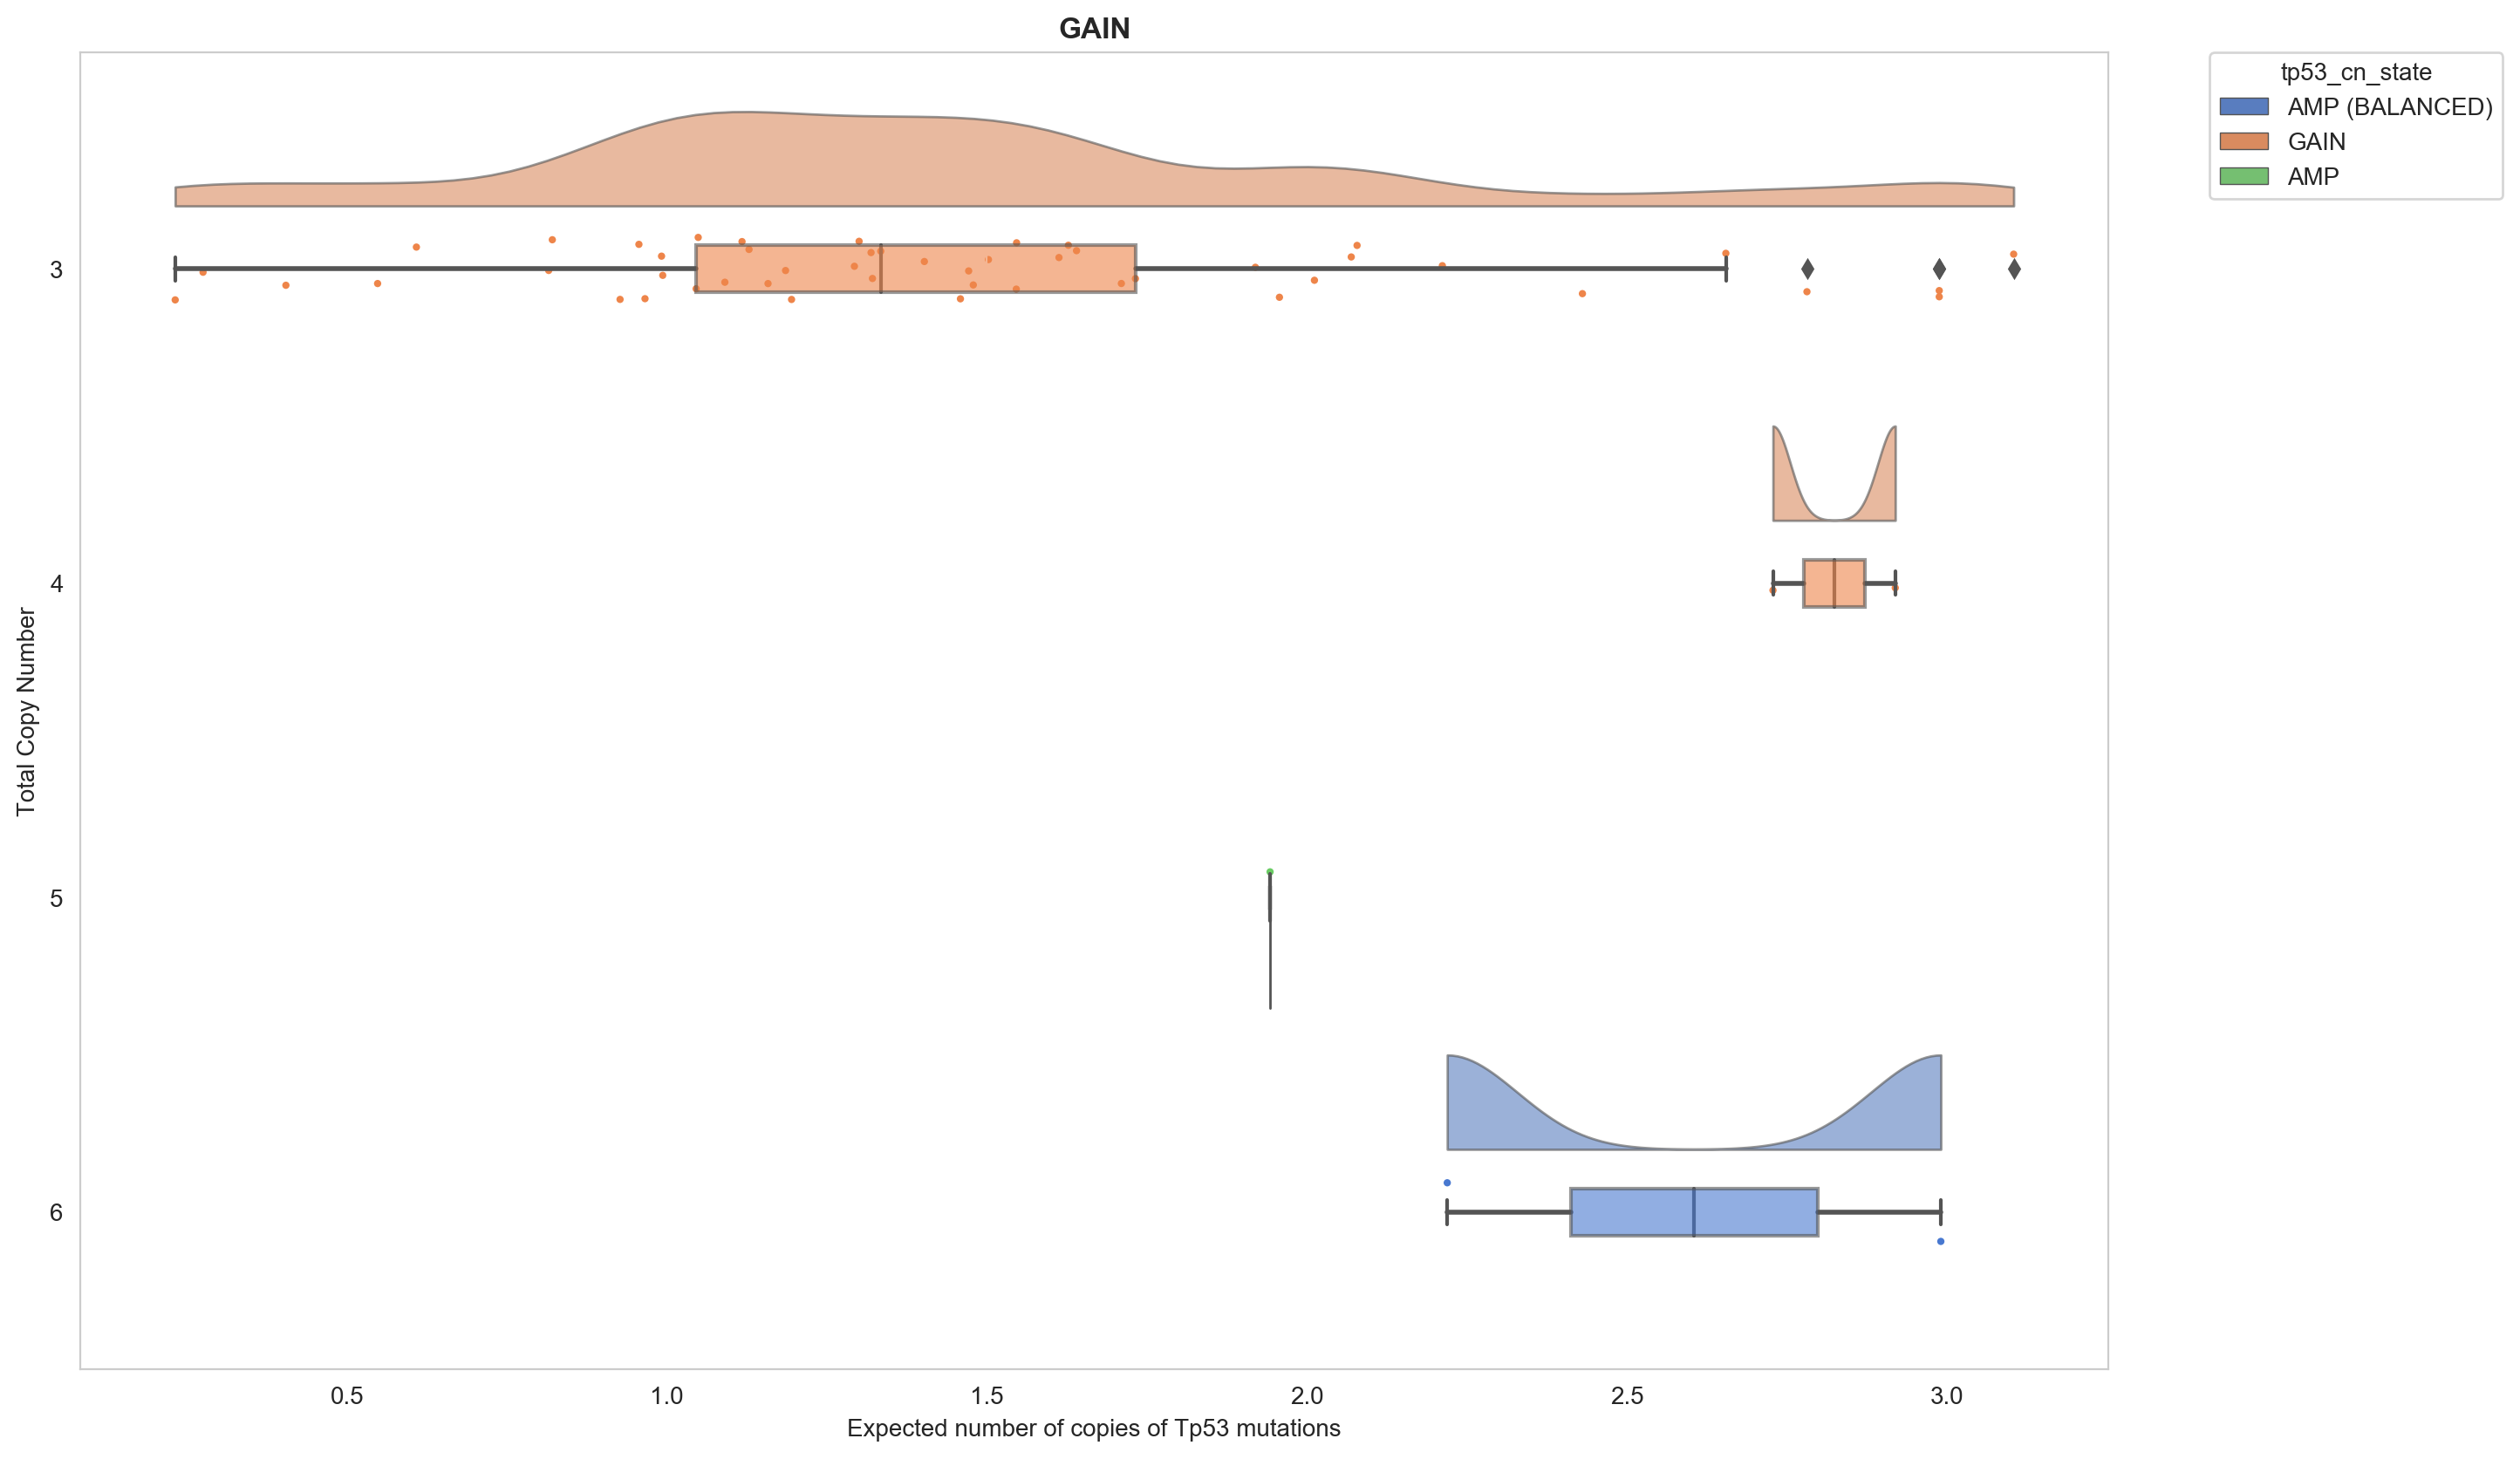

In [13]:
plot_summary(GAIN,'GAIN')

---
## Data Exploration

Skip This Part to see directly the final subgroups.

Here we have the exploratory groups that we defined previously and allowed us to define the final subgroups.
Each plot is done with the following parameters:
* *nb_muts_density* = [1,2,3] is the number of tp53 mutations we selected to plot the densities (vaf, ccf, purity)
* *nb_muts_scatter* = [2,3] is the number of tp53 mutations we selected to plot the scatters (VAF1/VAF2 and CCF1/CCF2)
* For the plot of expected number of tp53 mutations copies, we selected only 1 mutation samples

In [14]:
# Group Definition
WT_allele = ['LOSS AFTER', 'DIPLOID', 'TETRAPLOID']
LOSS_noWT = ['LOSS BEFORE', 'HETLOSS', 'LOSS BEFORE & AFTER']
LOH_noWT = ['CNLOH', 'CNLOH BEFORE & LOSS', 'CNLOH BEFORE', 'CNLOH BEFORE & GAIN']
GAIN_WT = ['AMP', 'GAIN','LOSS & GAIN']
AMBIGUOUS = ['CNLOH AFTER', 'DOUBLE LOSS AFTER']
MISSING = ['HOMDEL', 'AMP (BALANCED)', 'AMP (LOH)']
indeterminate = ['INDETERMINATE', '']

count 
 
 
 tp53_cn_state 
 
 
 
 
 
 DIPLOID 
 758 
 
 
 TETRAPLOID 
 2 
 
 
 
 
 
 
 count 
 
 
 Cancer_Type 
 
 
 
 
 
 Glioma 
 146 
 
 
 Colorectal Cancer 
 130 
 
 
 Non-Small Cell Lung Cancer 
 74 
 
 
 Bladder Cancer 
 46 
 
 
 Endometrial Cancer 
 44 
 
 
 Skin Cancer, Non-Melanoma 
 38 
 
 
 Cancer of Unknown Primary 
 35 
 
 
 Prostate Cancer 
 30 
 
 
 Esophagogastric Cancer 
 29 
 
 
 Head and Neck Cancer 
 23 
 
 
 Breast Cancer 
 20 
 
 
 Pancreatic Cancer 
 19 
 
 
 Melanoma 
 18 
 
 
 Soft Tissue Sarcoma 
 16 
 
 
 Hepatobiliary Cancer 
 15 
 
 
 
 
 
 
 count 
 
 
 tp53_count 
 
 
 
 
 
 1 
 393 
 
 
 2 
 321 
 
 
 3 
 46

<Figure size 600x600 with 0 Axes>

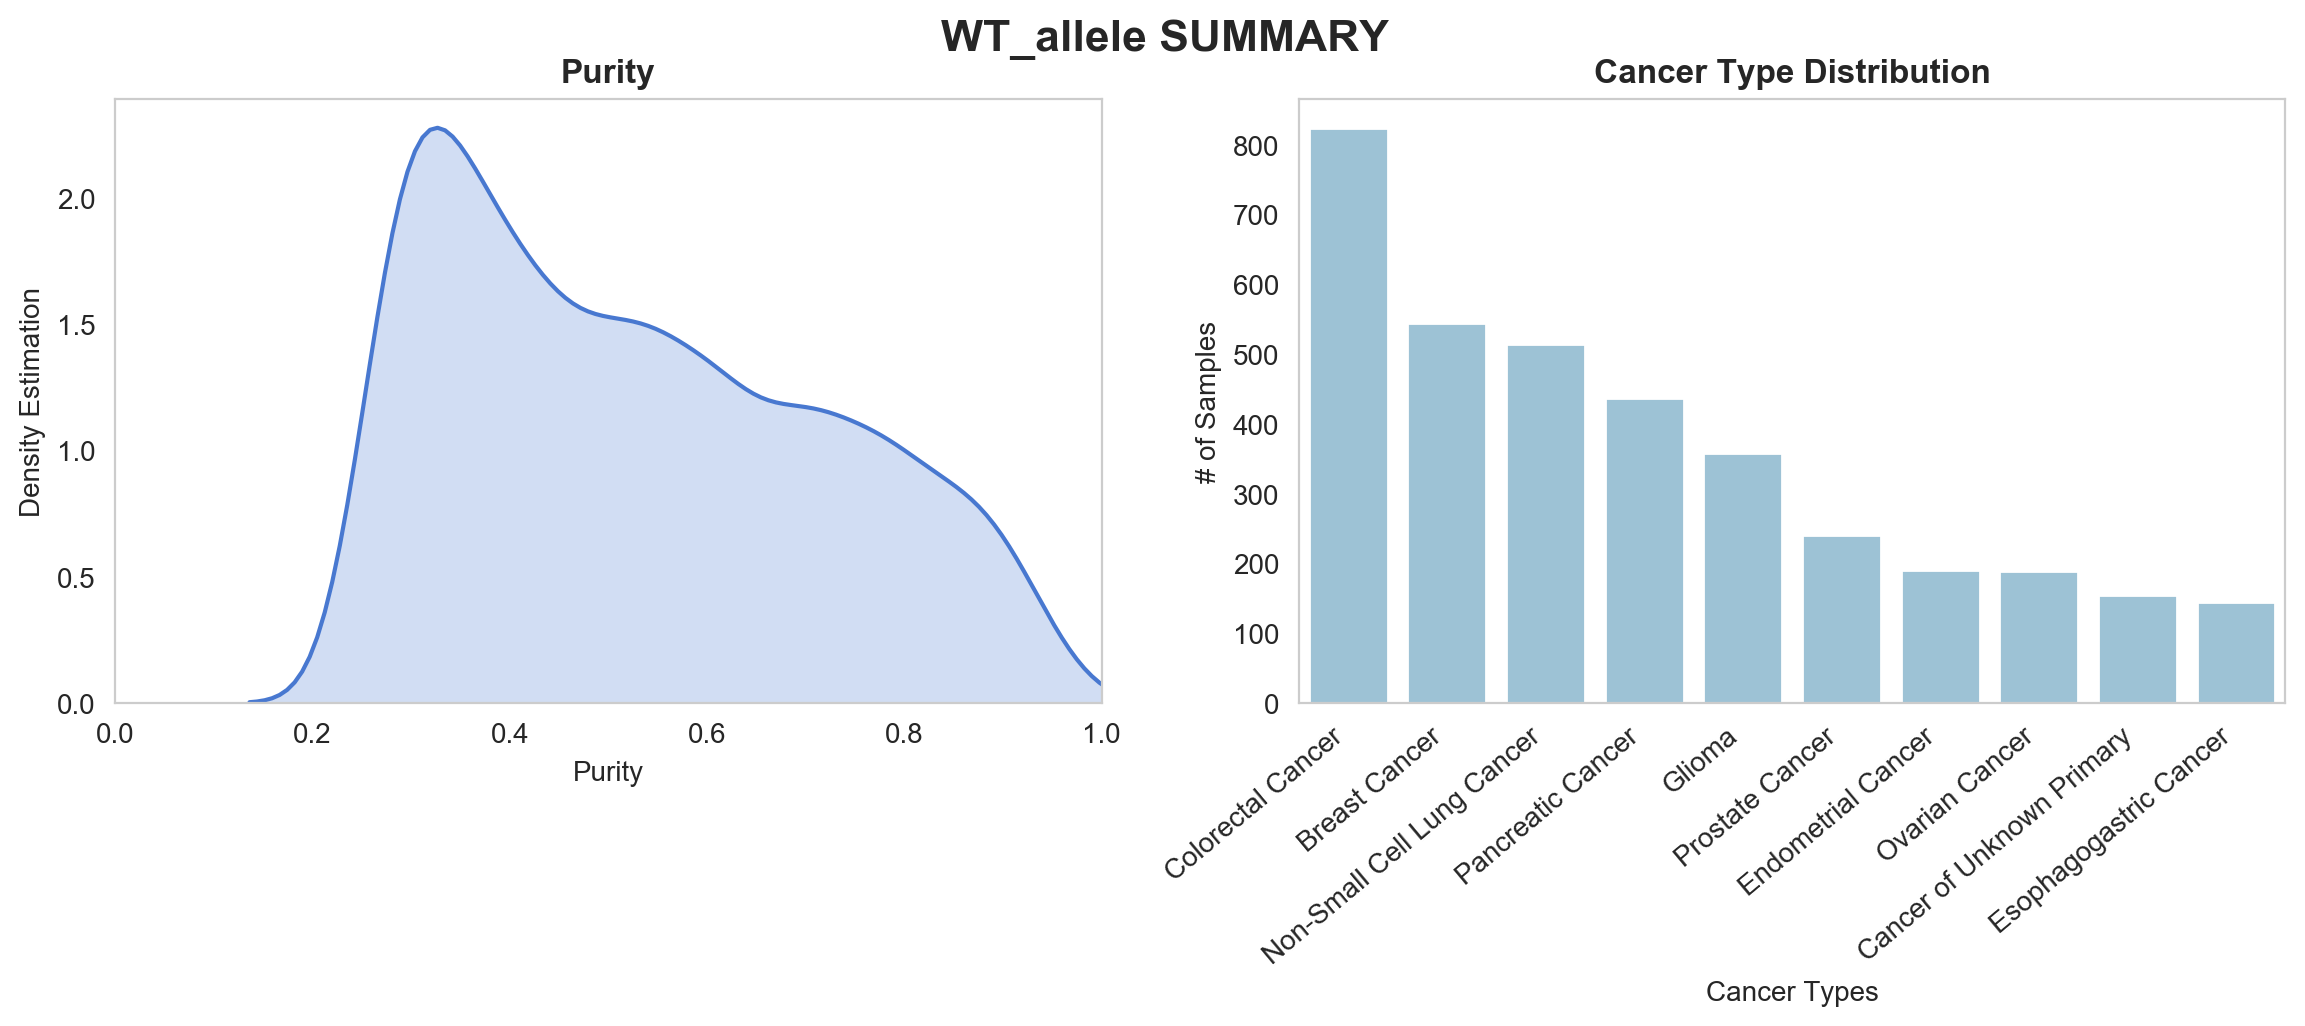

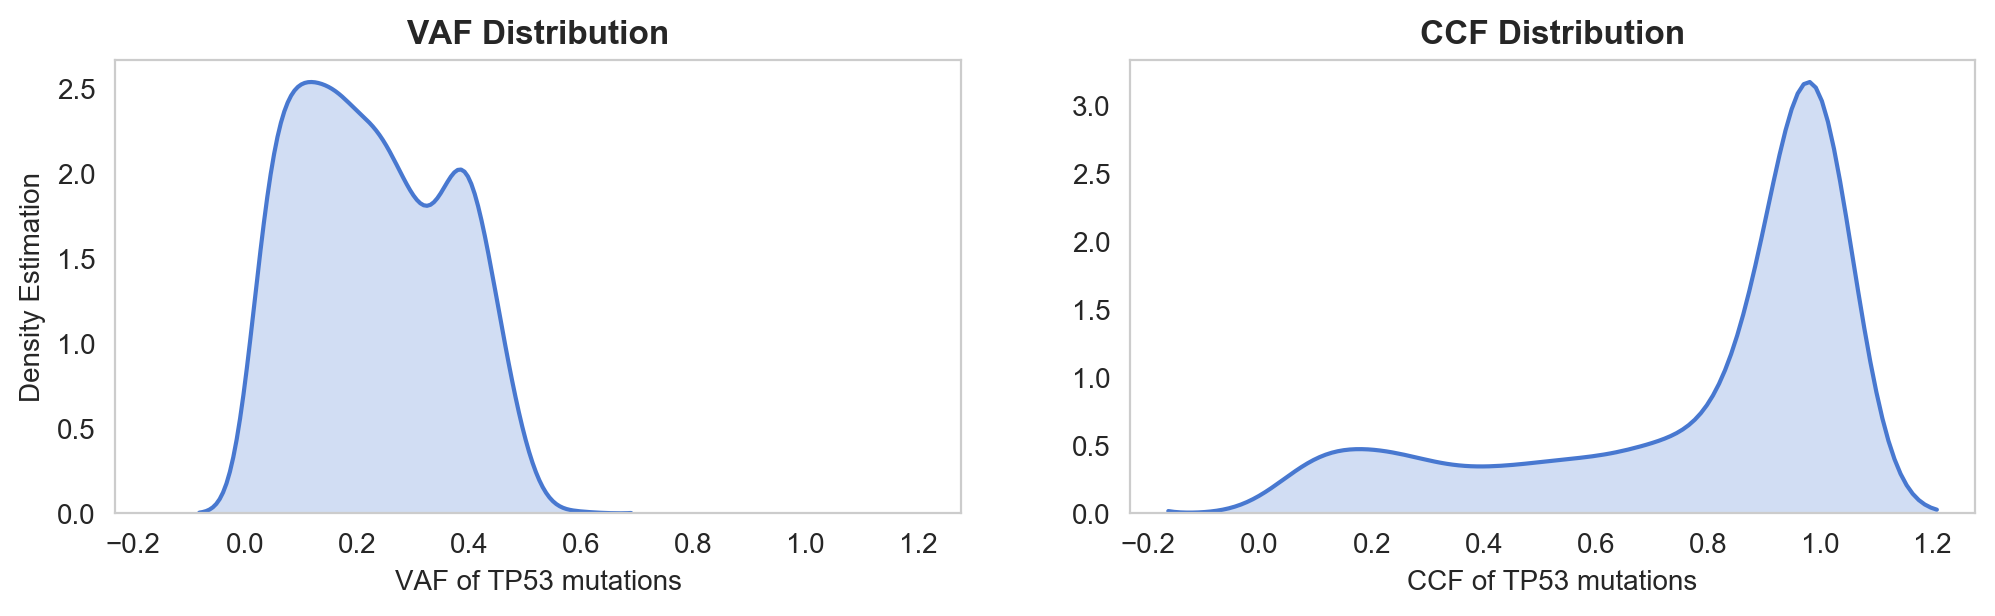

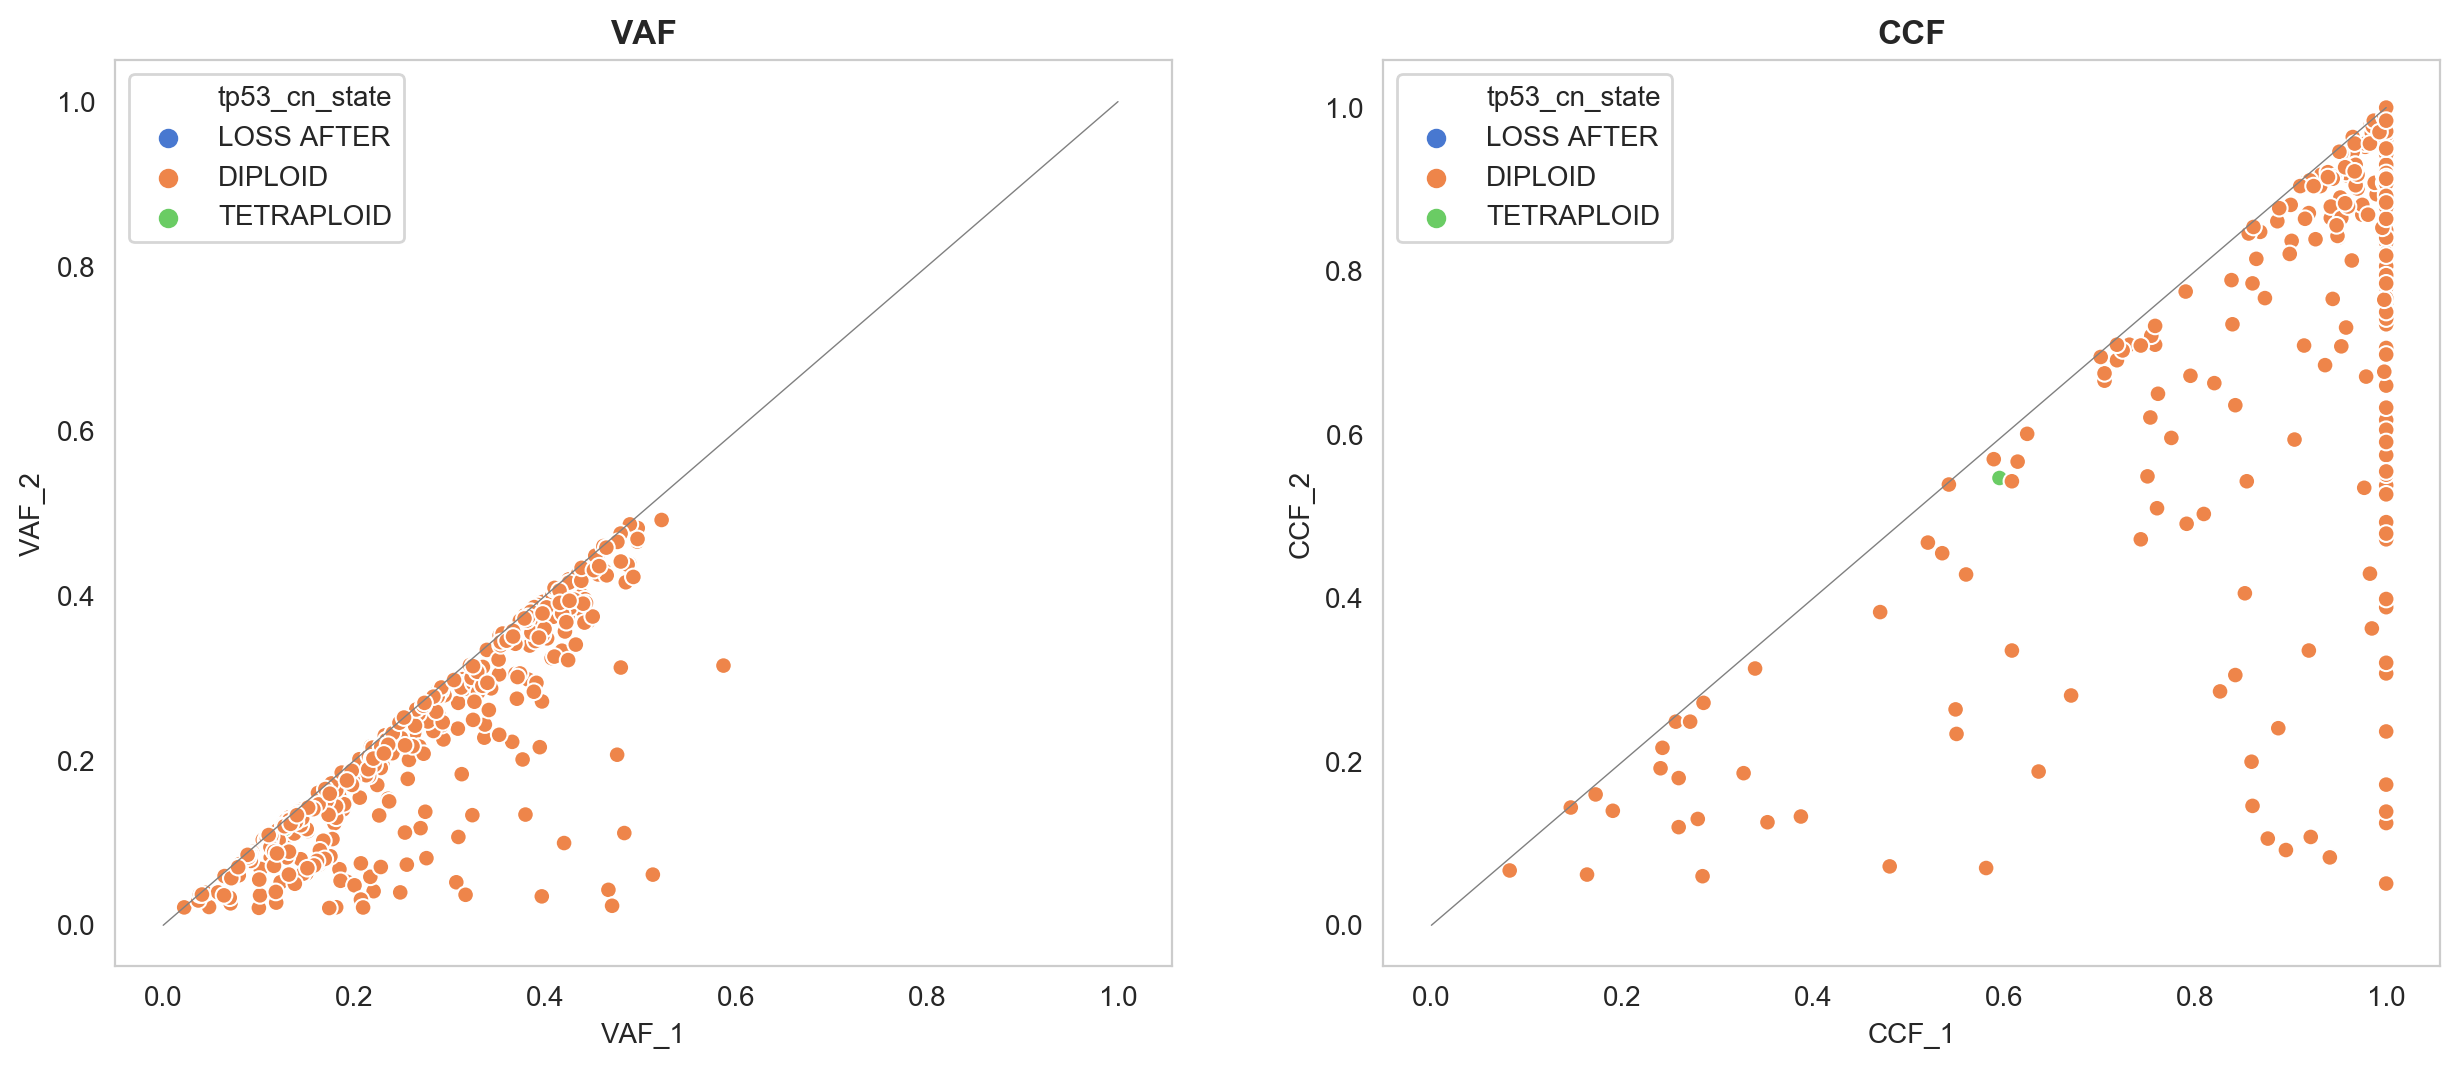

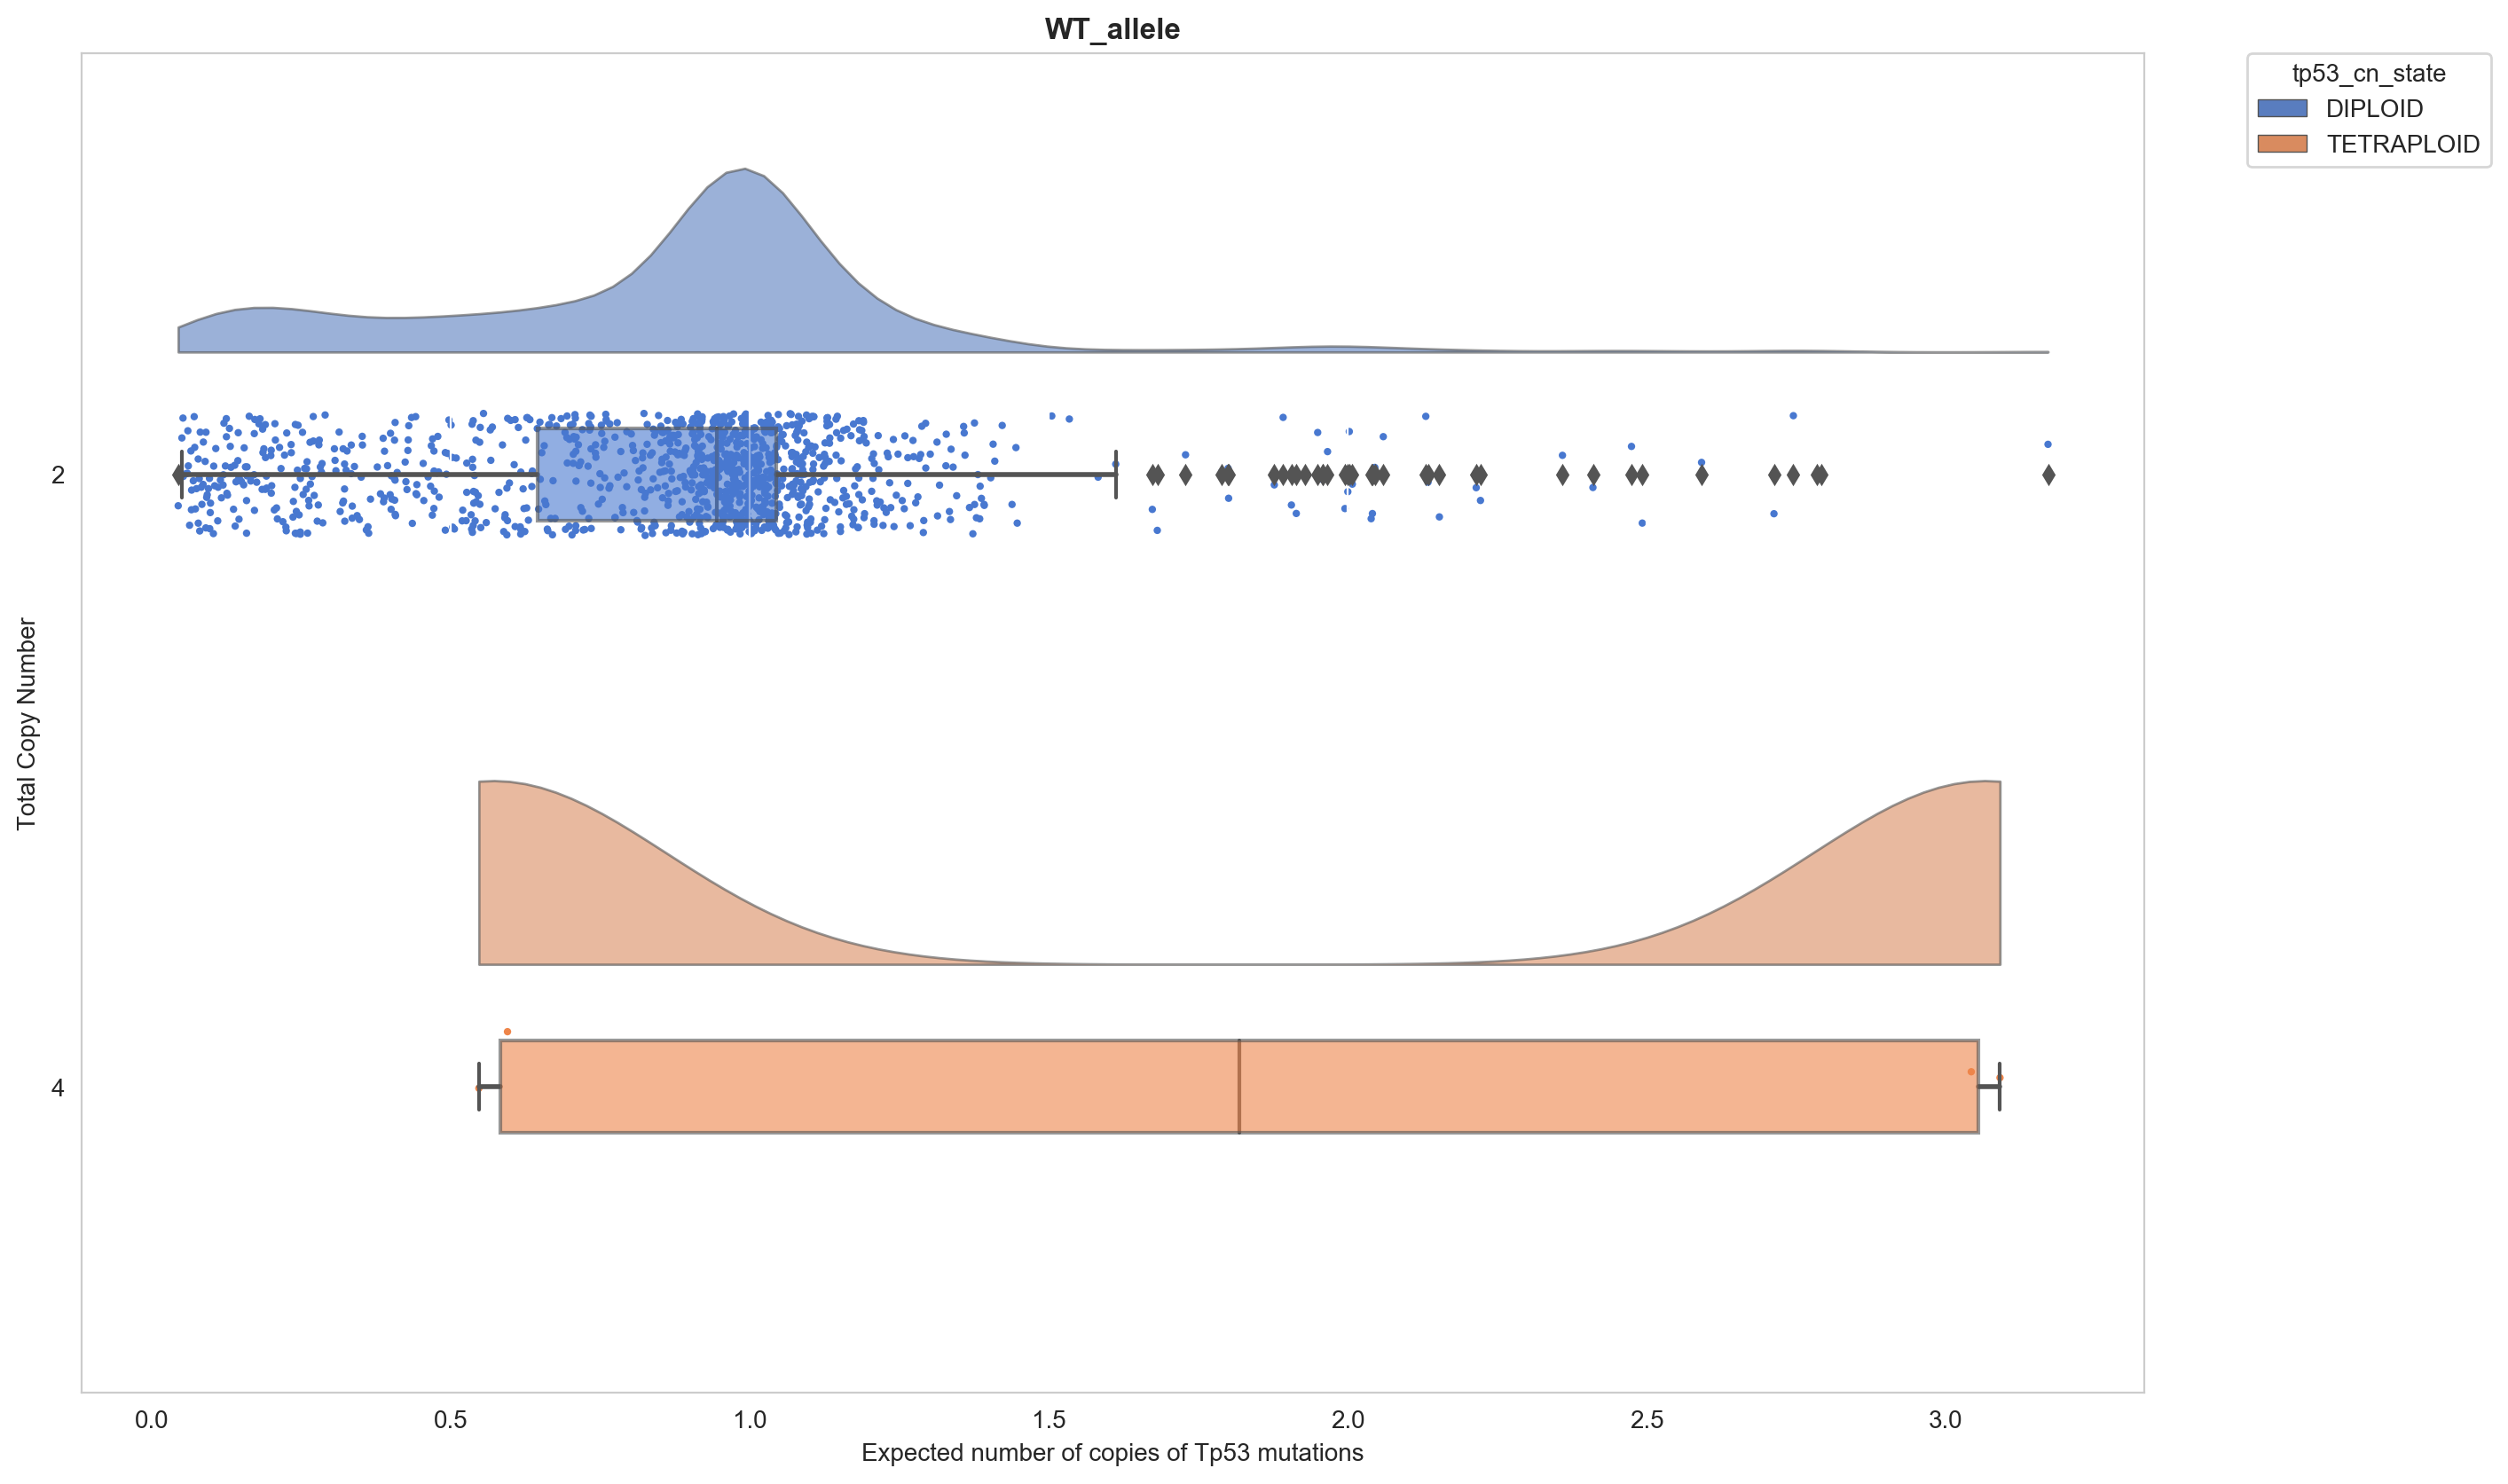

In [15]:
plot_summary(WT_allele,'WT_allele')

count 
 
 
 tp53_cn_state 
 
 
 
 
 
 HETLOSS 
 3148 
 
 
 
 
 
 
 count 
 
 
 Cancer_Type 
 
 
 
 
 
 Colorectal Cancer 
 588 
 
 
 Breast Cancer 
 461 
 
 
 Pancreatic Cancer 
 382 
 
 
 Non-Small Cell Lung Cancer 
 360 
 
 
 Prostate Cancer 
 192 
 
 
 Ovarian Cancer 
 156 
 
 
 Endometrial Cancer 
 120 
 
 
 Cancer of Unknown Primary 
 101 
 
 
 Hepatobiliary Cancer 
 90 
 
 
 Small Cell Lung Cancer 
 90 
 
 
 Esophagogastric Cancer 
 87 
 
 
 Glioma 
 73 
 
 
 Bladder Cancer 
 70 
 
 
 Soft Tissue Sarcoma 
 63 
 
 
 Melanoma 
 48 
 
 
 
 
 
 
 count 
 
 
 tp53_count 
 
 
 
 
 
 1 
 3041 
 
 
 2 
 95 
 
 
 3 
 12

<Figure size 600x600 with 0 Axes>

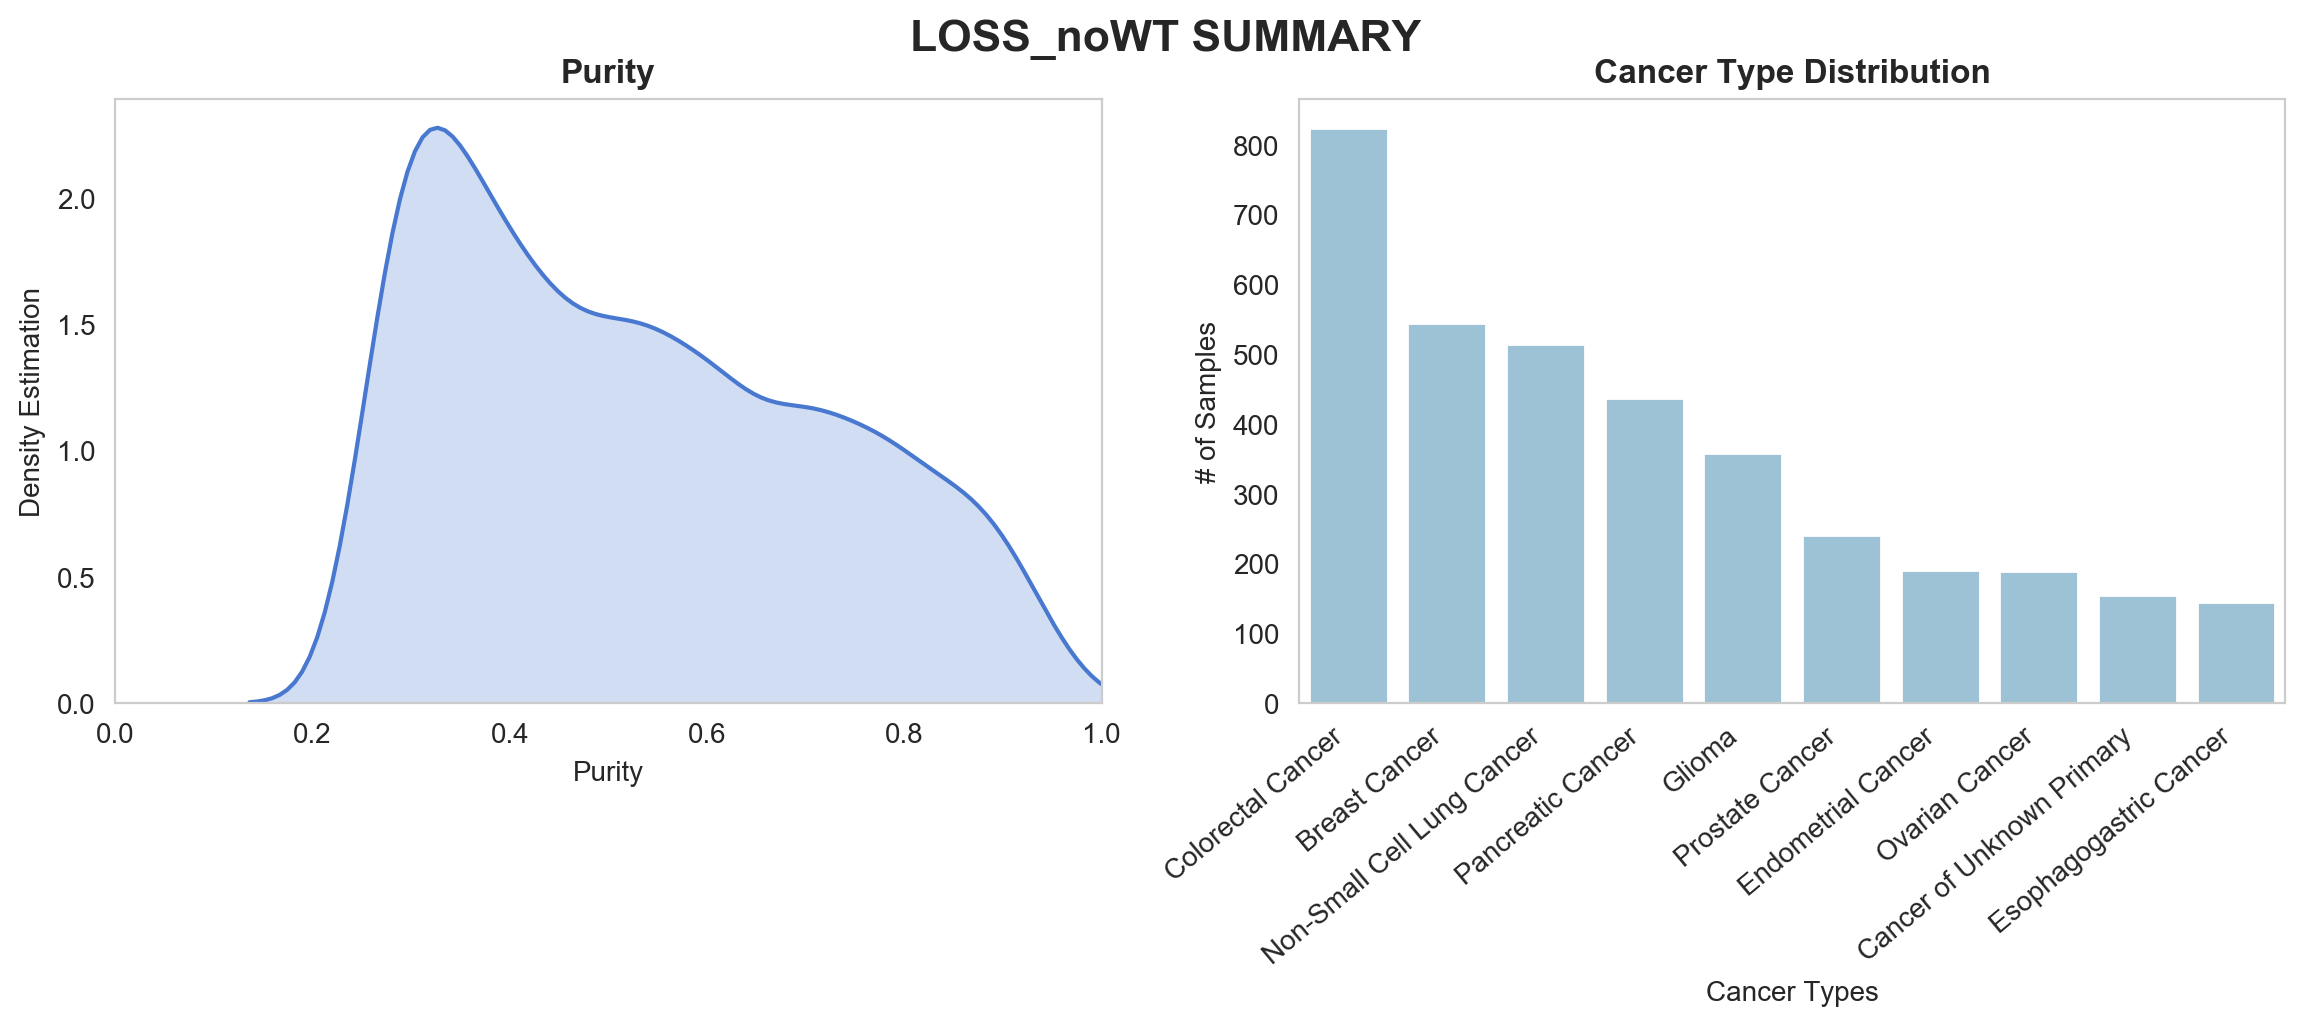

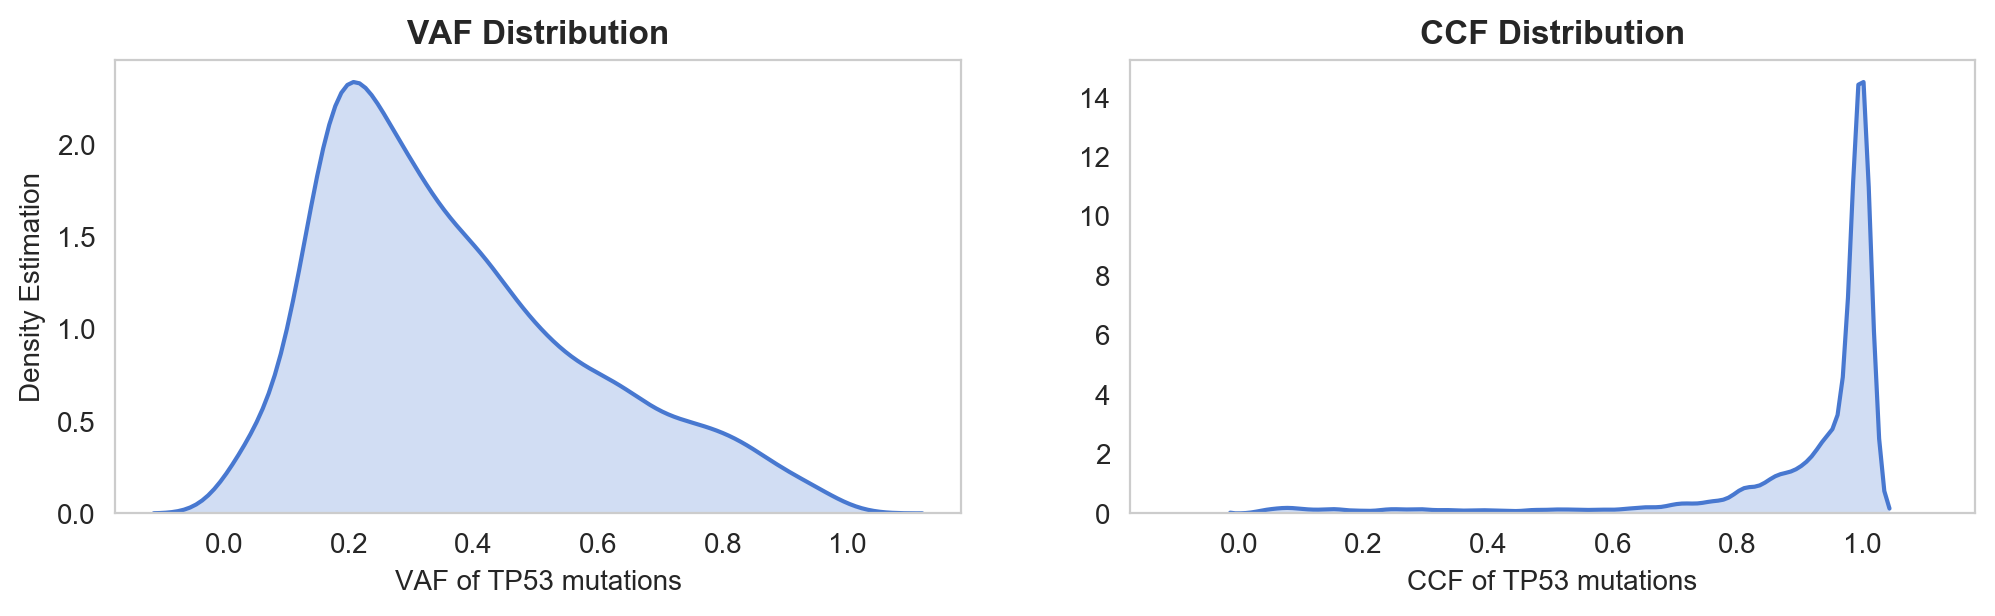

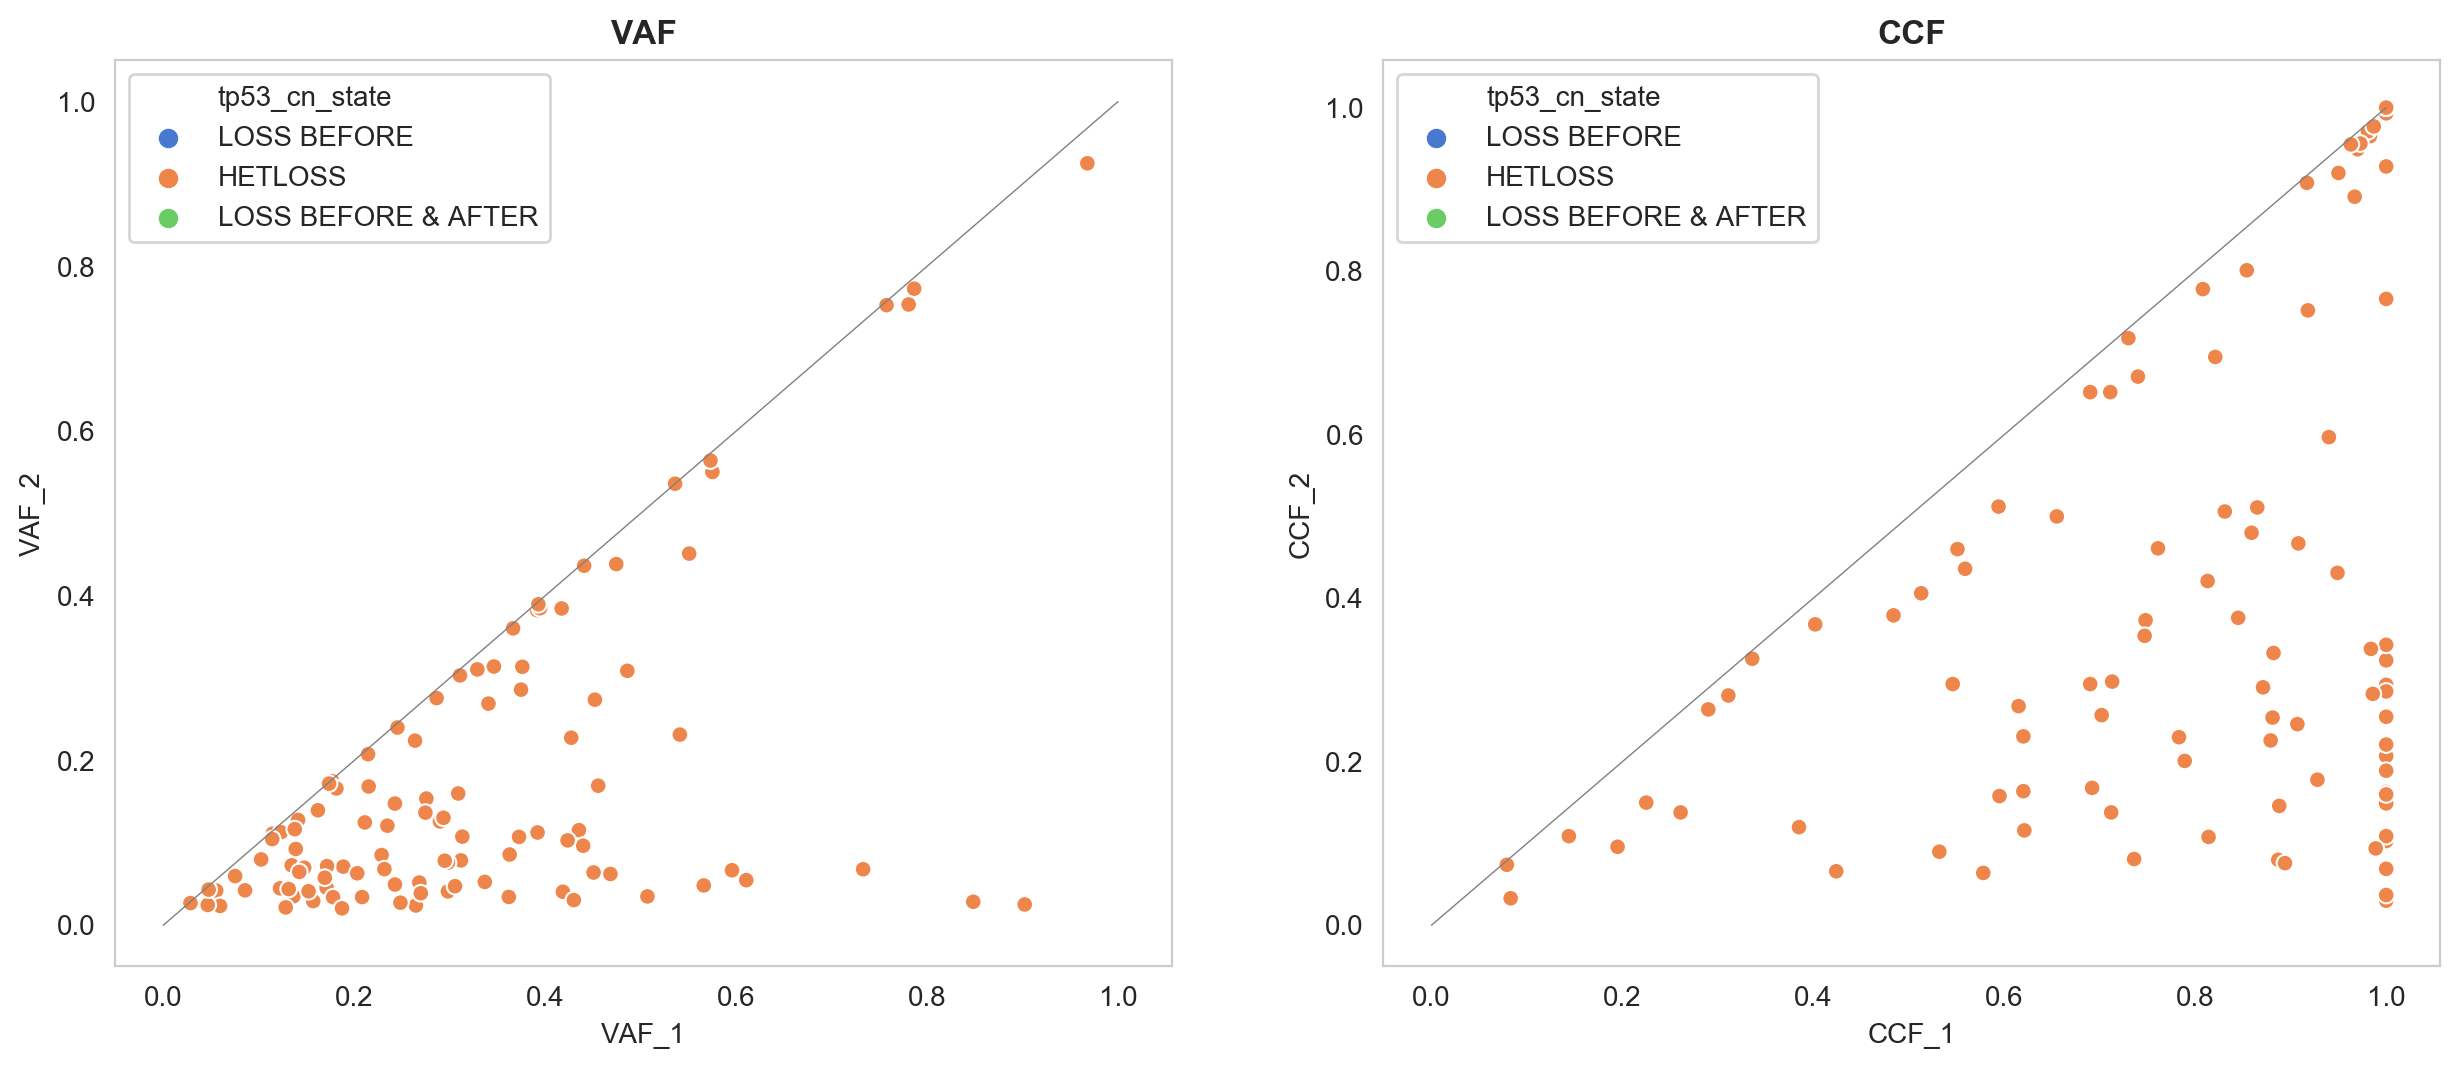

ValueError: There must be at least two hue levels to use `split`.'

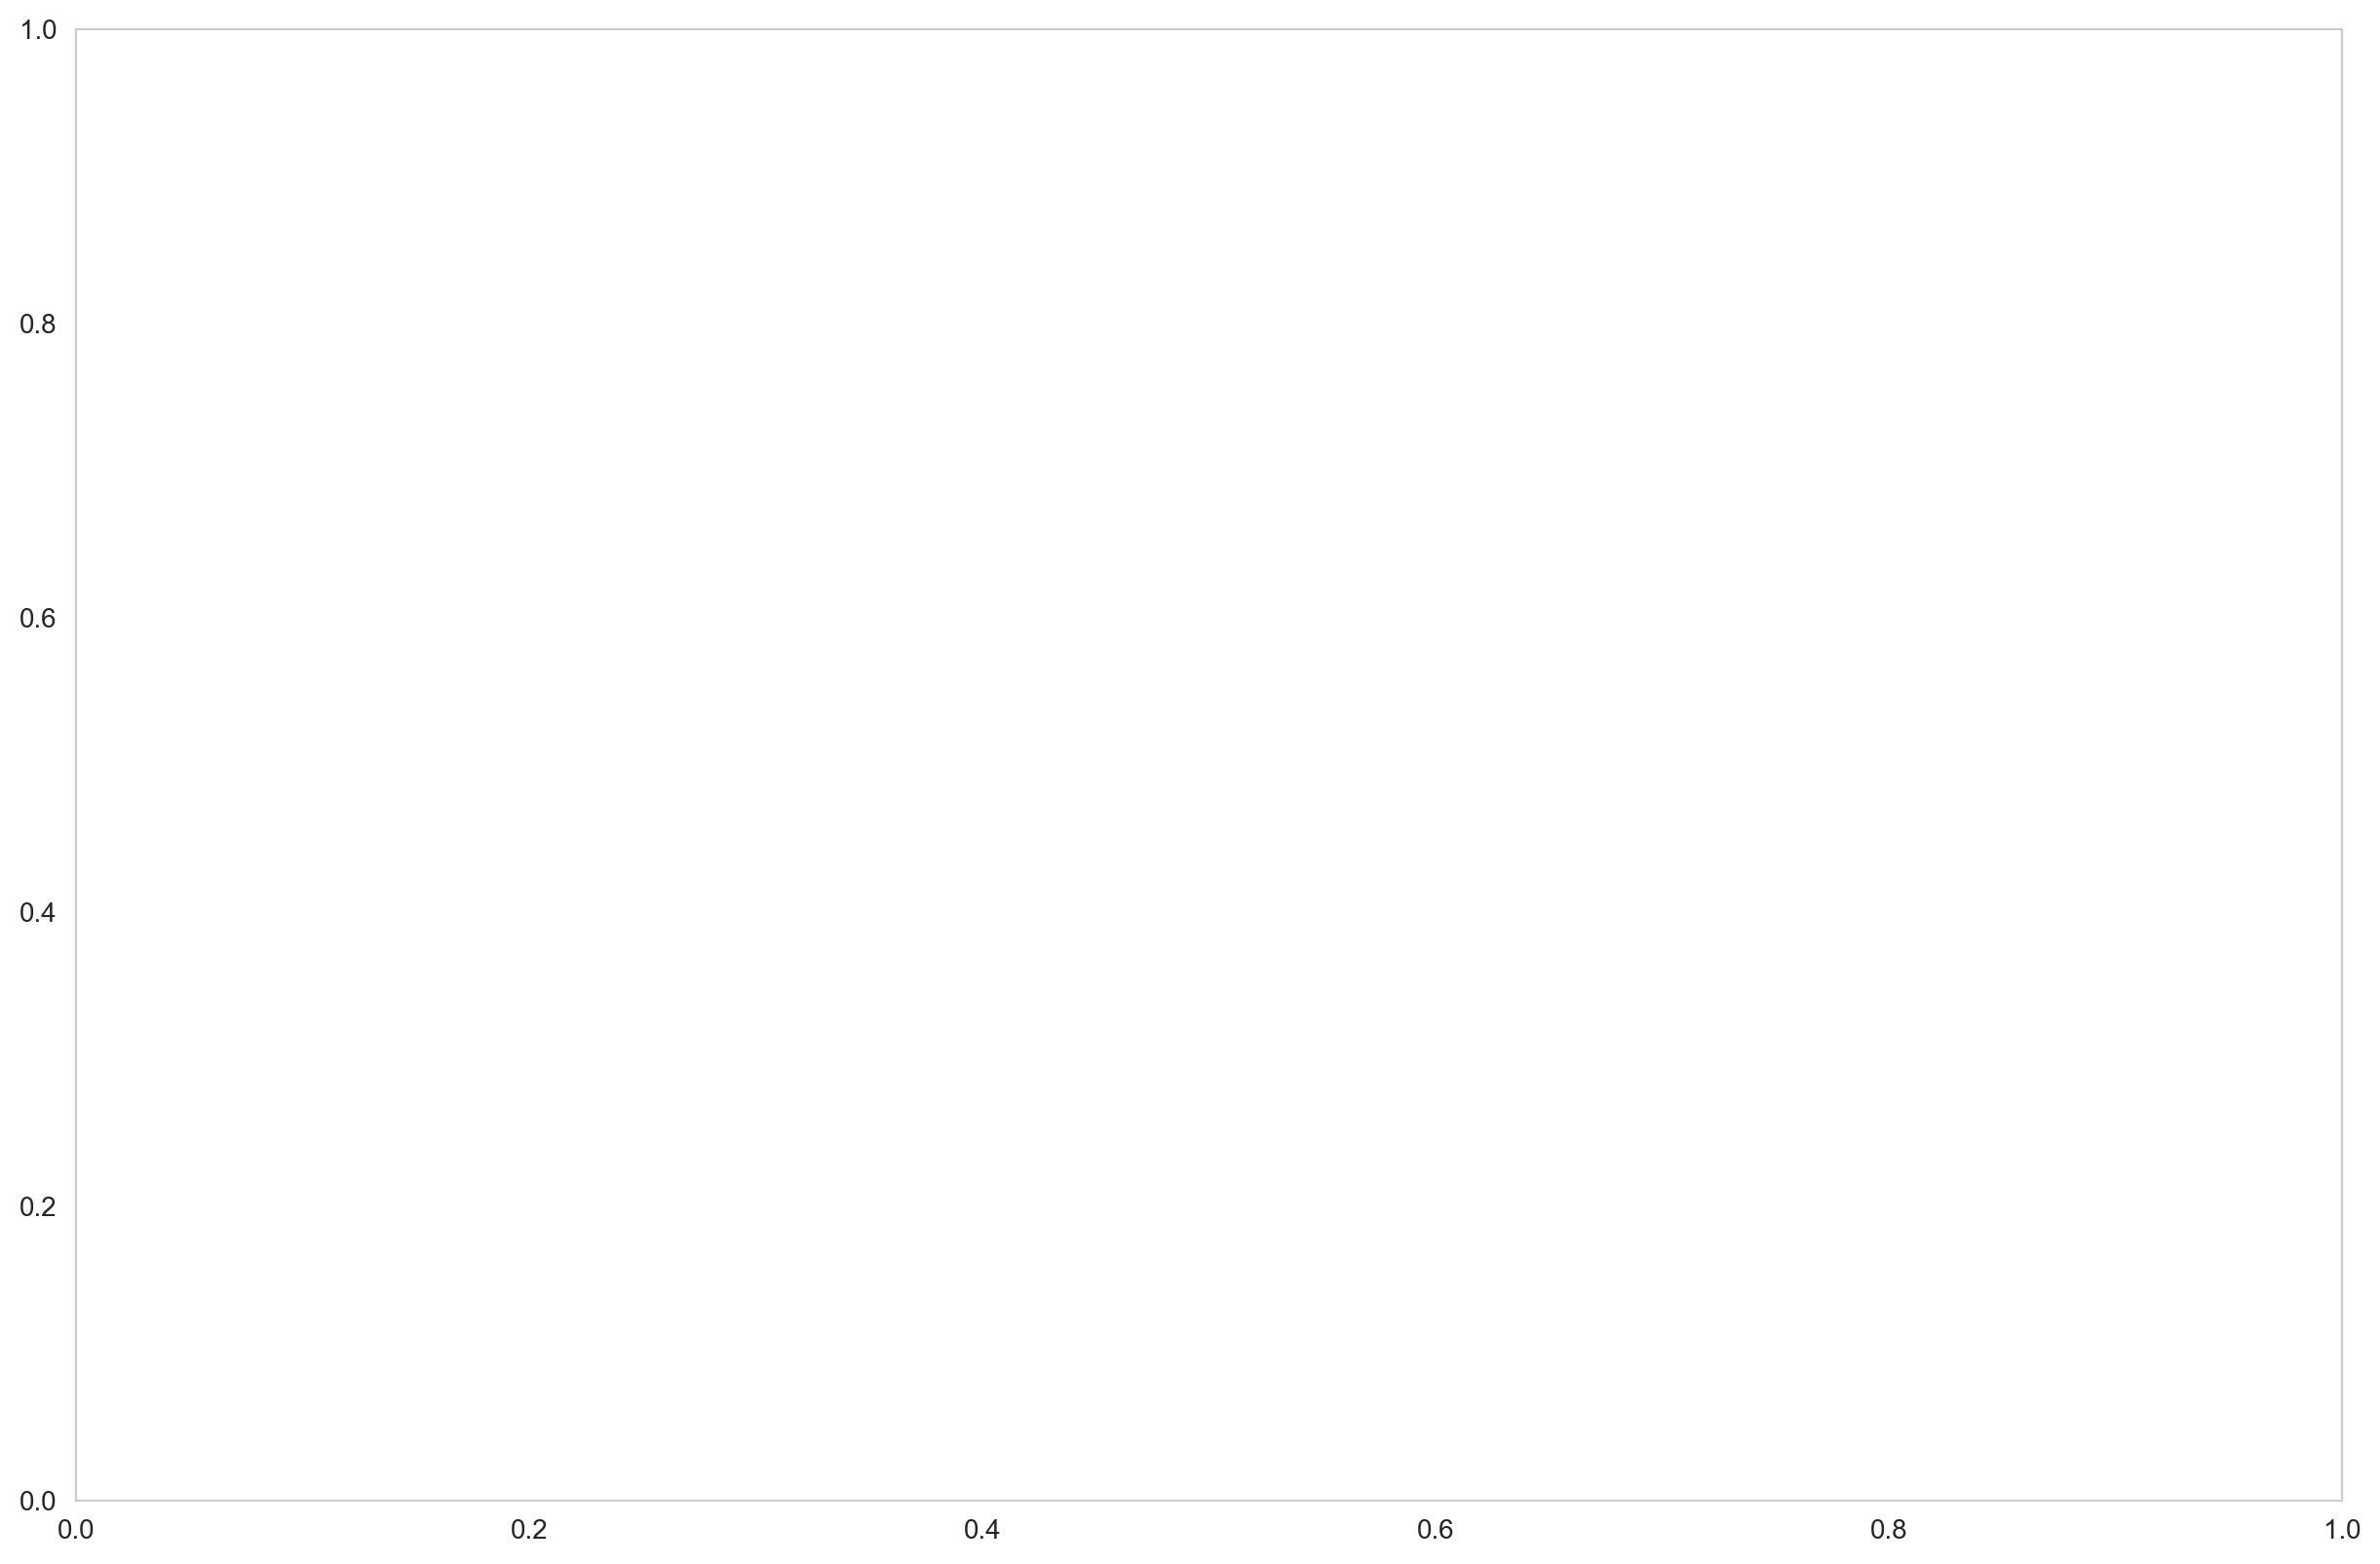

In [16]:
plot_summary(LOSS_noWT,'LOSS_noWT')

In [13]:
plot_summary(LOH,'LOH_noWT')

NameError: name 'LOH' is not defined

count 
 
 
 tp53_cn_state 
 
 
 
 
 
 AMP 
 11 
 
 
 GAIN 
 92 
 
 
 LOSS & GAIN 
 9 
 
 
 
 
 
 
 count 
 
 
 Cancer_Type 
 
 
 
 
 
 Non-Small Cell Lung Cancer 
 21 
 
 
 Glioma 
 13 
 
 
 Bladder Cancer 
 9 
 
 
 Colorectal Cancer 
 8 
 
 
 Cancer of Unknown Primary 
 7 
 
 
 Endometrial Cancer 
 7 
 
 
 Breast Cancer 
 6 
 
 
 Pancreatic Cancer 
 5 
 
 
 Esophagogastric Cancer 
 5 
 
 
 Prostate Cancer 
 5 
 
 
 Uterine Sarcoma 
 4 
 
 
 Head and Neck Cancer 
 3 
 
 
 Ovarian Cancer 
 3 
 
 
 Soft Tissue Sarcoma 
 2 
 
 
 Melanoma 
 2 
 
 
 
 
 
 
 count 
 
 
 tp53_count 
 
 
 
 
 
 1 
 74 
 
 
 2 
 35 
 
 
 3 
 3

<Figure size 600x600 with 0 Axes>

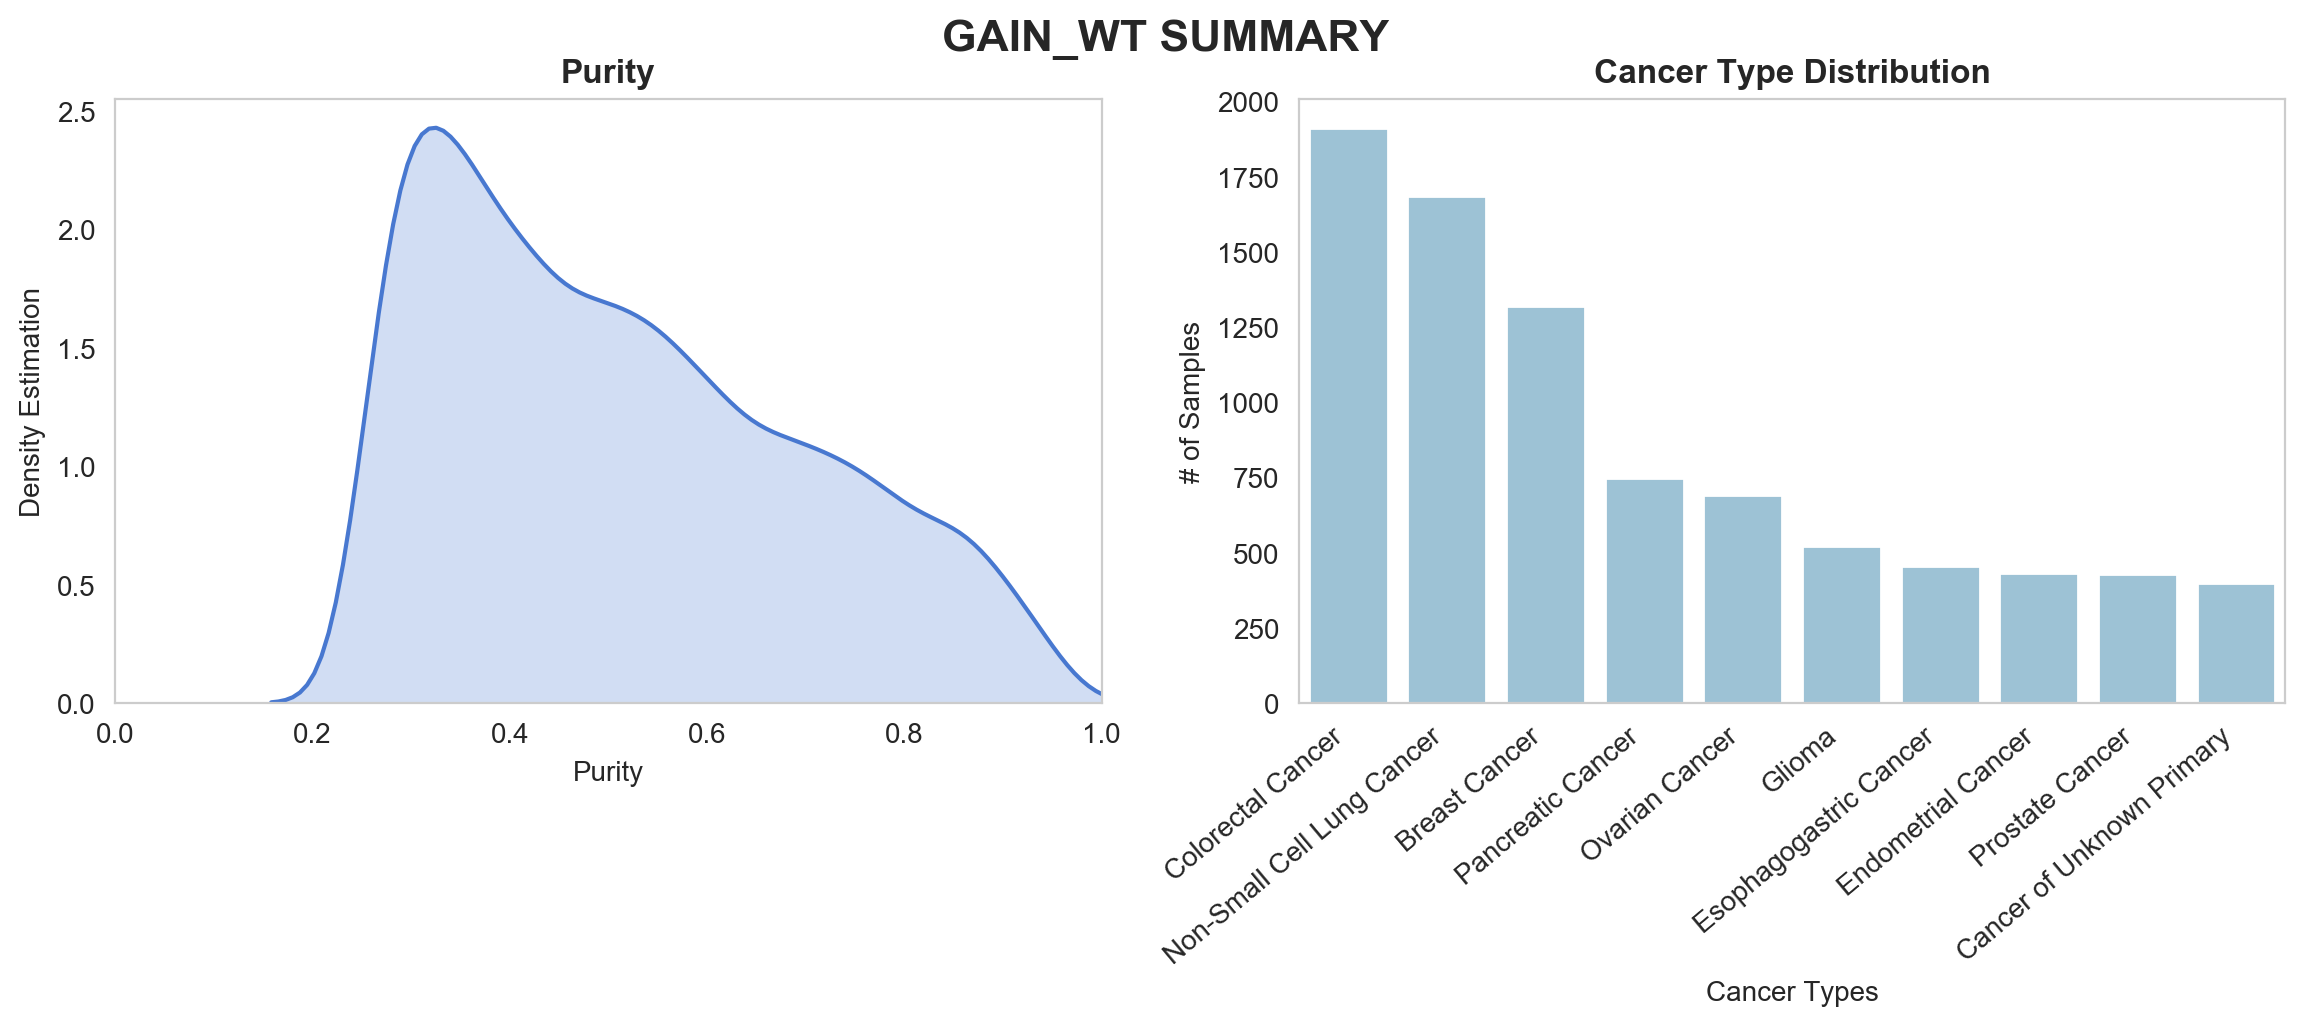

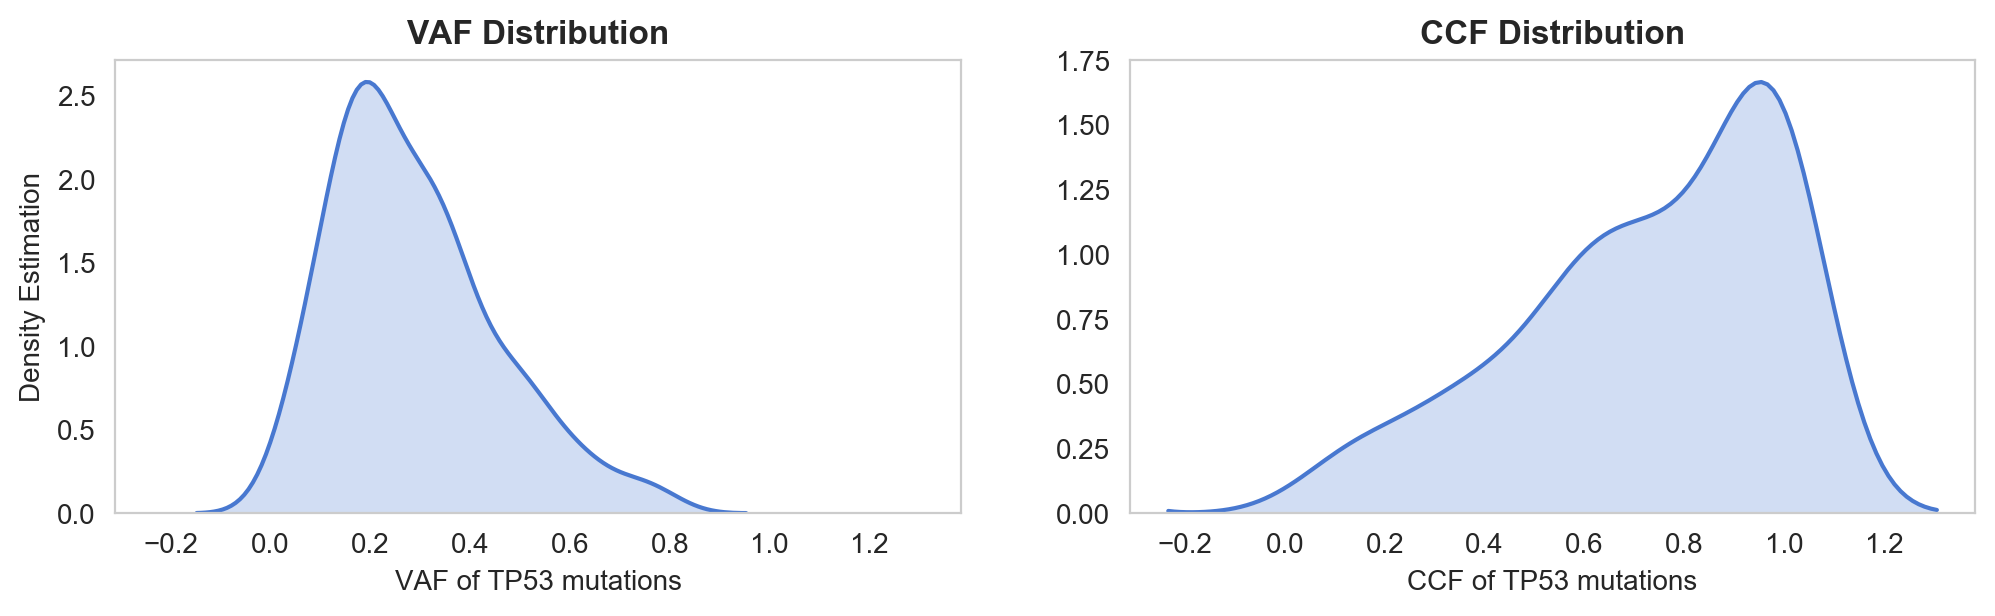

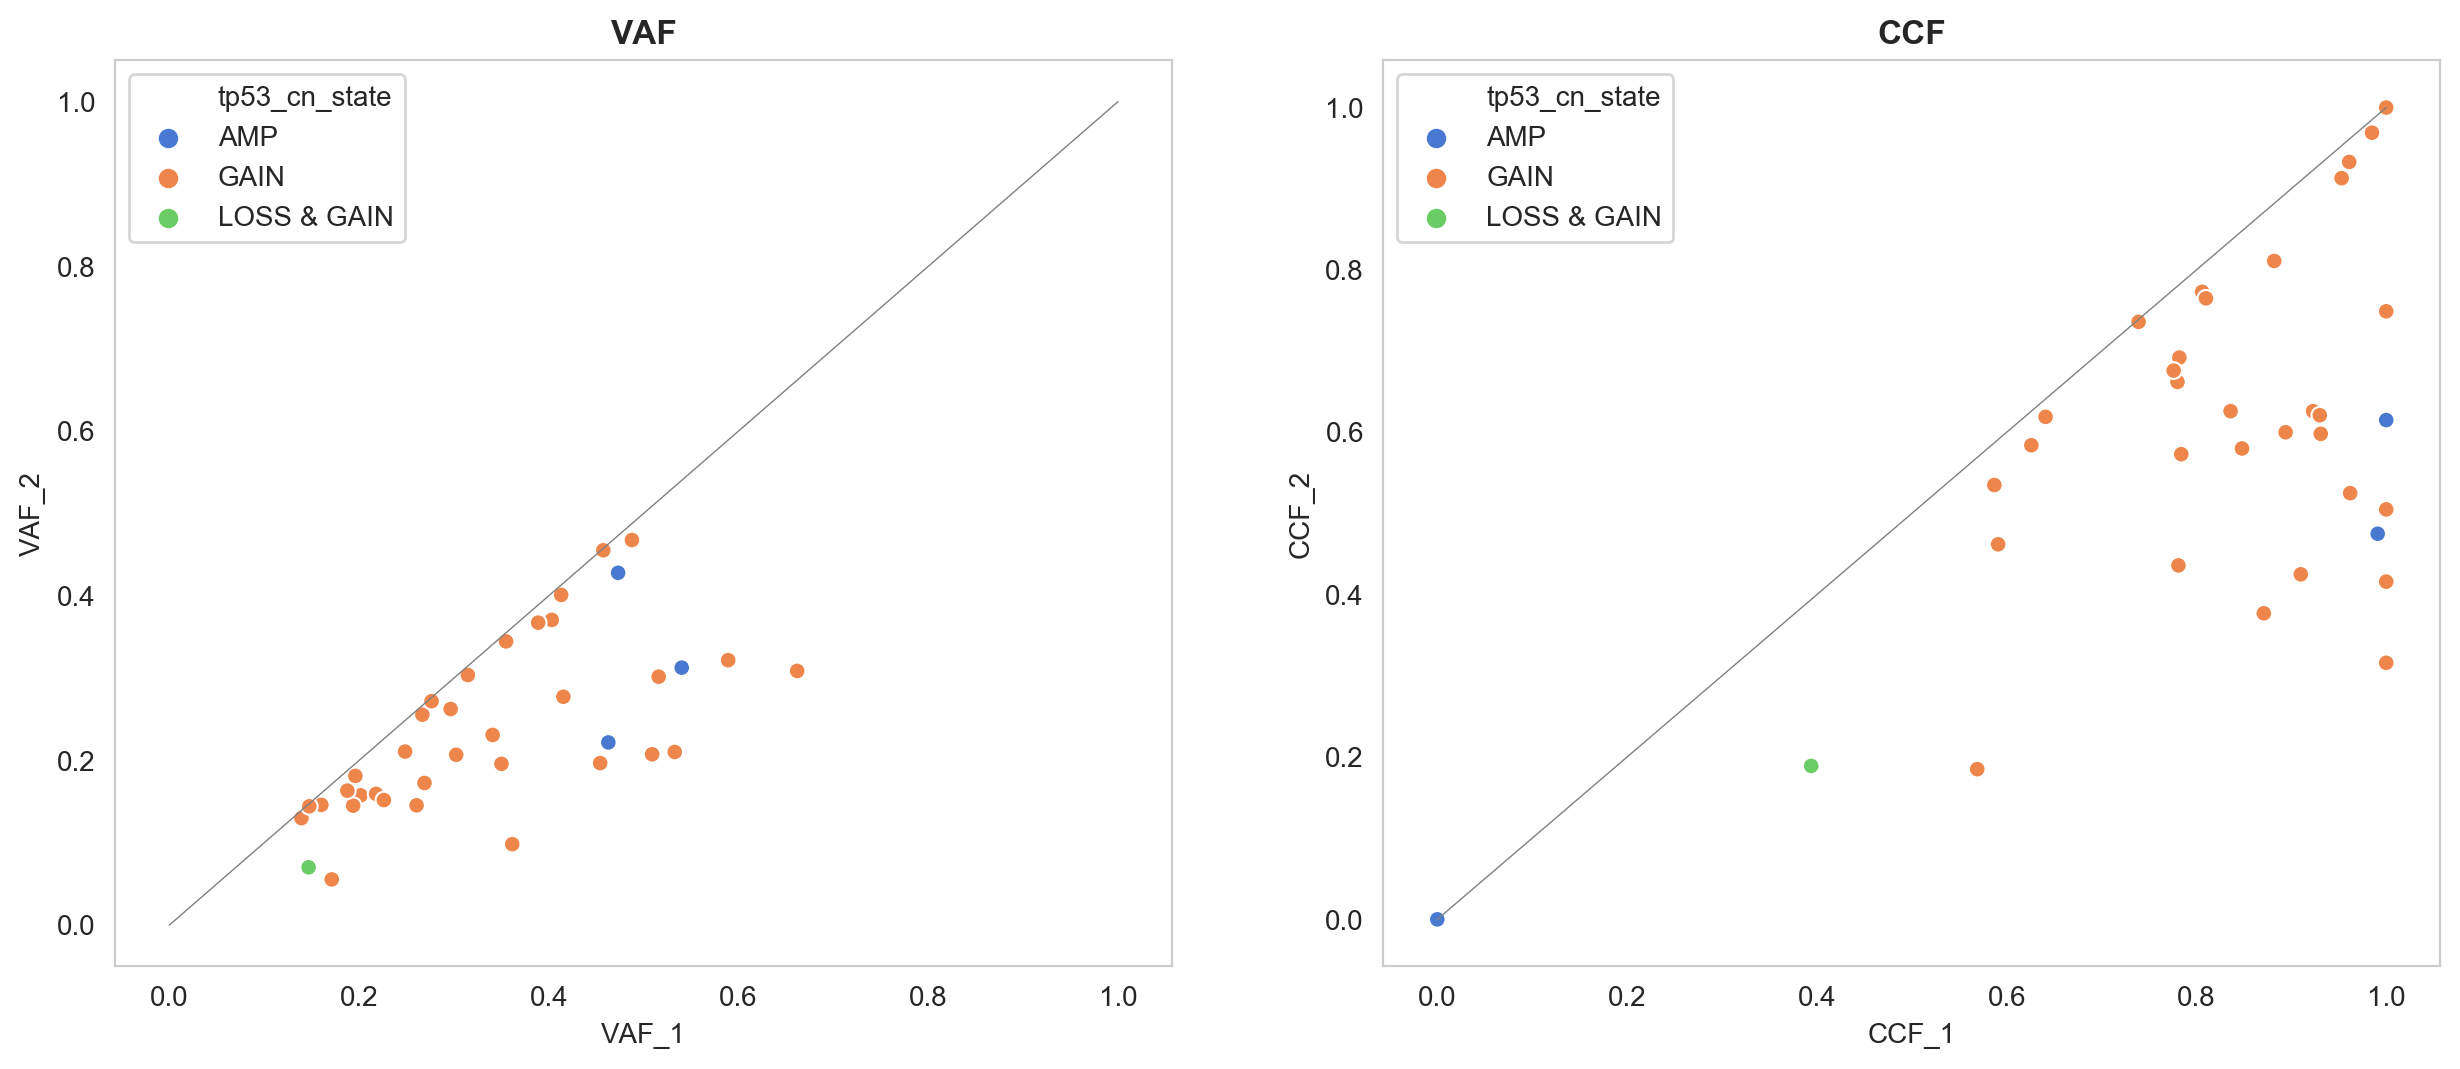

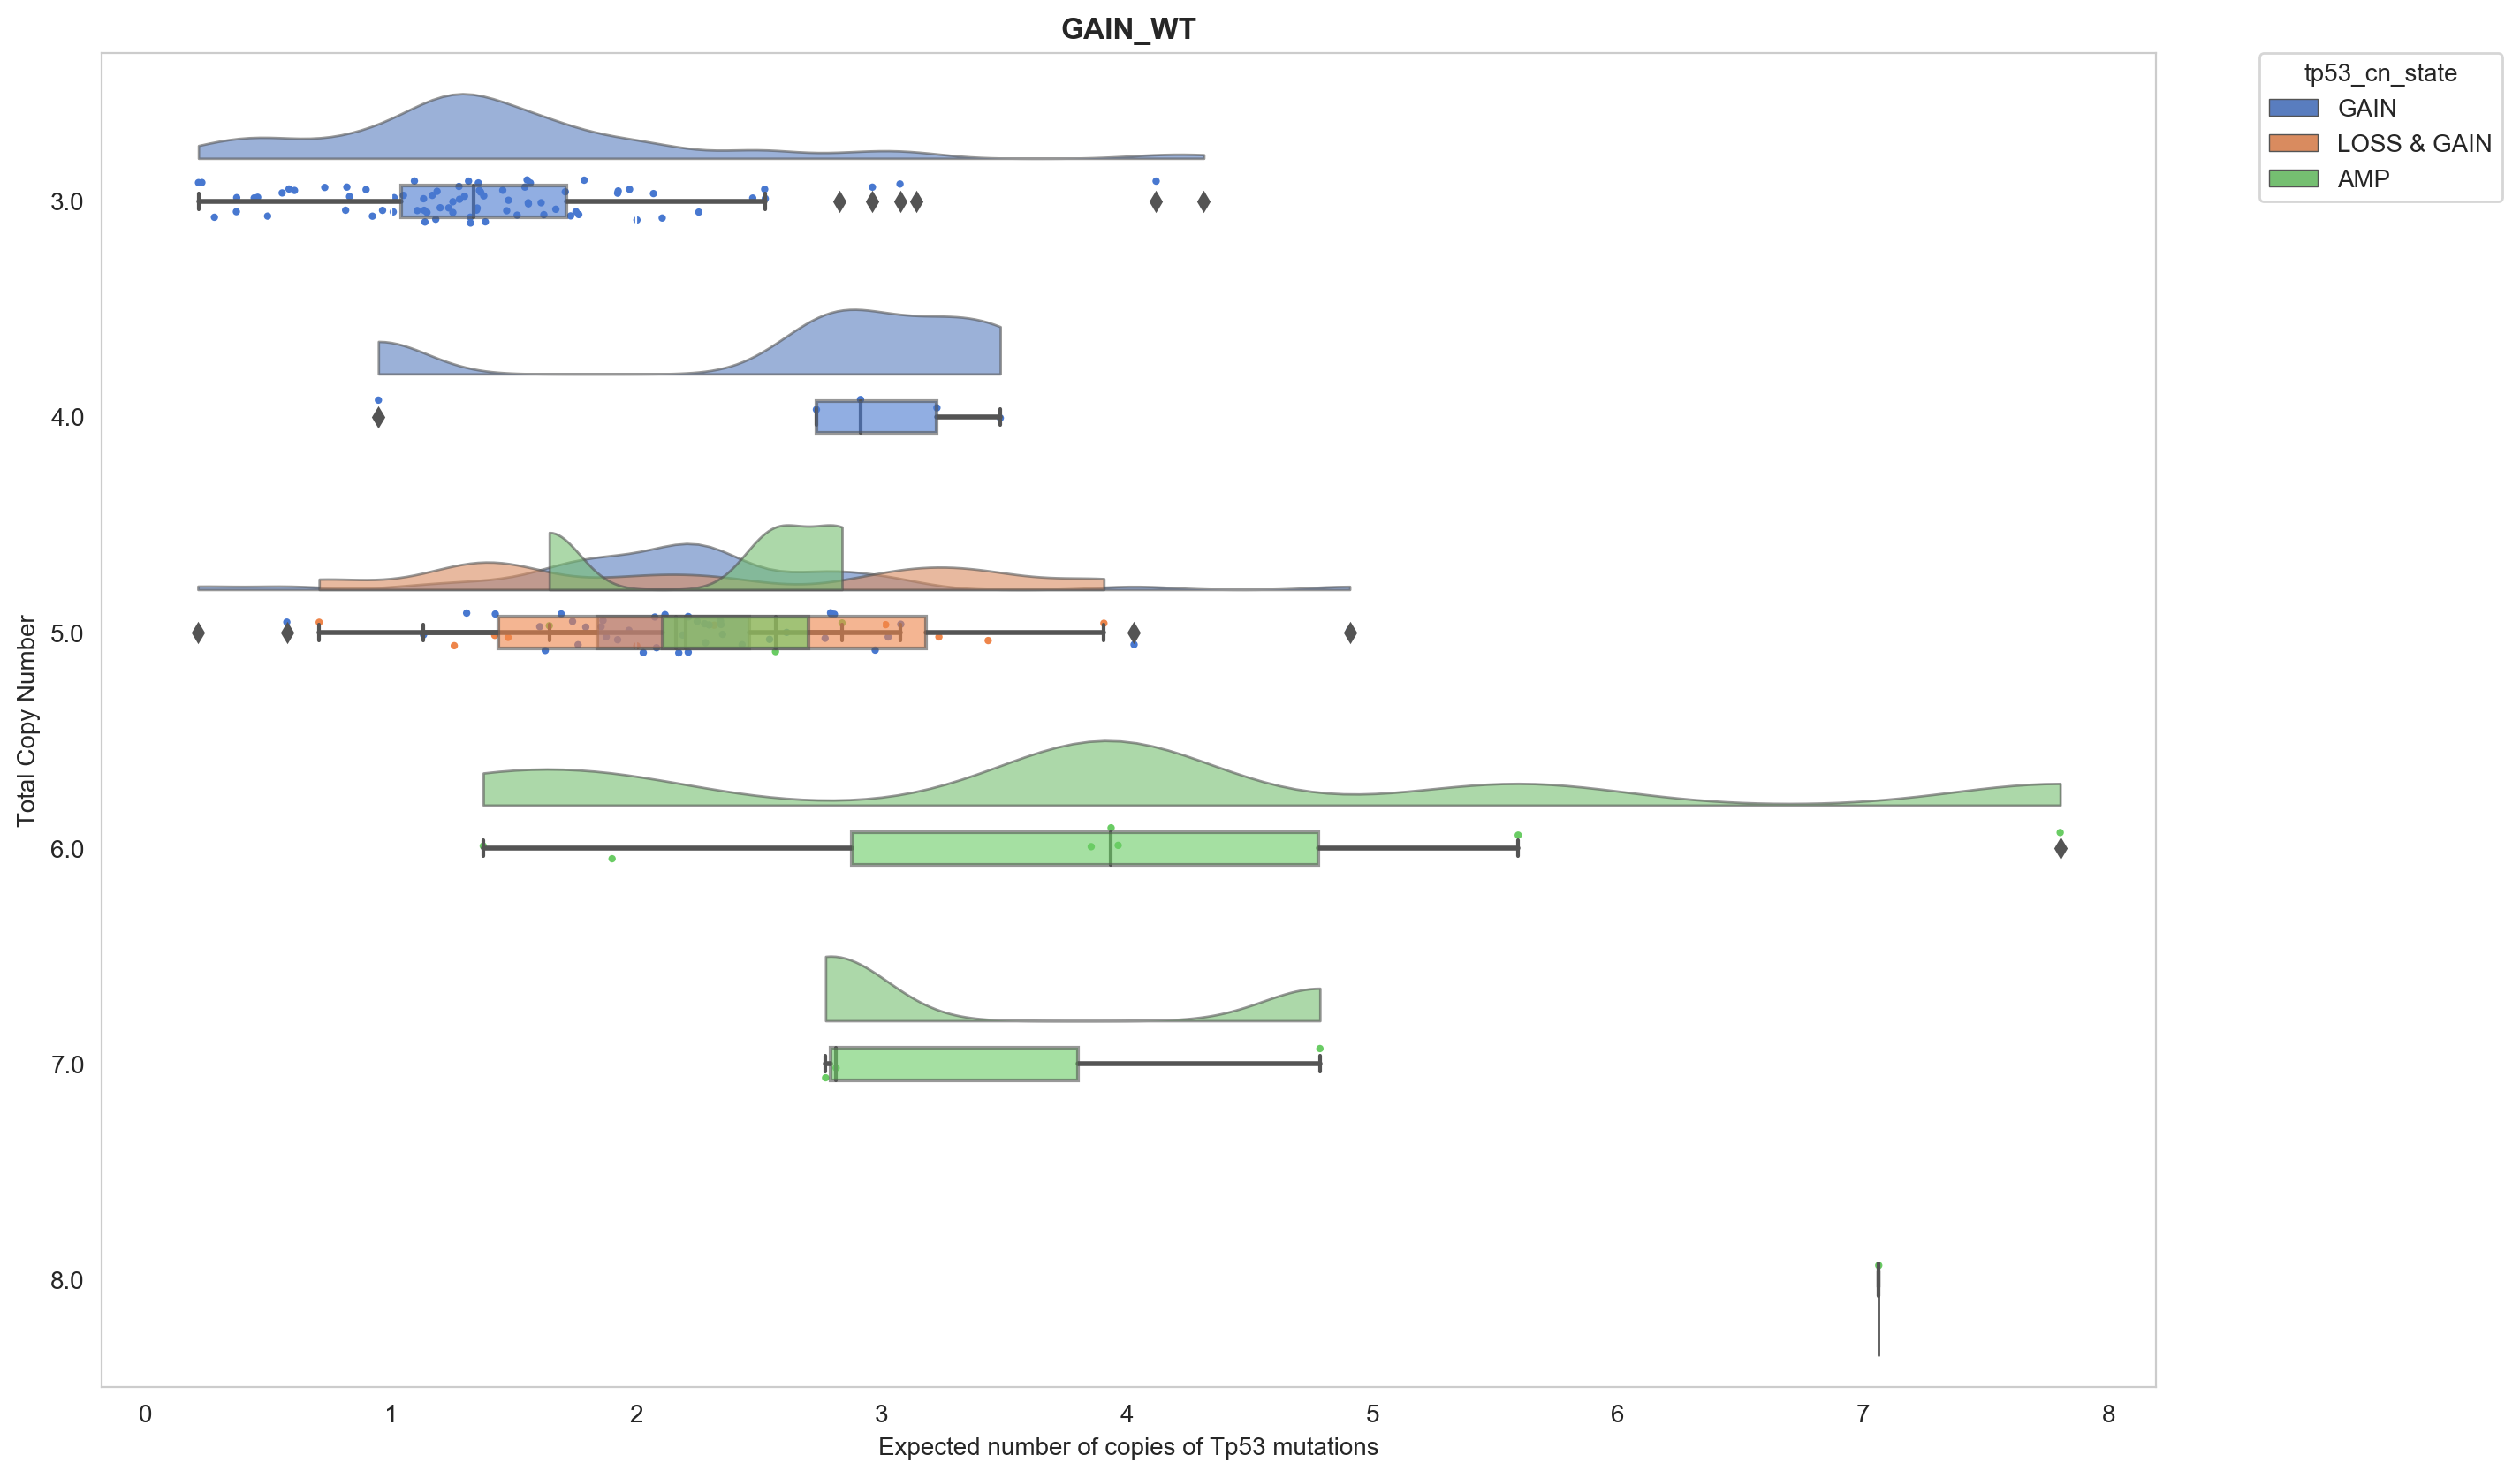

In [14]:
plot_summary(GAIN_WT,'GAIN_WT')

count 
 
 
 tp53_cn_state 
 
 
 
 
 
 CNLOH AFTER 
 29 
 
 
 DOUBLE LOSS AFTER 
 104 
 
 
 
 
 
 
 count 
 
 
 Cancer_Type 
 
 
 
 
 
 Colorectal Cancer 
 31 
 
 
 Non-Small Cell Lung Cancer 
 30 
 
 
 Bladder Cancer 
 11 
 
 
 Breast Cancer 
 10 
 
 
 Pancreatic Cancer 
 7 
 
 
 Esophagogastric Cancer 
 6 
 
 
 Cancer of Unknown Primary 
 5 
 
 
 Ovarian Cancer 
 5 
 
 
 Prostate Cancer 
 4 
 
 
 Melanoma 
 4 
 
 
 Head and Neck Cancer 
 3 
 
 
 Hepatobiliary Cancer 
 3 
 
 
 Gastrointestinal Neuroendocrine Tumor 
 2 
 
 
 Skin Cancer, Non-Melanoma 
 2 
 
 
 Bone Cancer 
 1 
 
 
 
 
 
 
 count 
 
 
 tp53_count 
 
 
 
 
 
 1 
 90 
 
 
 2 
 38 
 
 
 3 
 5

<Figure size 600x600 with 0 Axes>

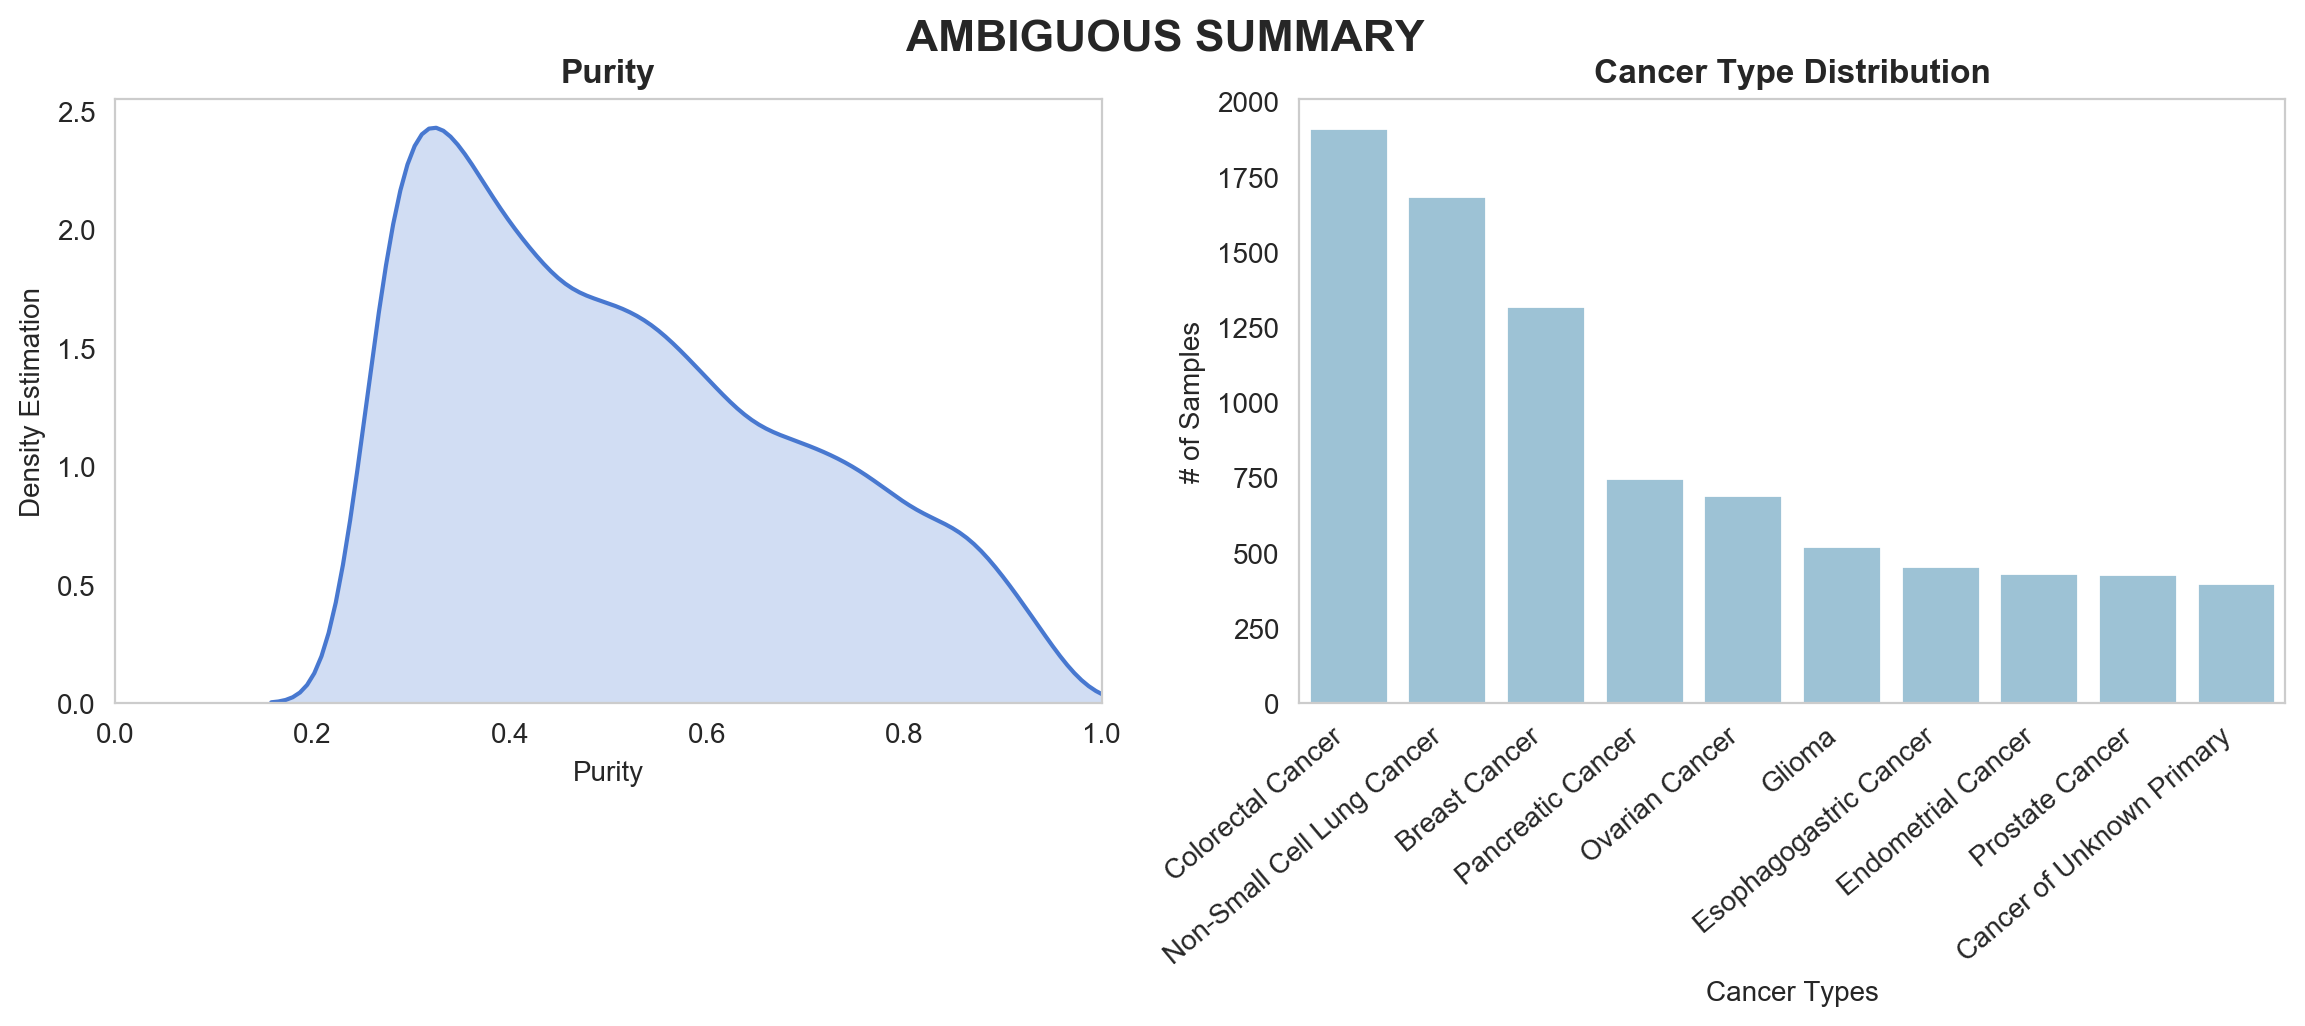

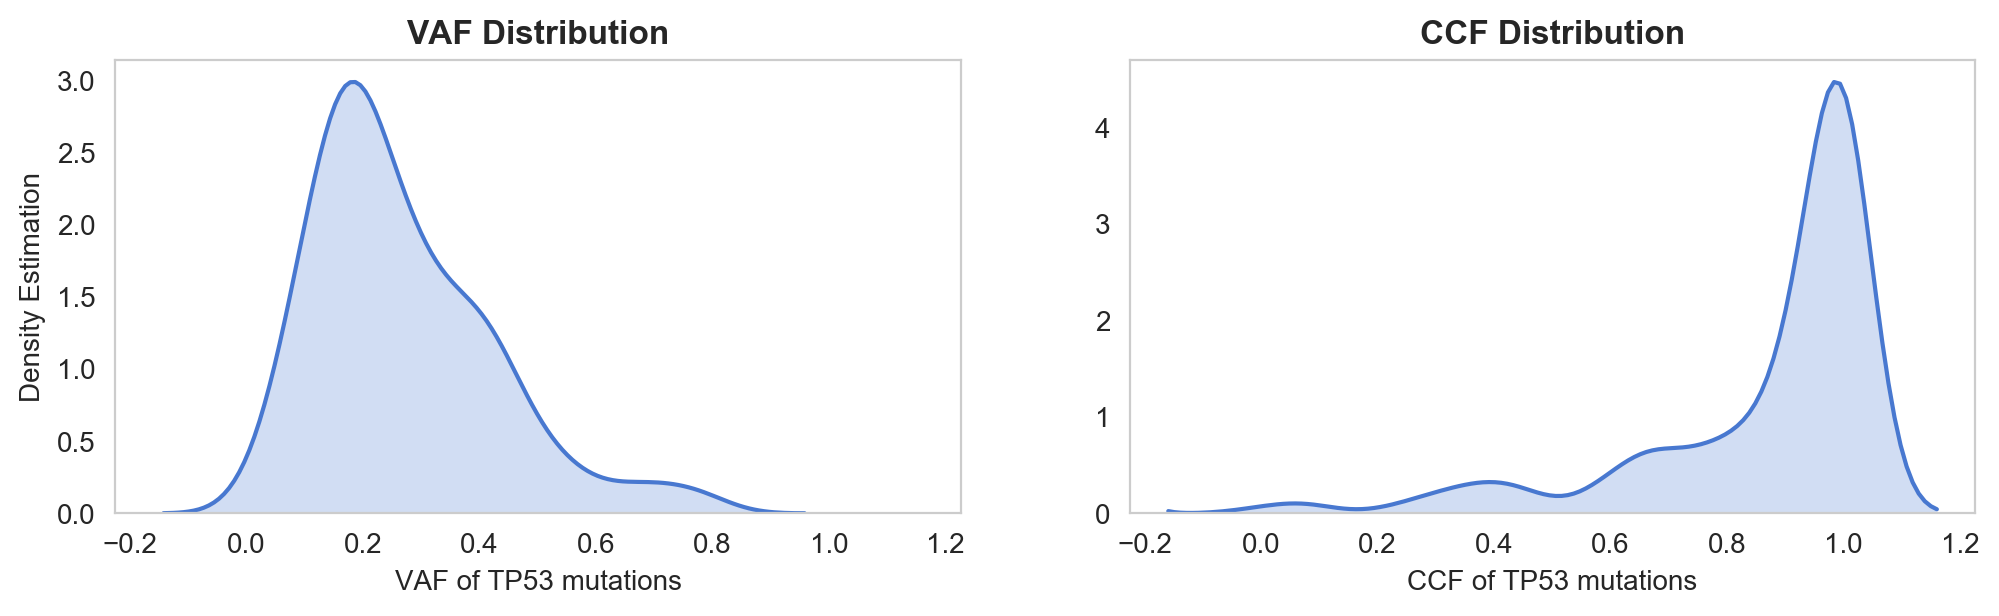

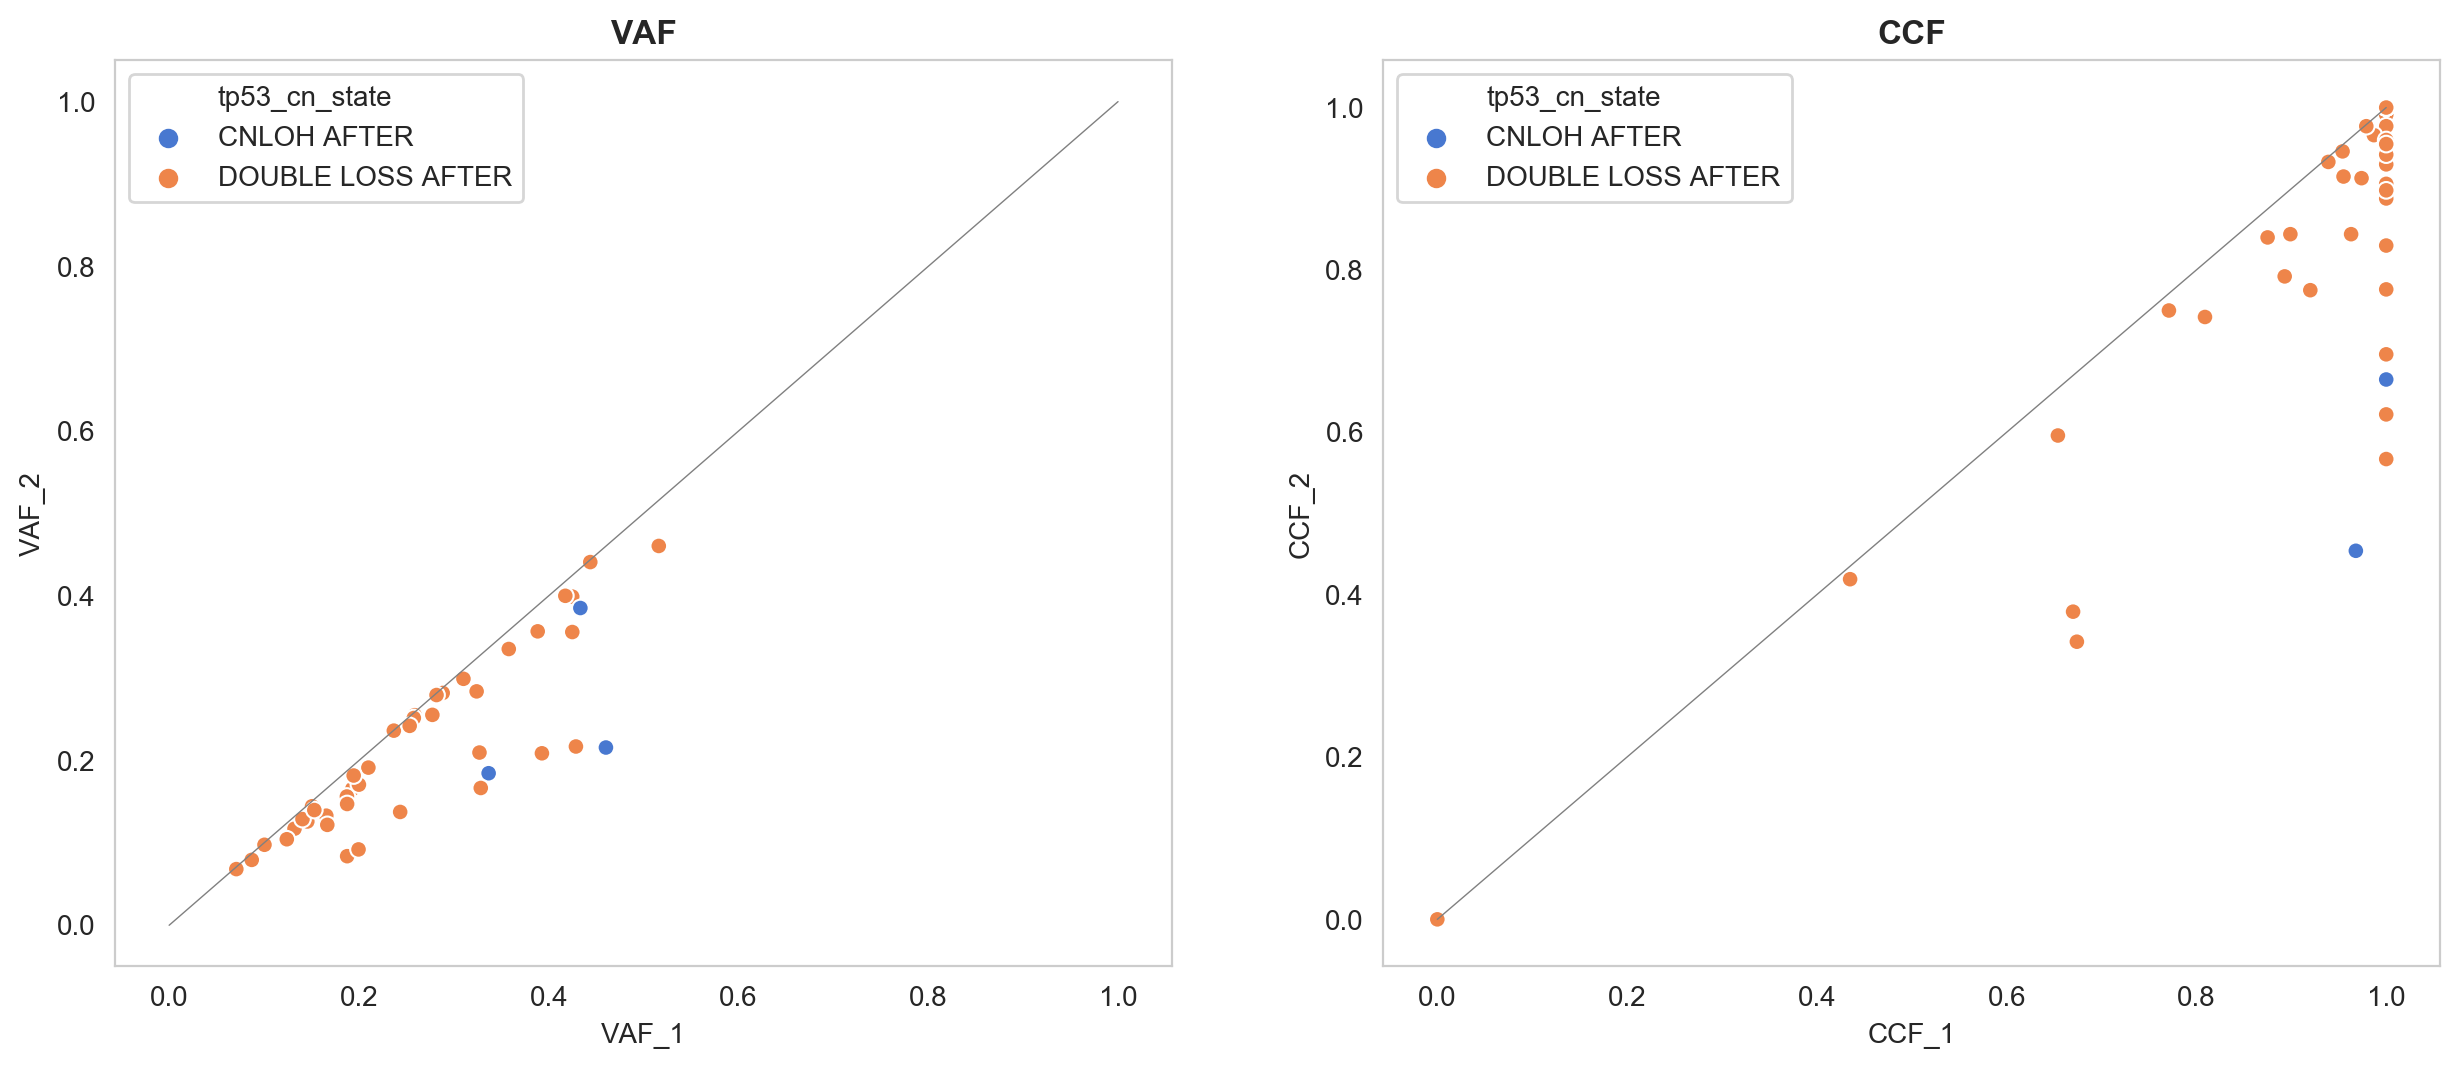

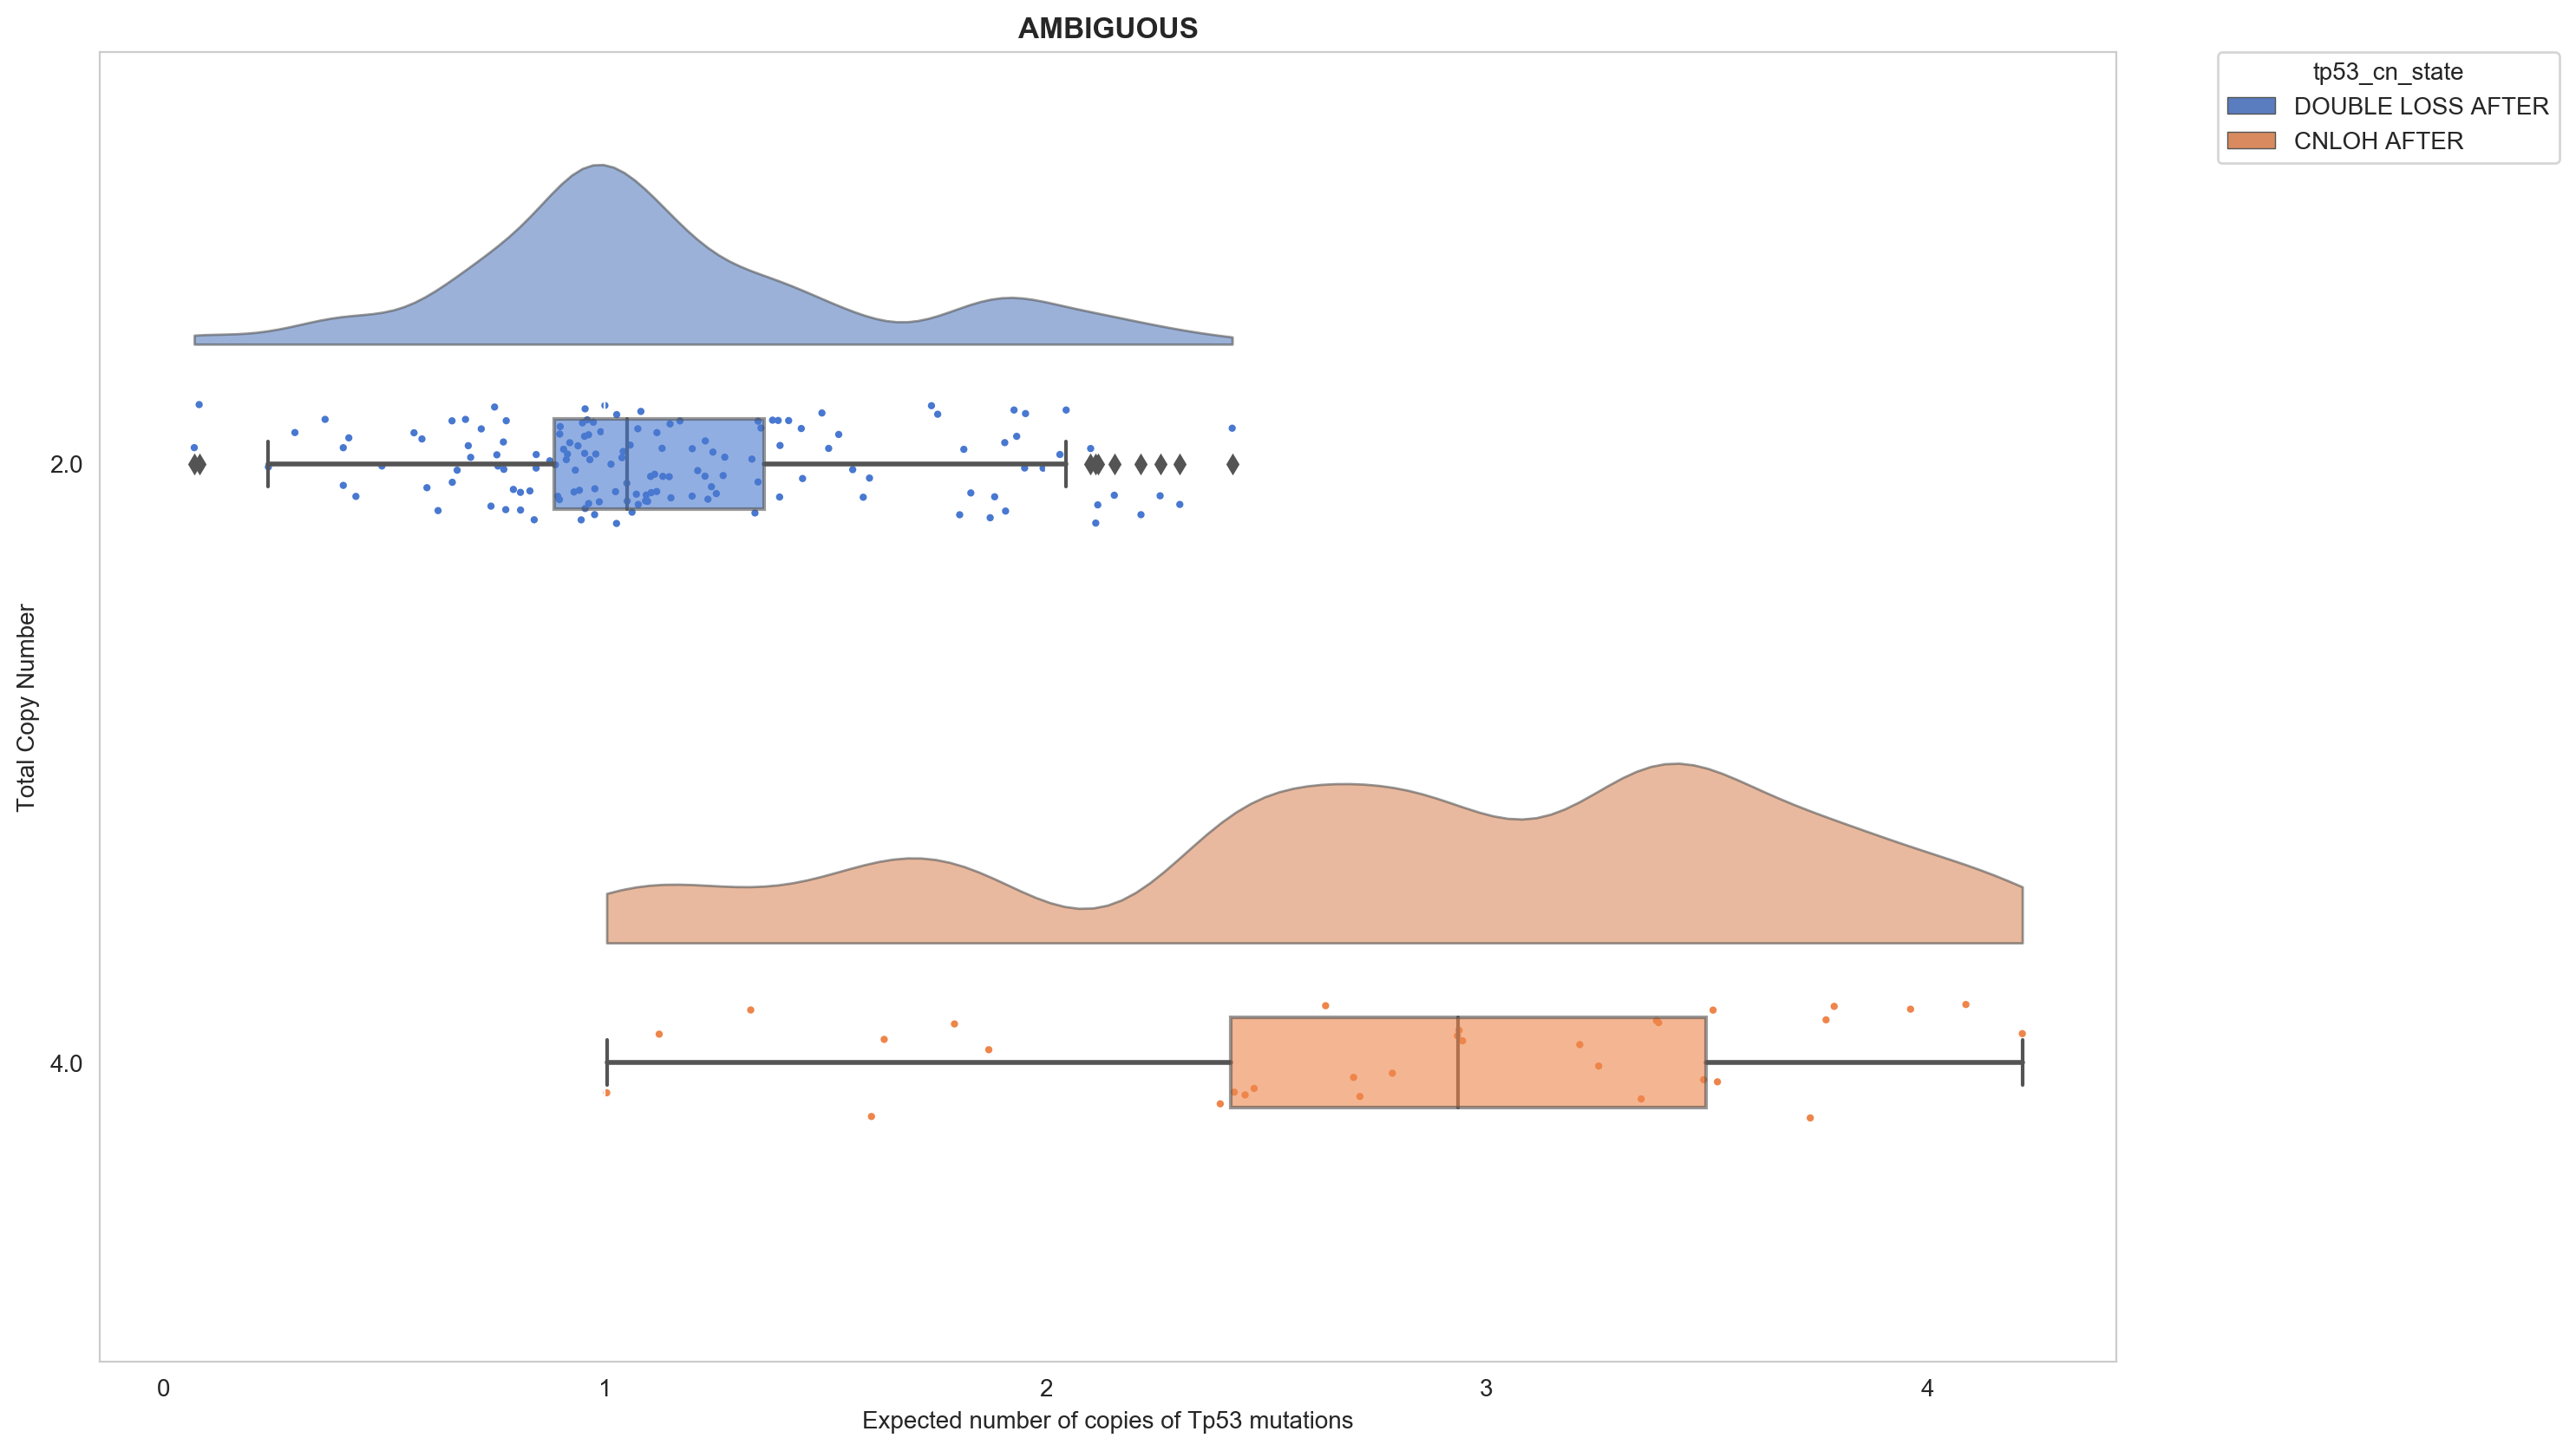

In [15]:
plot_summary(AMBIGUOUS,'AMBIGUOUS')

count 
 
 
 tp53_cn_state 
 
 
 
 
 
 AMP (BALANCED) 
 7 
 
 
 AMP (LOH) 
 6 
 
 
 HOMDEL 
 50 
 
 
 
 
 
 
 count 
 
 
 Cancer_Type 
 
 
 
 
 
 Non-Small Cell Lung Cancer 
 9 
 
 
 Colorectal Cancer 
 8 
 
 
 Breast Cancer 
 7 
 
 
 Prostate Cancer 
 7 
 
 
 Uterine Sarcoma 
 3 
 
 
 Glioma 
 3 
 
 
 Skin Cancer, Non-Melanoma 
 3 
 
 
 Ovarian Cancer 
 3 
 
 
 Bladder Cancer 
 2 
 
 
 Pancreatic Cancer 
 2 
 
 
 Soft Tissue Sarcoma 
 2 
 
 
 Mature B-Cell Neoplasms 
 2 
 
 
 Thyroid Cancer 
 1 
 
 
 Small Cell Lung Cancer 
 1 
 
 
 Small Bowel Cancer 
 1 
 
 
 
 
 
 
 count 
 
 
 tp53_count 
 
 
 
 
 
 1 
 50 
 
 
 2 
 13

<Figure size 600x600 with 0 Axes>

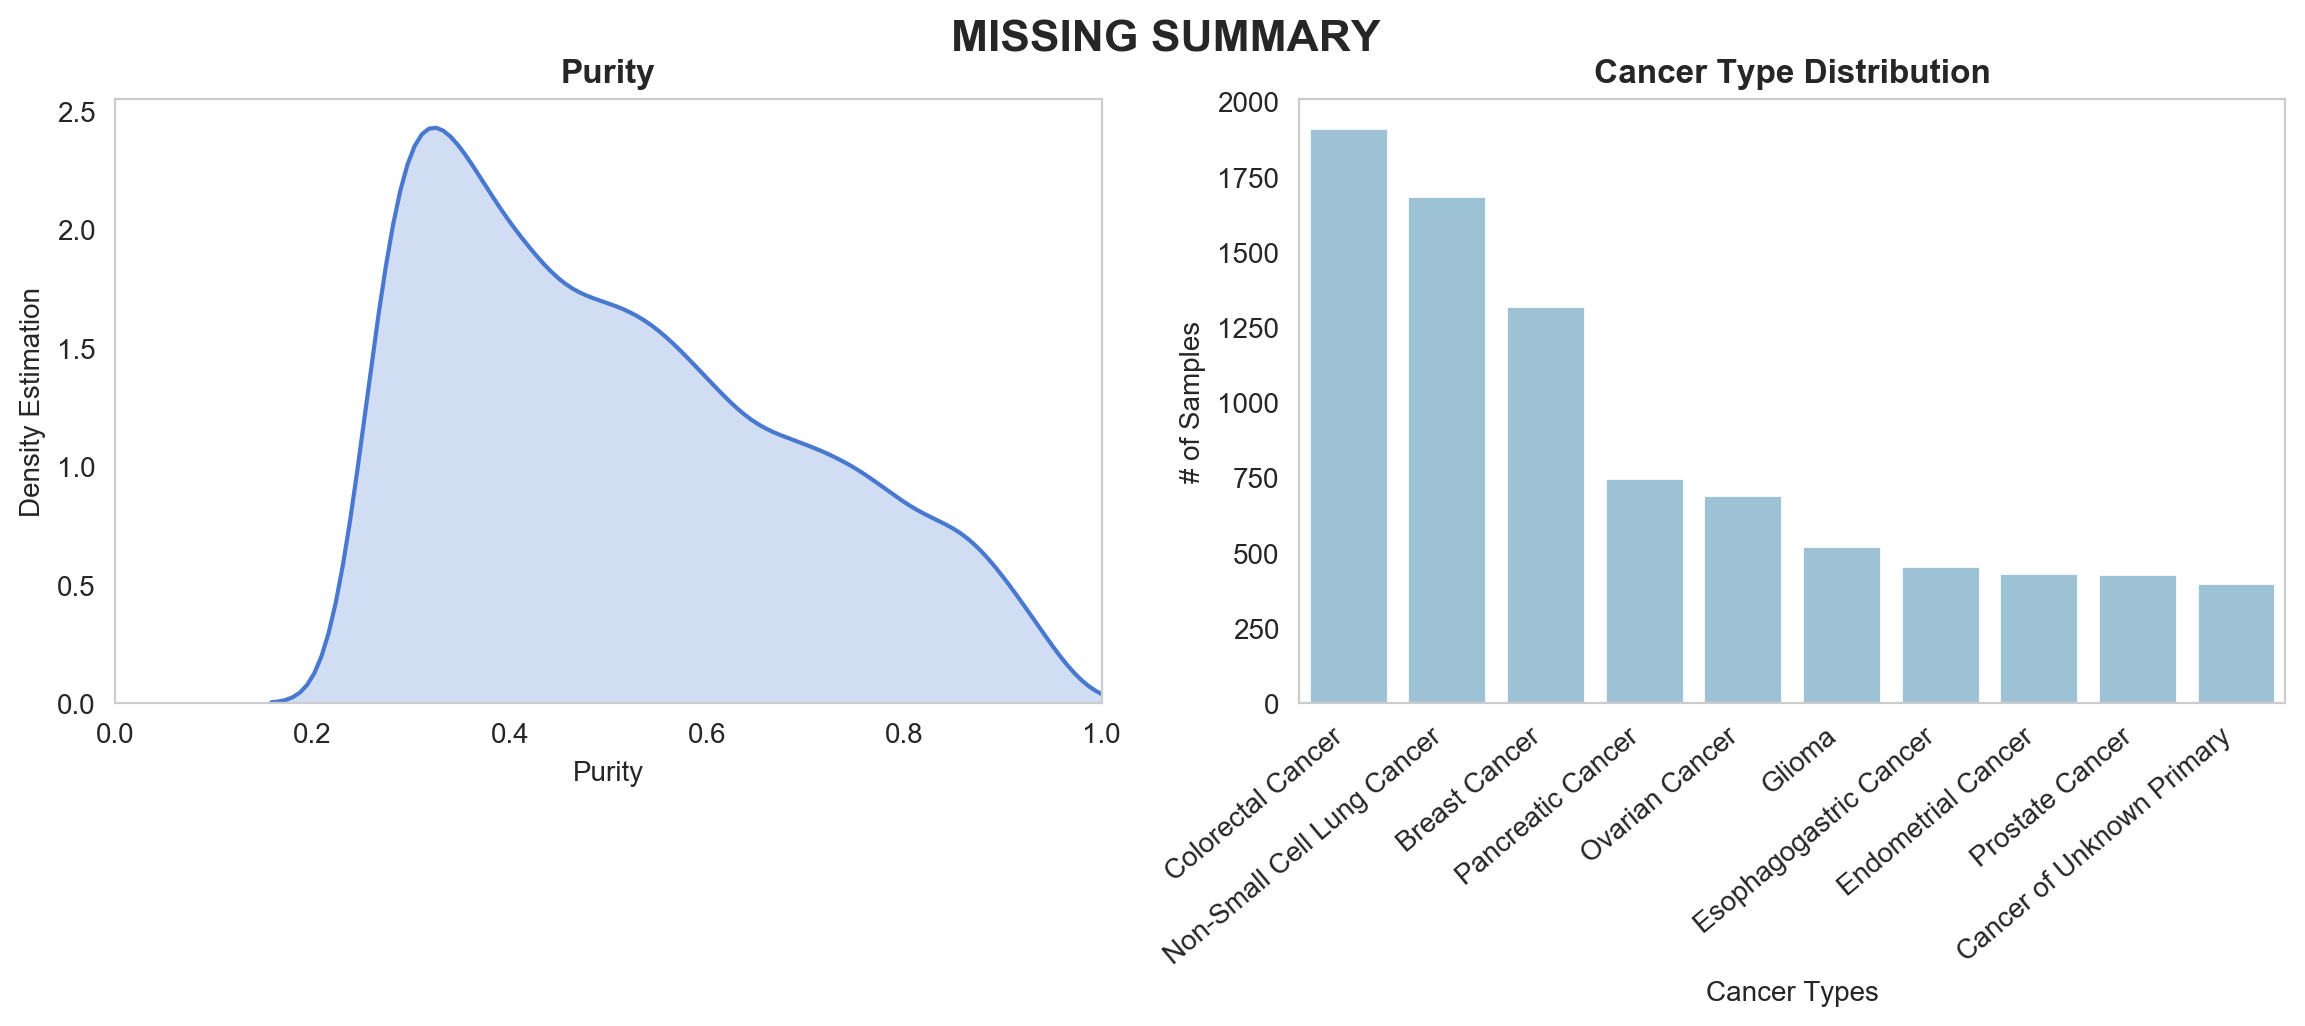

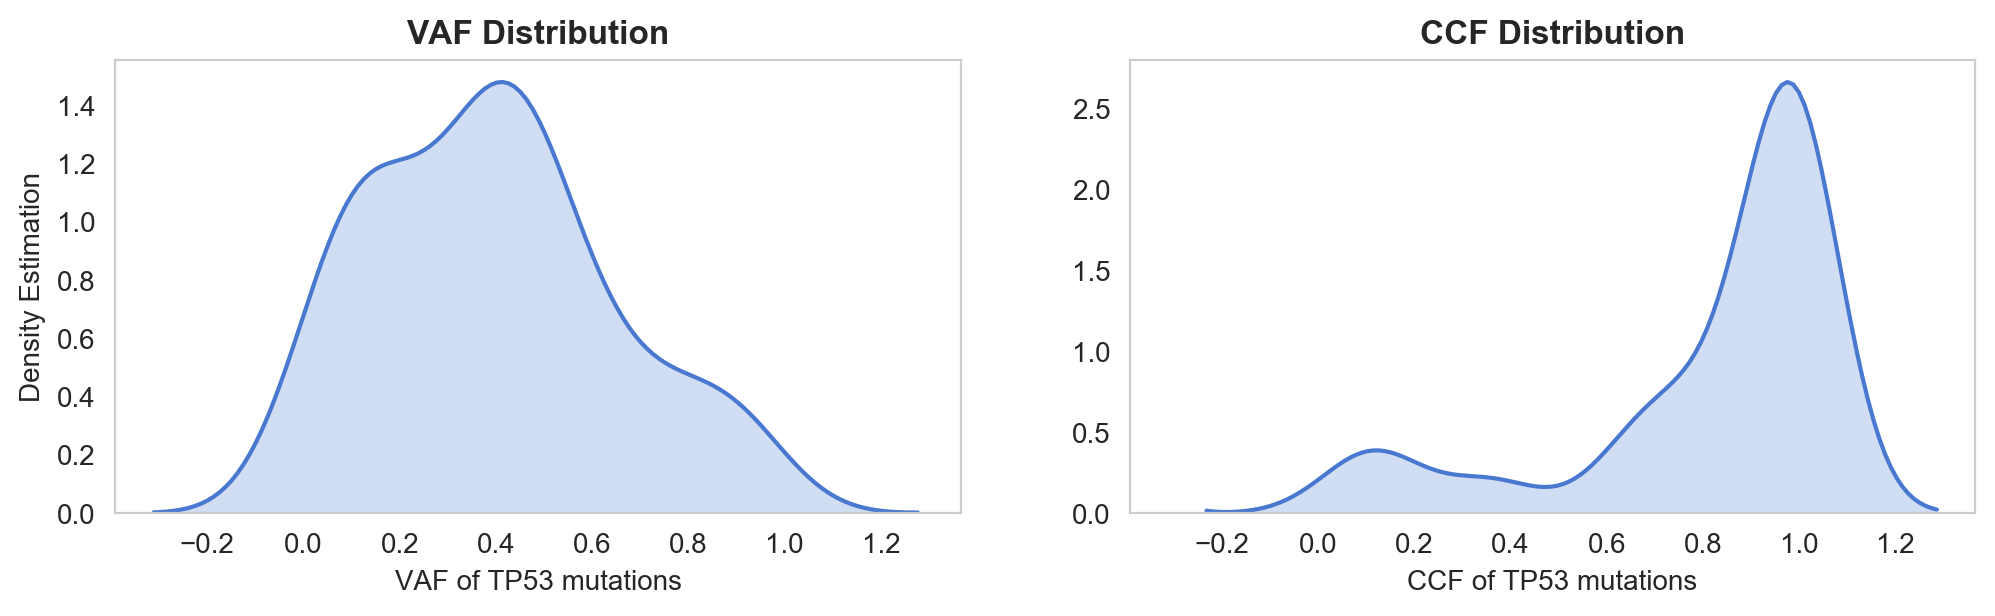

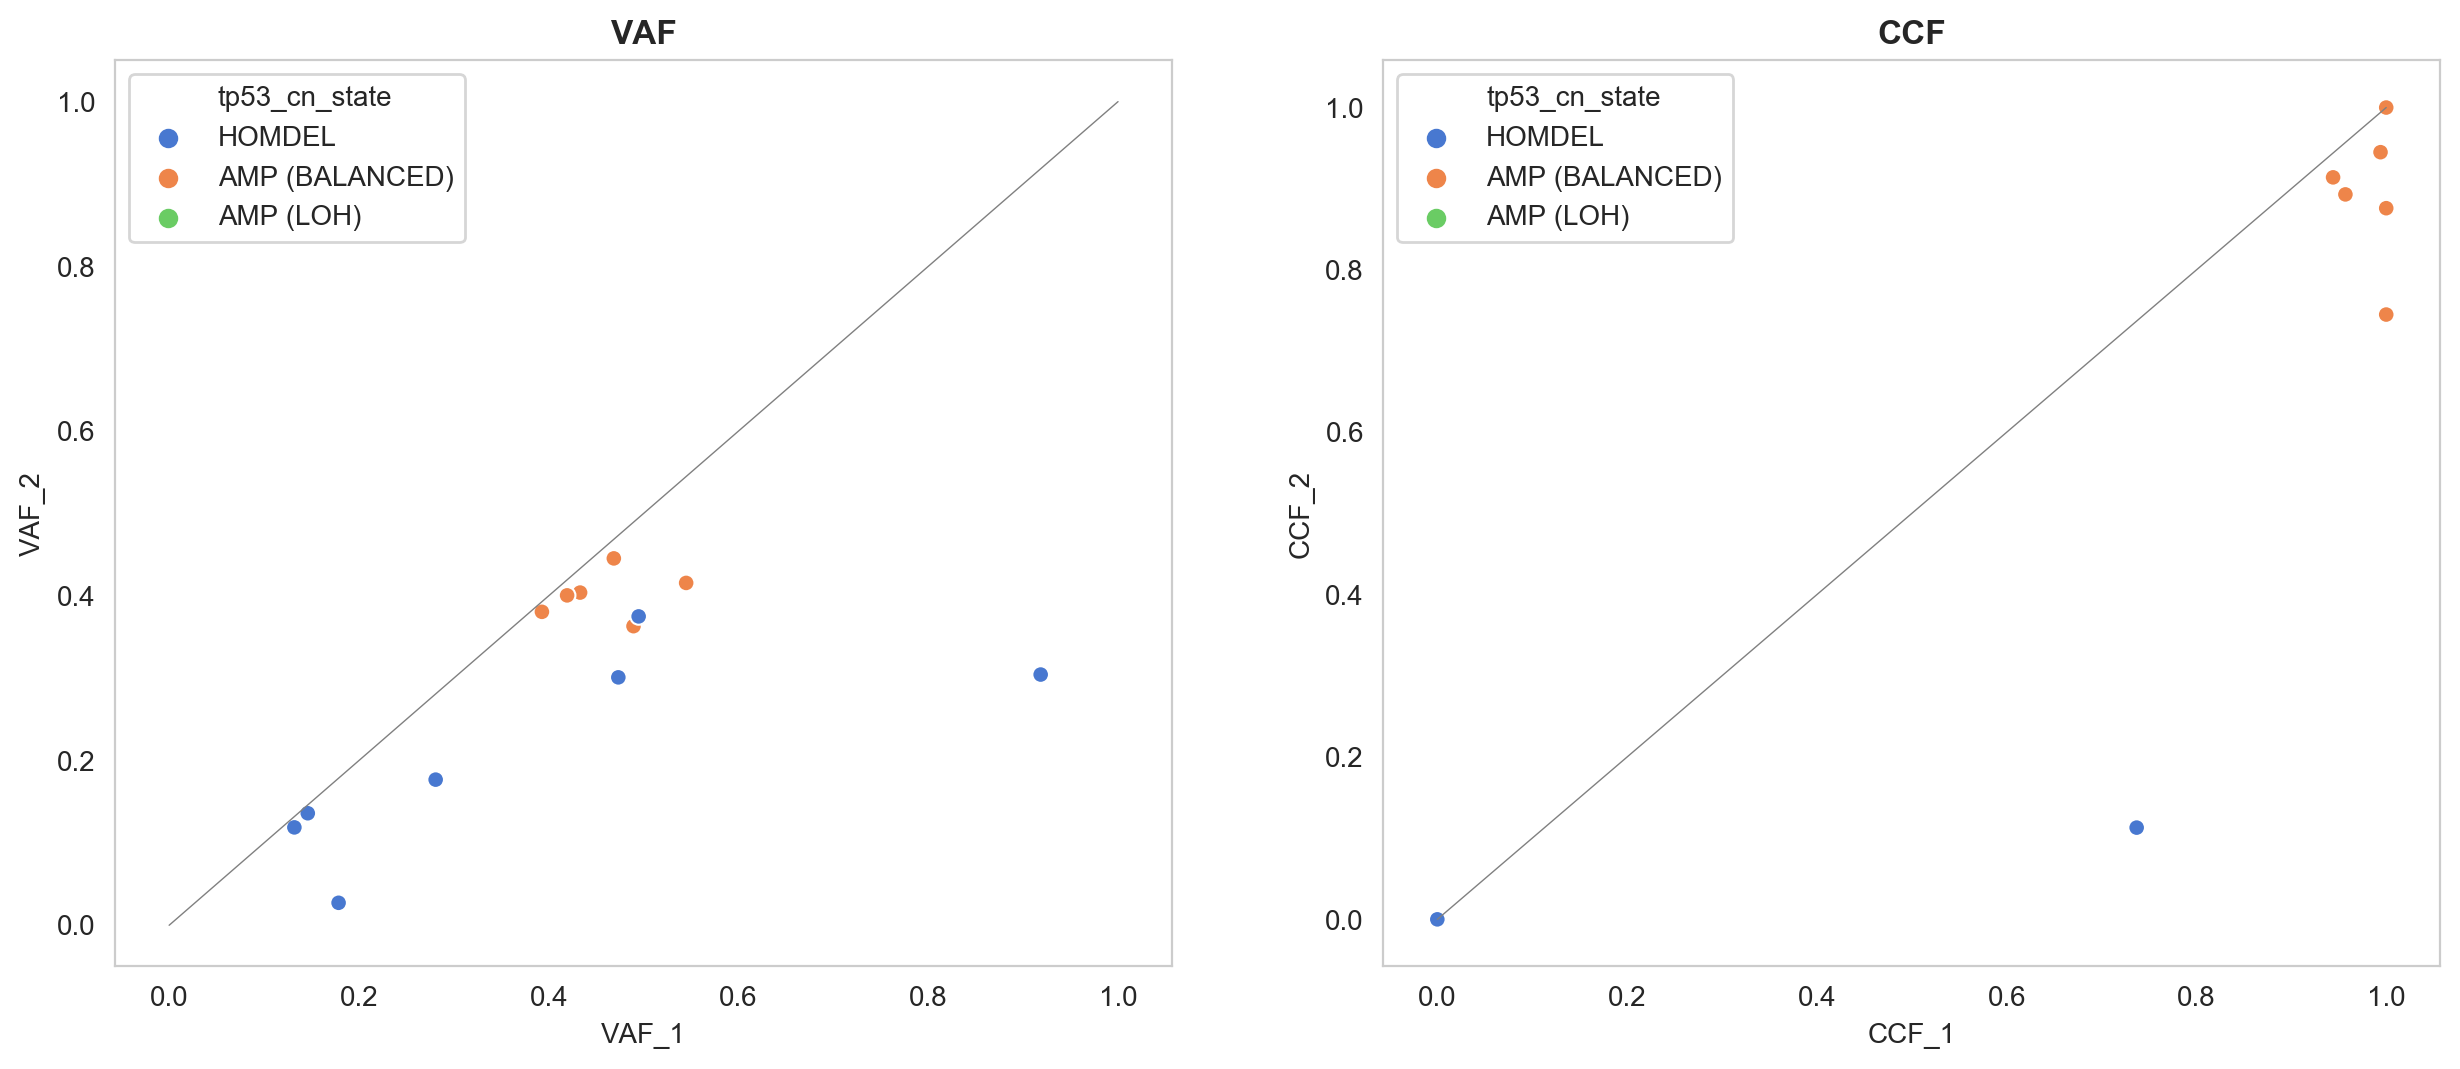

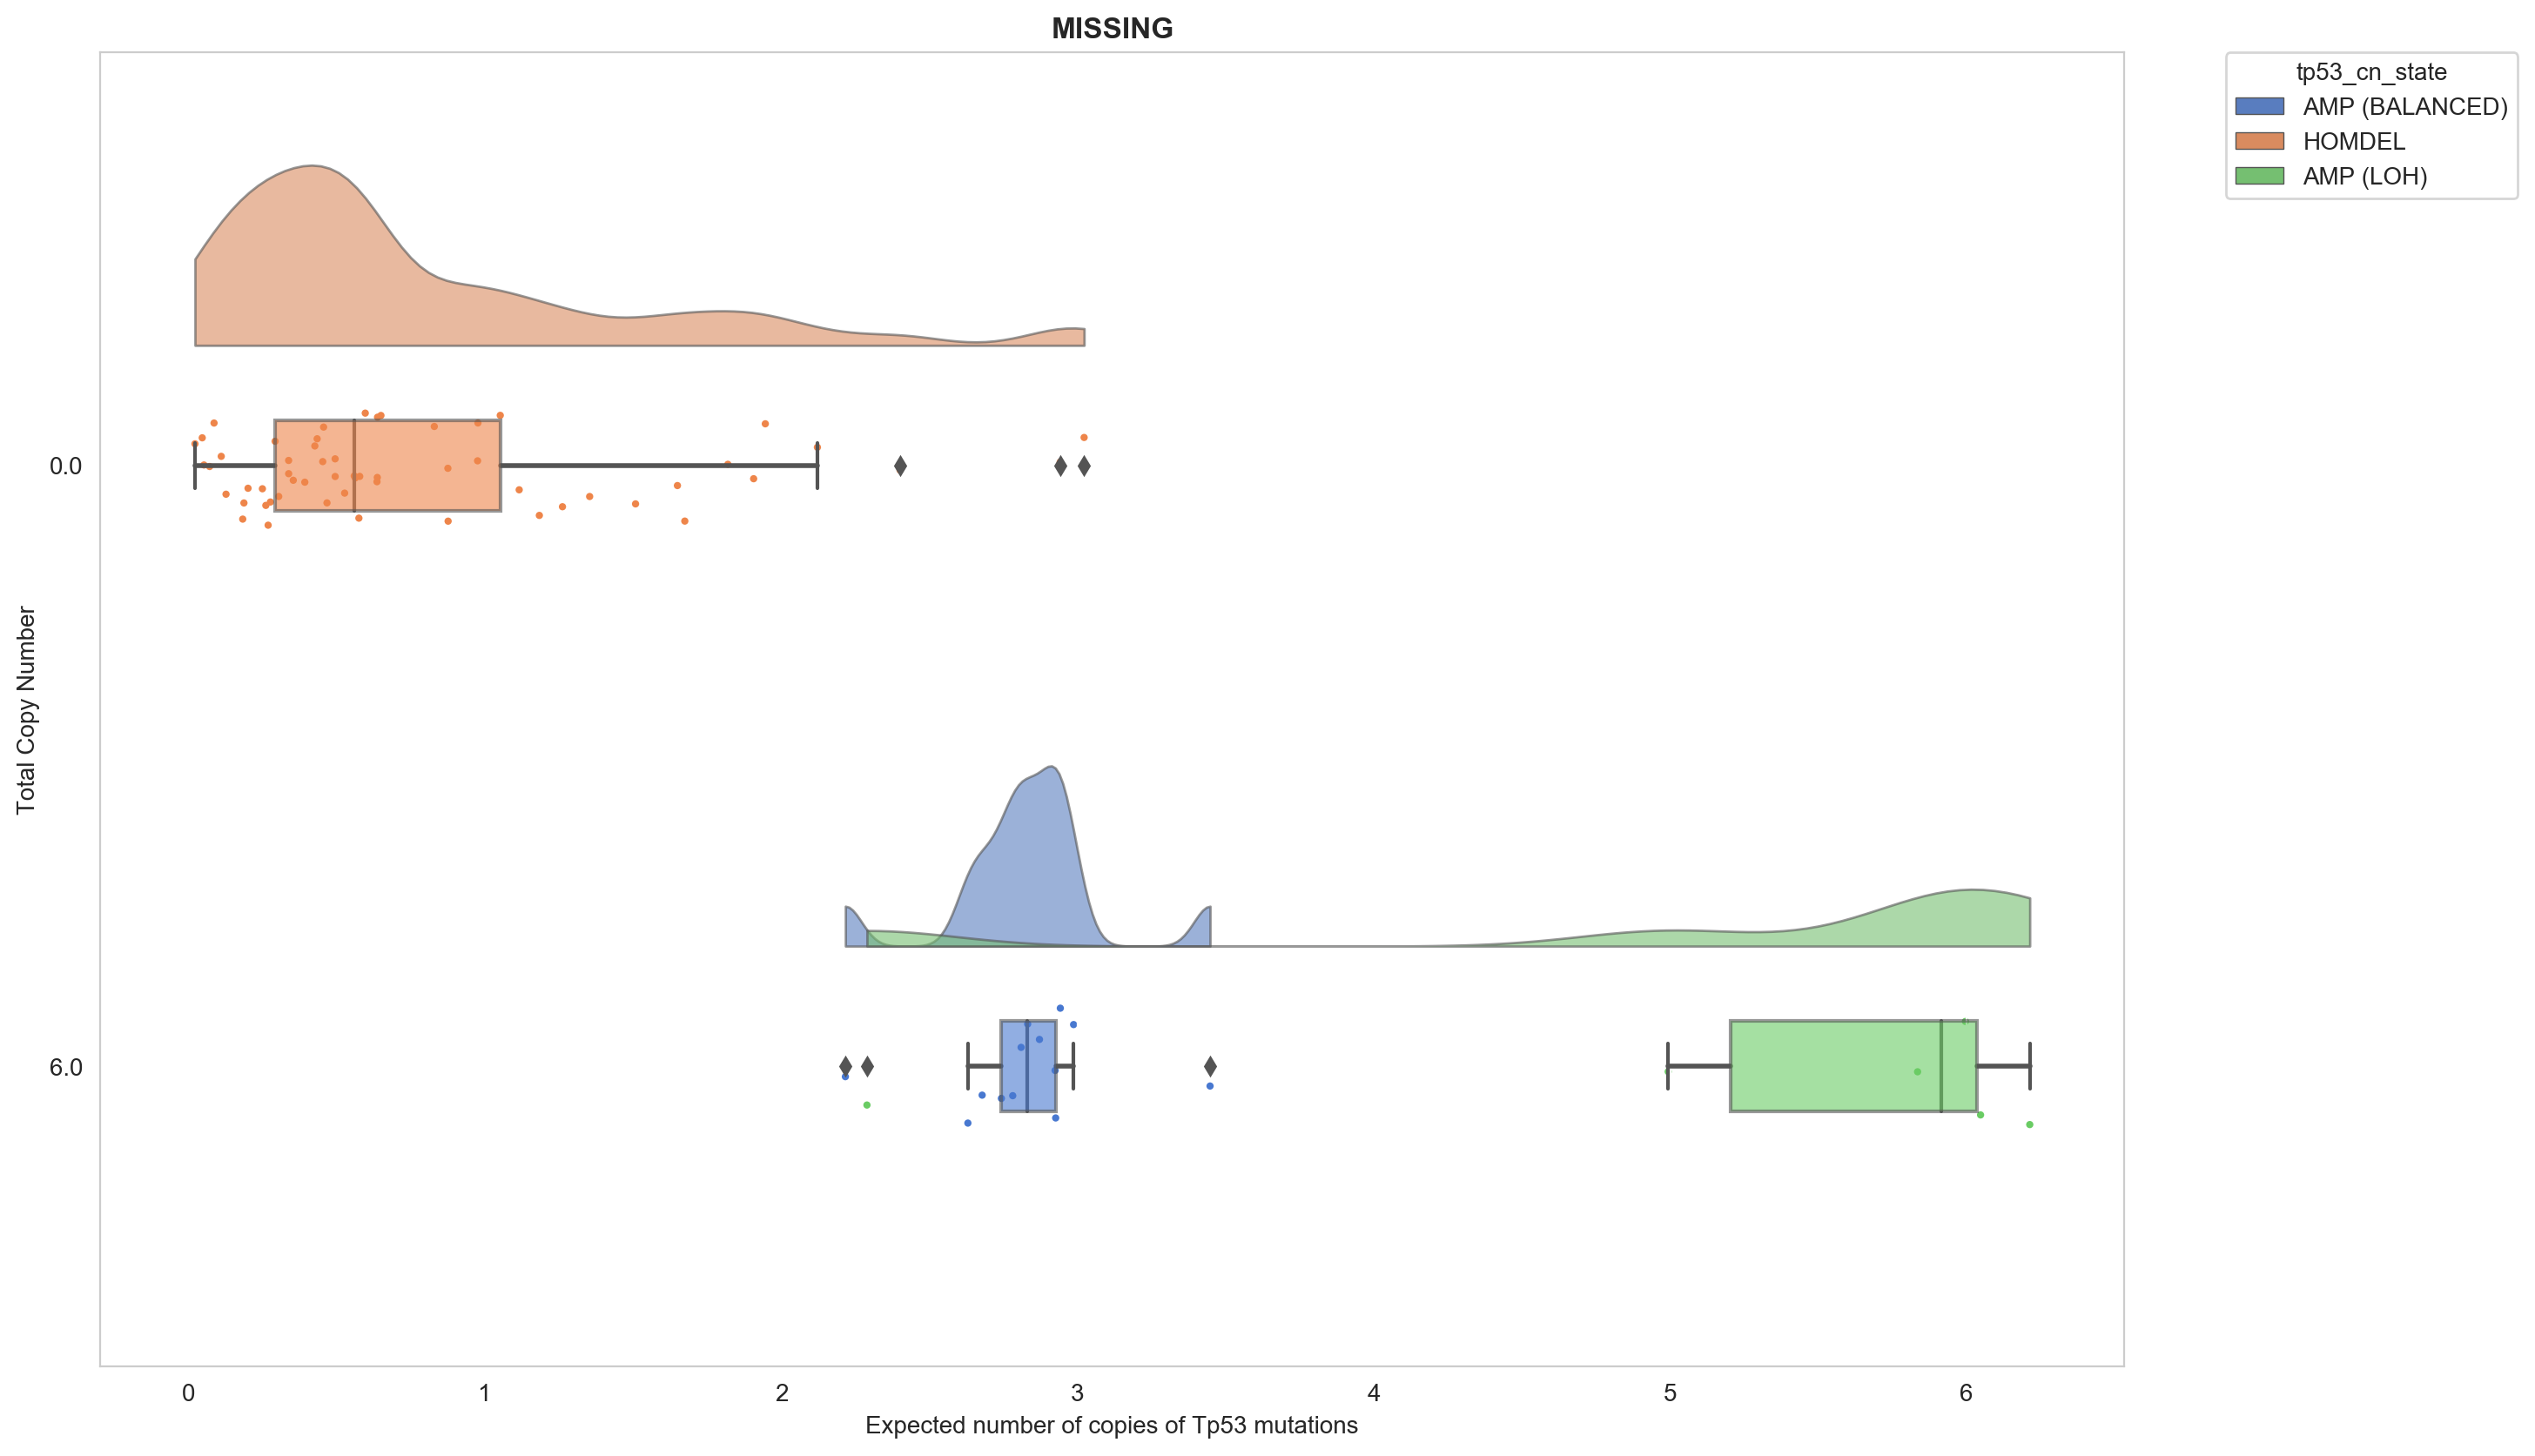

In [16]:
plot_summary(MISSING,'MISSING')

count 
 
 
 tp53_cn_state 
 
 
 
 
 
 INDETERMINATE 
 1082 
 
 
 
 
 
 
 count 
 
 
 Cancer_Type 
 
 
 
 
 
 Non-Small Cell Lung Cancer 
 183 
 
 
 Breast Cancer 
 130 
 
 
 Colorectal Cancer 
 126 
 
 
 Ovarian Cancer 
 103 
 
 
 Glioma 
 64 
 
 
 Pancreatic Cancer 
 56 
 
 
 Endometrial Cancer 
 56 
 
 
 Esophagogastric Cancer 
 47 
 
 
 Prostate Cancer 
 45 
 
 
 Soft Tissue Sarcoma 
 38 
 
 
 Cancer of Unknown Primary 
 37 
 
 
 Bladder Cancer 
 34 
 
 
 Small Cell Lung Cancer 
 23 
 
 
 Head and Neck Cancer 
 20 
 
 
 Skin Cancer, Non-Melanoma 
 18 
 
 
 
 
 
 
 count 
 
 
 tp53_count 
 
 
 
 
 
 1 
 1035 
 
 
 2 
 42 
 
 
 3 
 5

<Figure size 600x600 with 0 Axes>

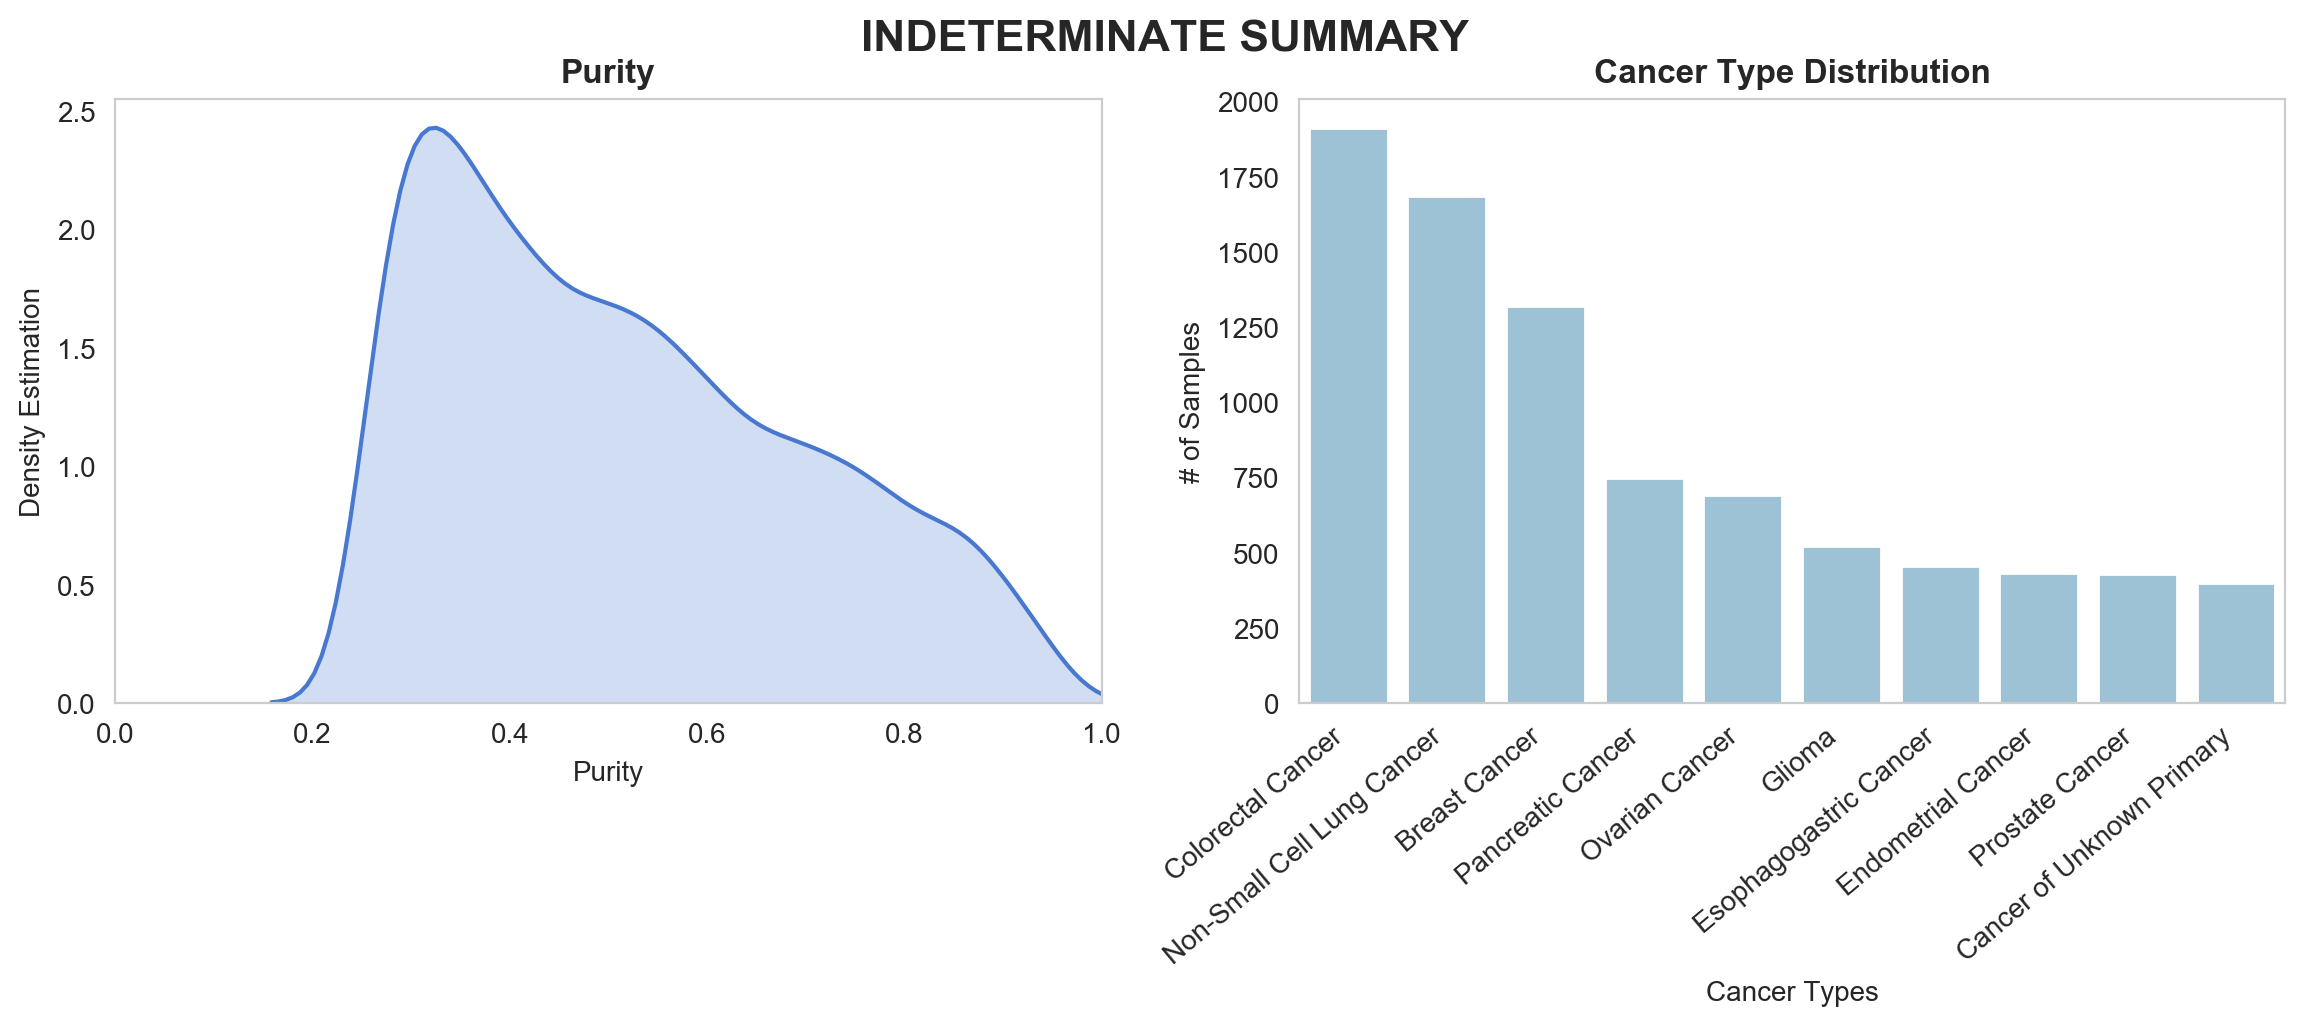

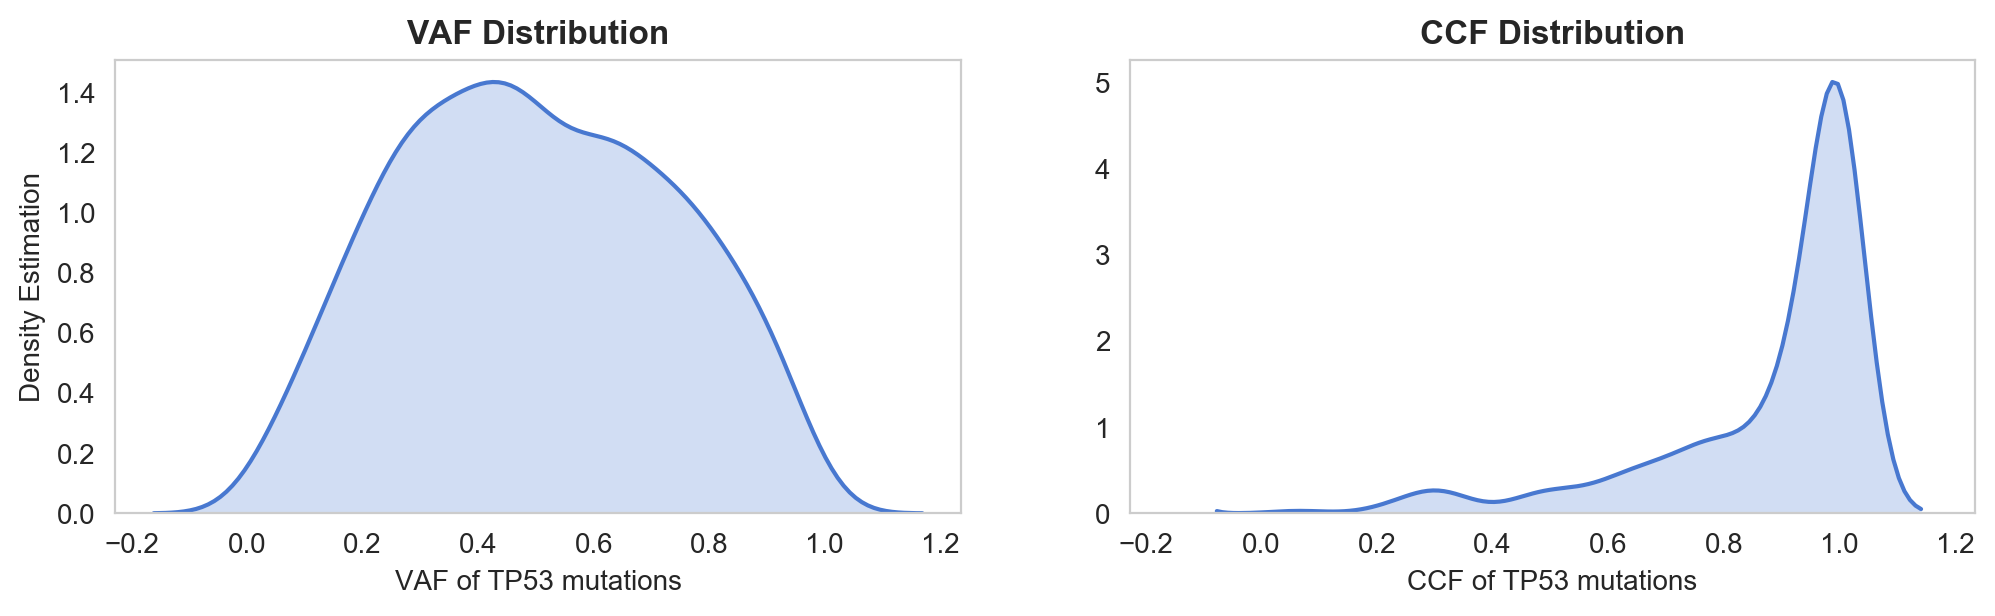

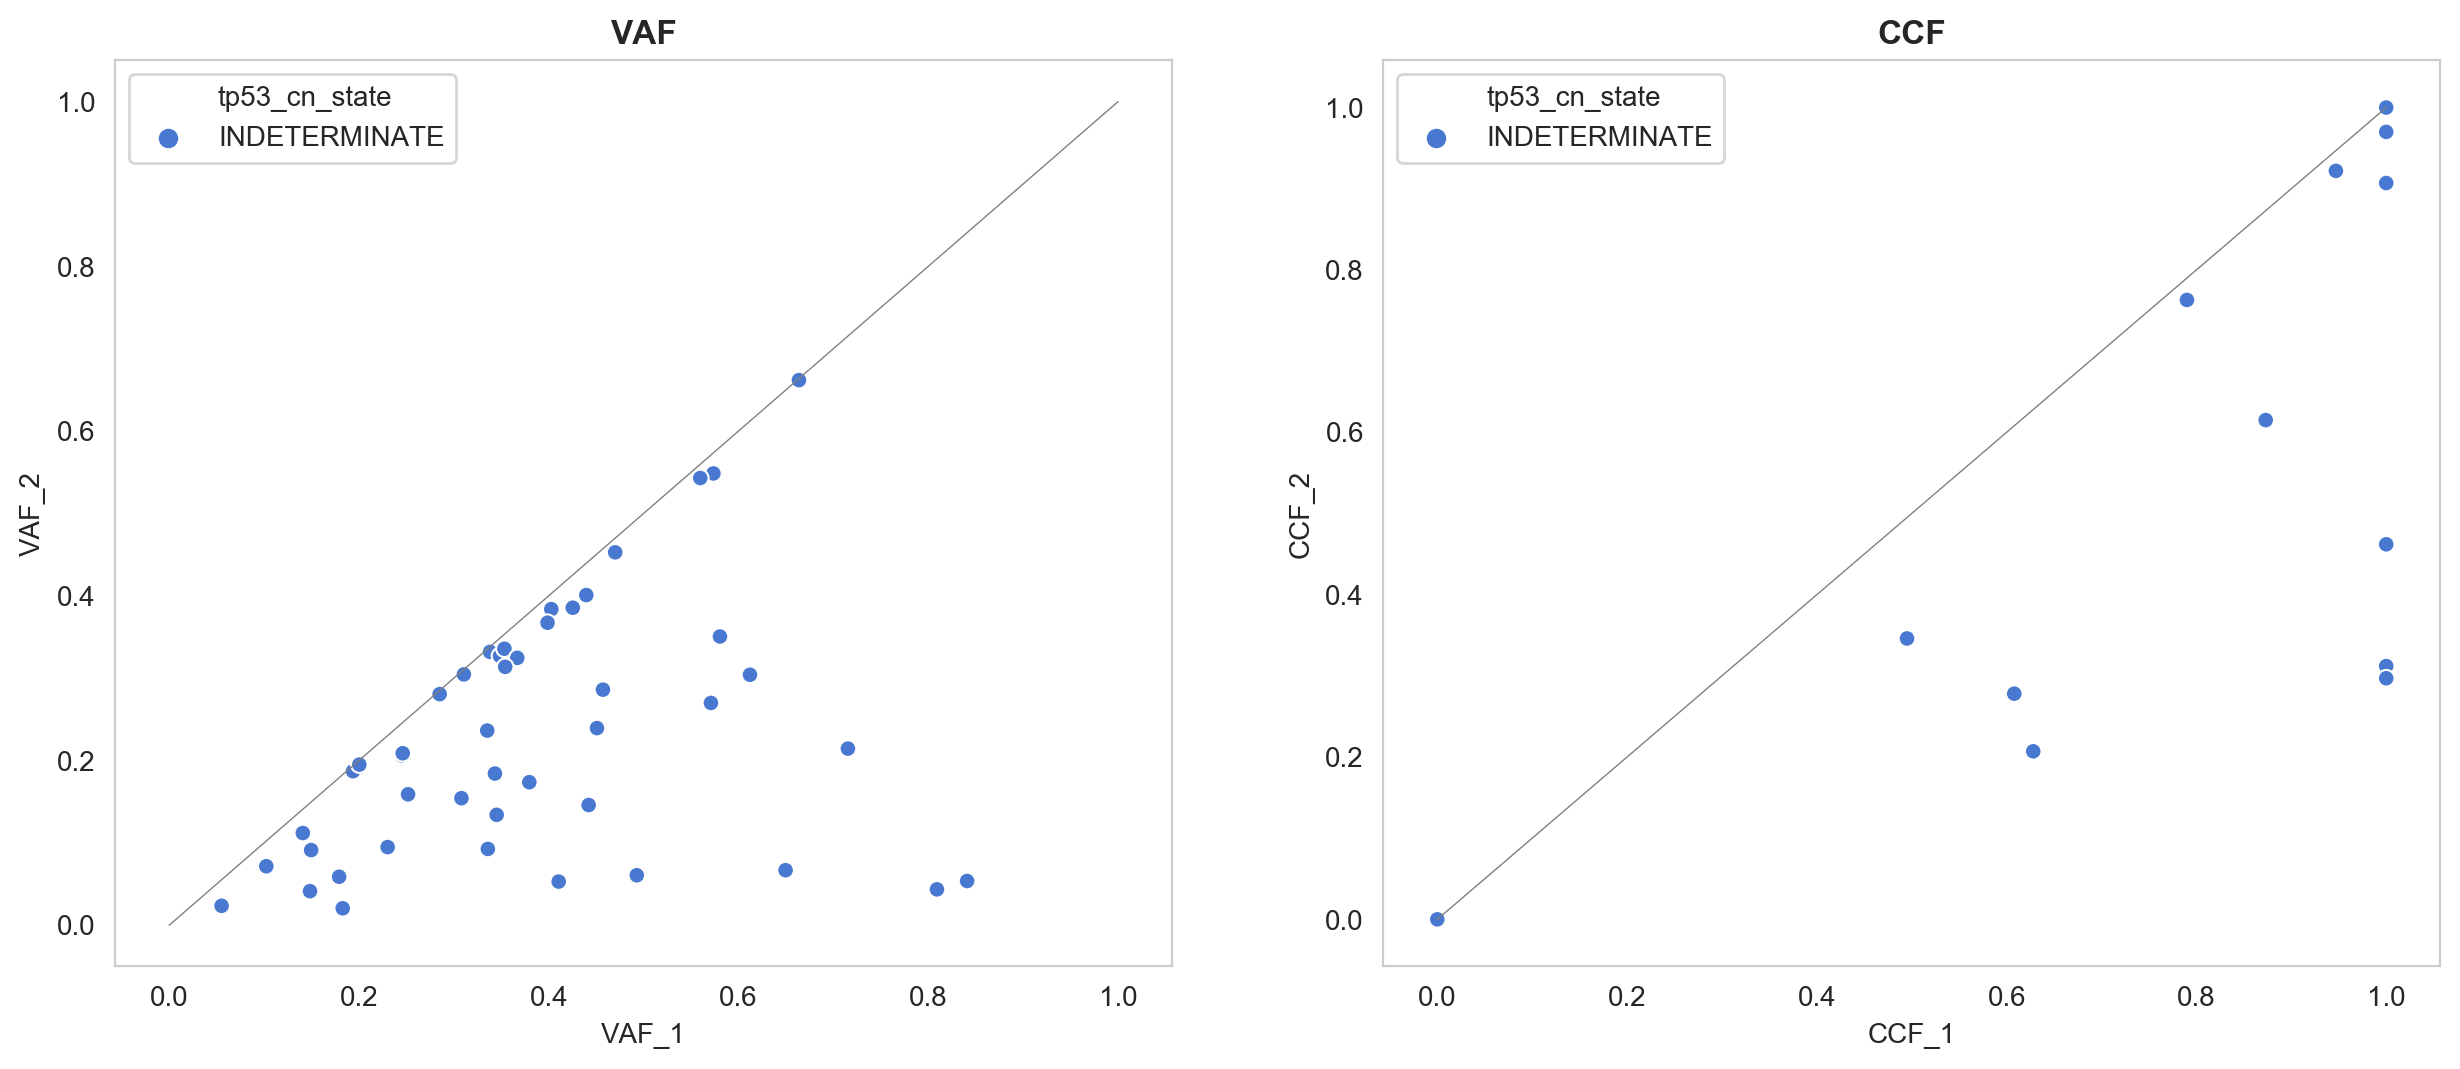

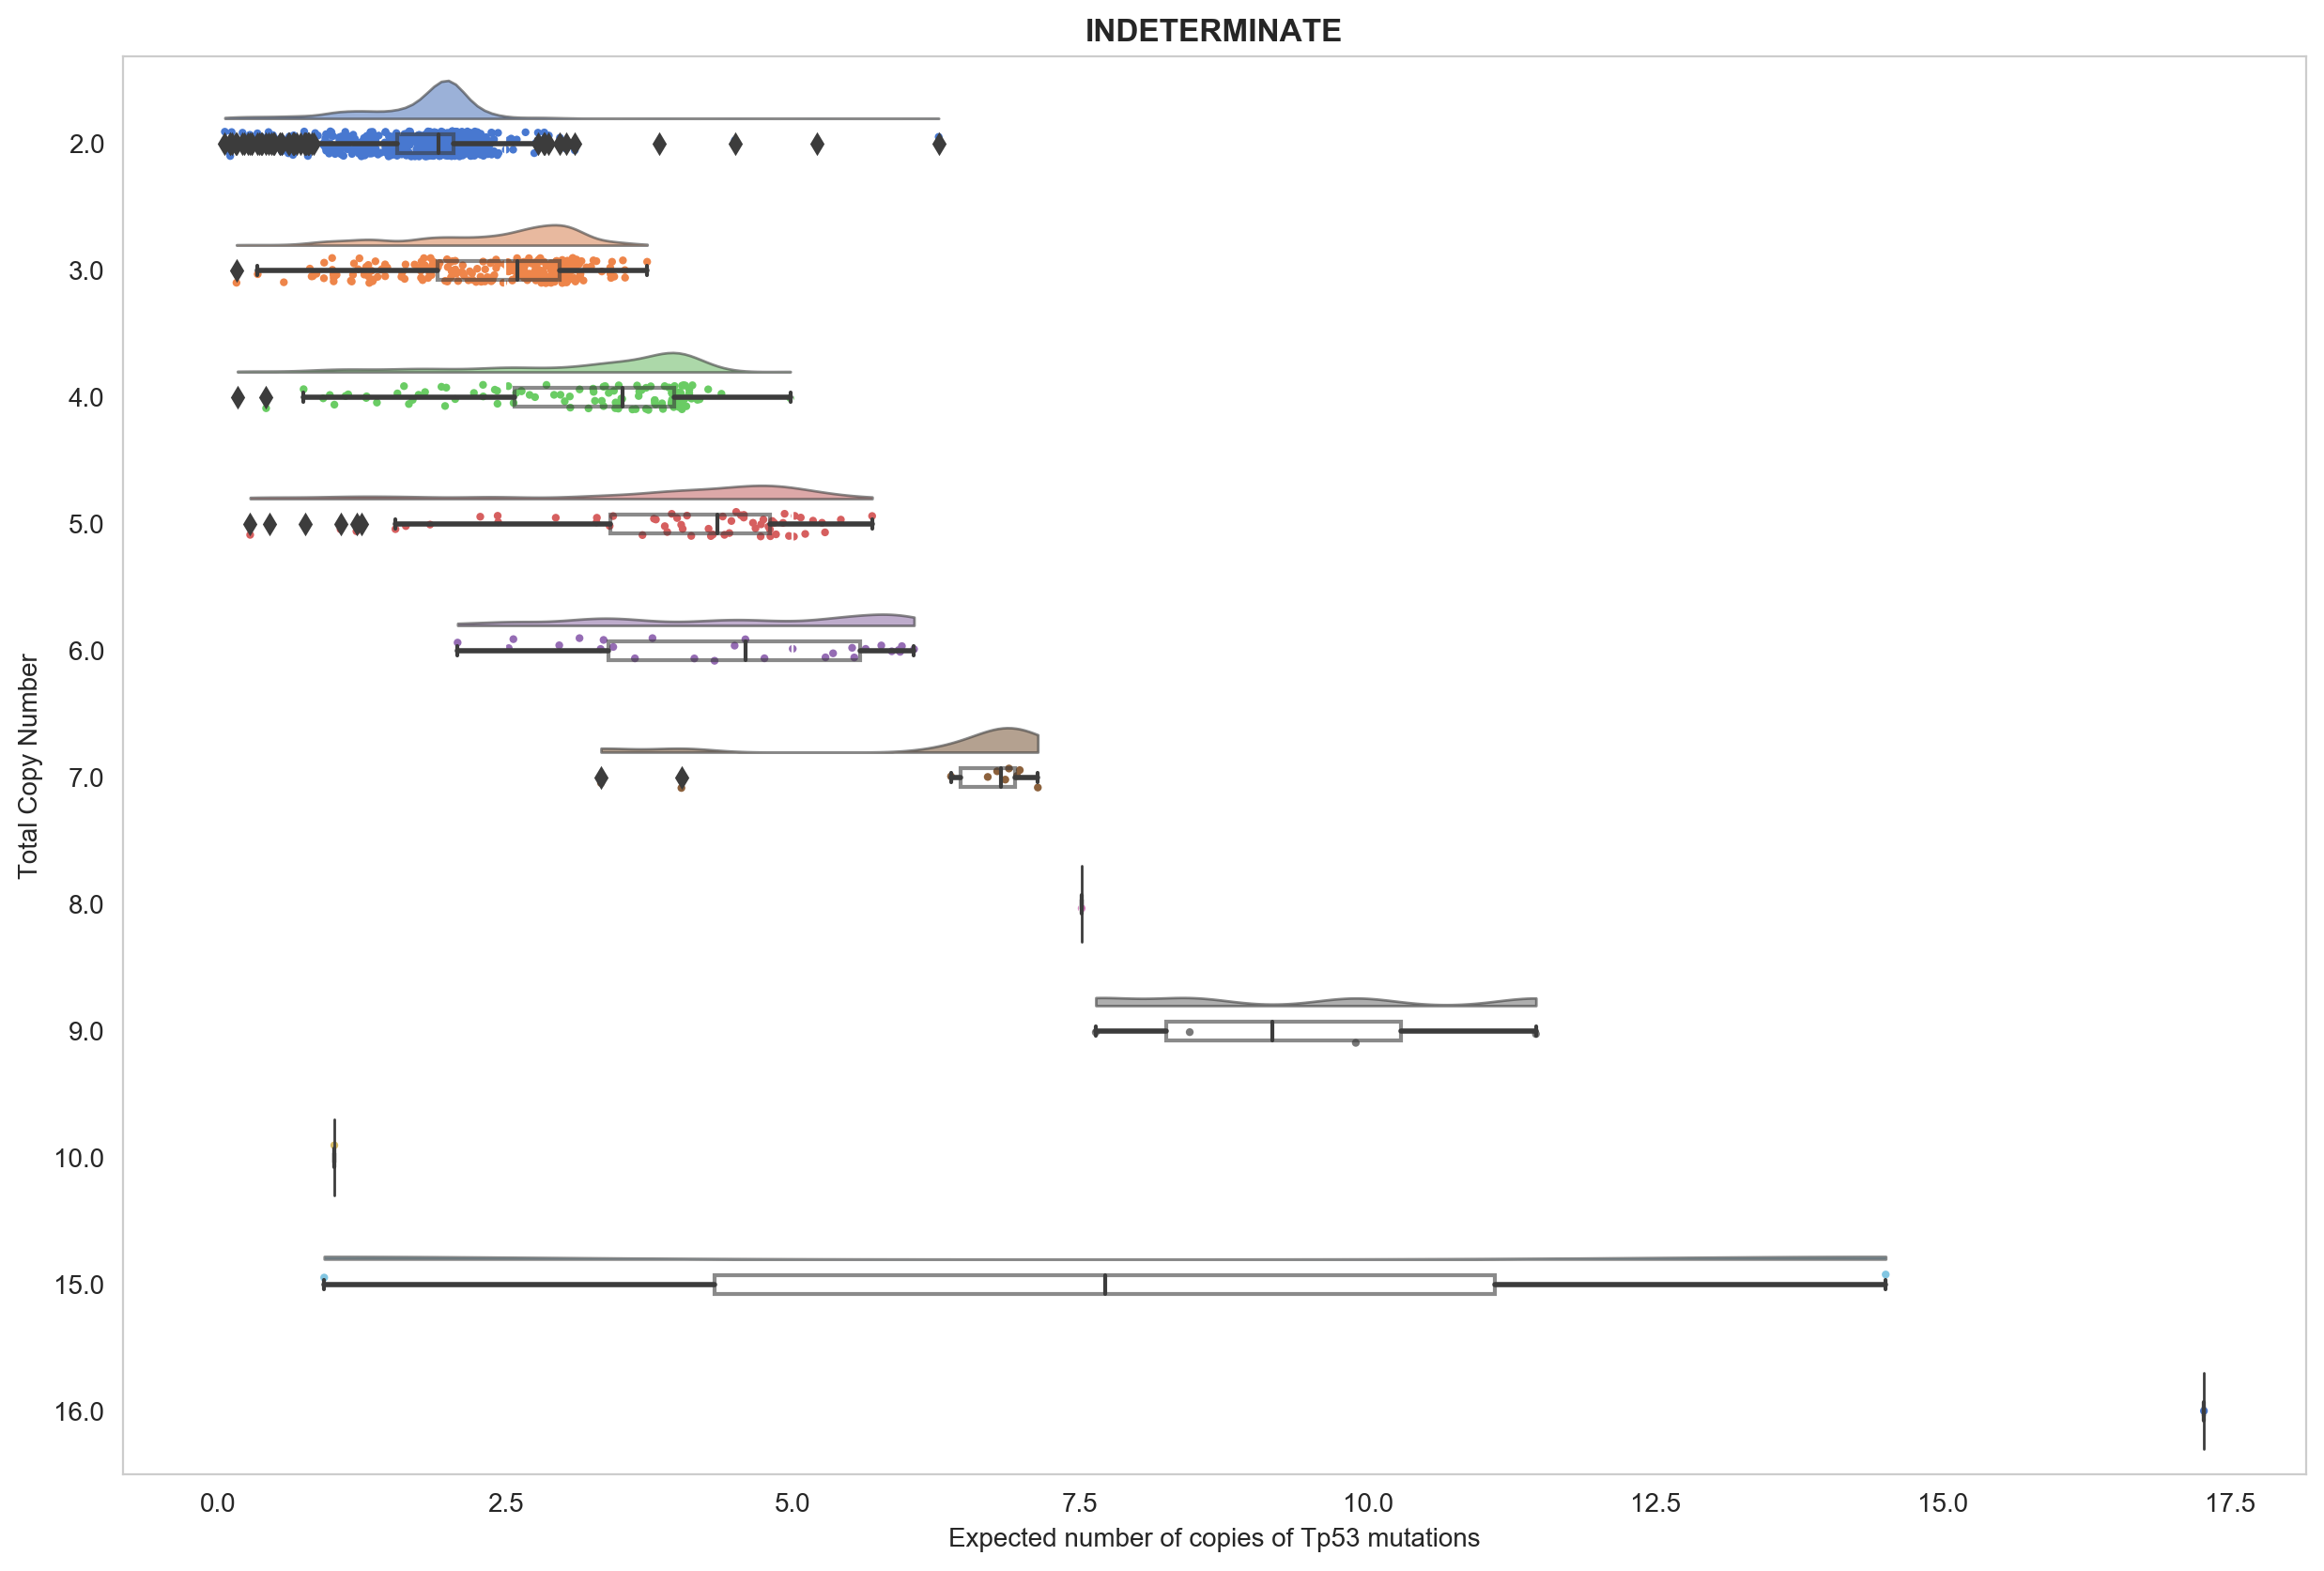

In [17]:
plot_summary(indeterminate, 'INDETERMINATE')

In [18]:
master_density = filter_cn_state(master, indeterminate)
master_density = filter_muts(master_density, [1])
master_density[master_density['tp53_tcn'] == 2]['tp53_exp_nb_1'].describe()

count    707.000000
mean       1.812508
std        0.631587
min        0.063210
25%        1.557537
50%        1.920110
75%        2.050181
max        9.654018
Name: tp53_exp_nb_1, dtype: float64

---
## Final Subgroups Analysis

First, we perform a general analysis on the subgroups without entering the metrics of each one. 
The first questions that have arisen are:
* How big are the subgroups?
* What percentage of the tp53 samples do they represent?
* What is the distribution of mutations within eah group?
* What is the distribution of sample types (Metastasis, Primary) within eah group?
* What are the main Cancers represented by group?


---
* **How big are the subgroups?** In comparison with the entire cohort, in comparison with tp53 positive samples

---
* **How big are the subgroups?** 
* **What is the distribution of mutations within eah group?**
* **What is the distribution of sample types (Metastasis, Primary) within eah group?**
* **What are the main Cancers represented by group?**


count 
 
 
 tp53_group 
 
 
 
 
 
 >=1_LOSS 
 3465 
 
 
 0_HETLOSS 
 2431 
 
 
 >=1_cnLOH 
 679 
 
 
 1_WILD_TYPE 
 496 
 
 
 >1muts 
 428 
 
 
 HOMDEL 
 139 
 
 
 
 
 
 
 
 count 
 
 
 tp53_group 
 tp53_count 
 
 
 
 
 
 0_HETLOSS 
 0 
 2431 
 
 
 1_WILD_TYPE 
 1 
 496 
 
 
 >1muts 
 2 
 364 
 
 
 3 
 54 
 
 
 4 
 8 
 
 
 5 
 2 
 
 
 >=1_LOSS 
 1 
 3346 
 
 
 2 
 103 
 
 
 3 
 13 
 
 
 4 
 3 
 
 
 >=1_cnLOH 
 1 
 657 
 
 
 2 
 19 
 
 
 3 
 3 
 
 
 HOMDEL 
 0 
 96 
 
 
 1 
 36 
 
 
 2 
 6 
 
 
 4 
 1 
 
 
 
 
 
 
 
 count 
 
 
 tp53_group 
 Sample_Type 
 
 
 
 
 
 0_HETLOSS 
 Metastasis 
 1106 
 
 
 Primary 
 1325 
 
 
 1_WILD_TYPE 
 Metastasis 
 143 
 
 
 Primary 
 353 
 
 
 >1muts 
 Metastasis 
 116 
 
 
 Primary 
 312 
 
 
 >=1_LOSS 
 Metastasis 
 1467 
 
 
 Primary 
 1998 
 
 
 >=1_cnLOH 
 Metastasis 
 227 
 
 
 Primary 
 452 
 
 
 HOMDEL 
 Metastasis 
 47 
 
 
 Primary 
 92 
 
 
 
 
 
 
 
 count 
 
 
 tp53_group 
 Cancer_Type 
 
 
 
 
 
 0_HETLOSS 
 Breast Cancer 
 784 
 
 
 Non-Small Cell Lung Cancer 
 294 
 
 
 Prostate Cancer 
 209 
 
 
 1_WILD_TYPE 
 Colorectal Cancer 
 92 
 
 
 Glioma 
 63 
 
 
 Non-Small Cell Lung Cancer 
 62 
 
 
 >1muts 
 Glioma 
 95 
 
 
 Colorectal Cancer 
 65 
 
 
 Non-Small Cell Lung Cancer 
 40 
 
 
 >=1_LOSS 
 Colorectal Cancer 
 622 
 
 
 Breast Cancer 
 496 
 
 
 Pancreatic Cancer 
 468 
 
 
 >=1_cnLOH 
 Glioma 
 128 
 
 
 Colorectal Cancer 
 109 
 
 
 Non-Small Cell Lung Cancer 
 91 
 
 
 HOMDEL 
 Breast Cancer 
 24 
 
 
 Non-Small Cell Lung Cancer 
 17 
 
 
 Prostate Cancer 
 15

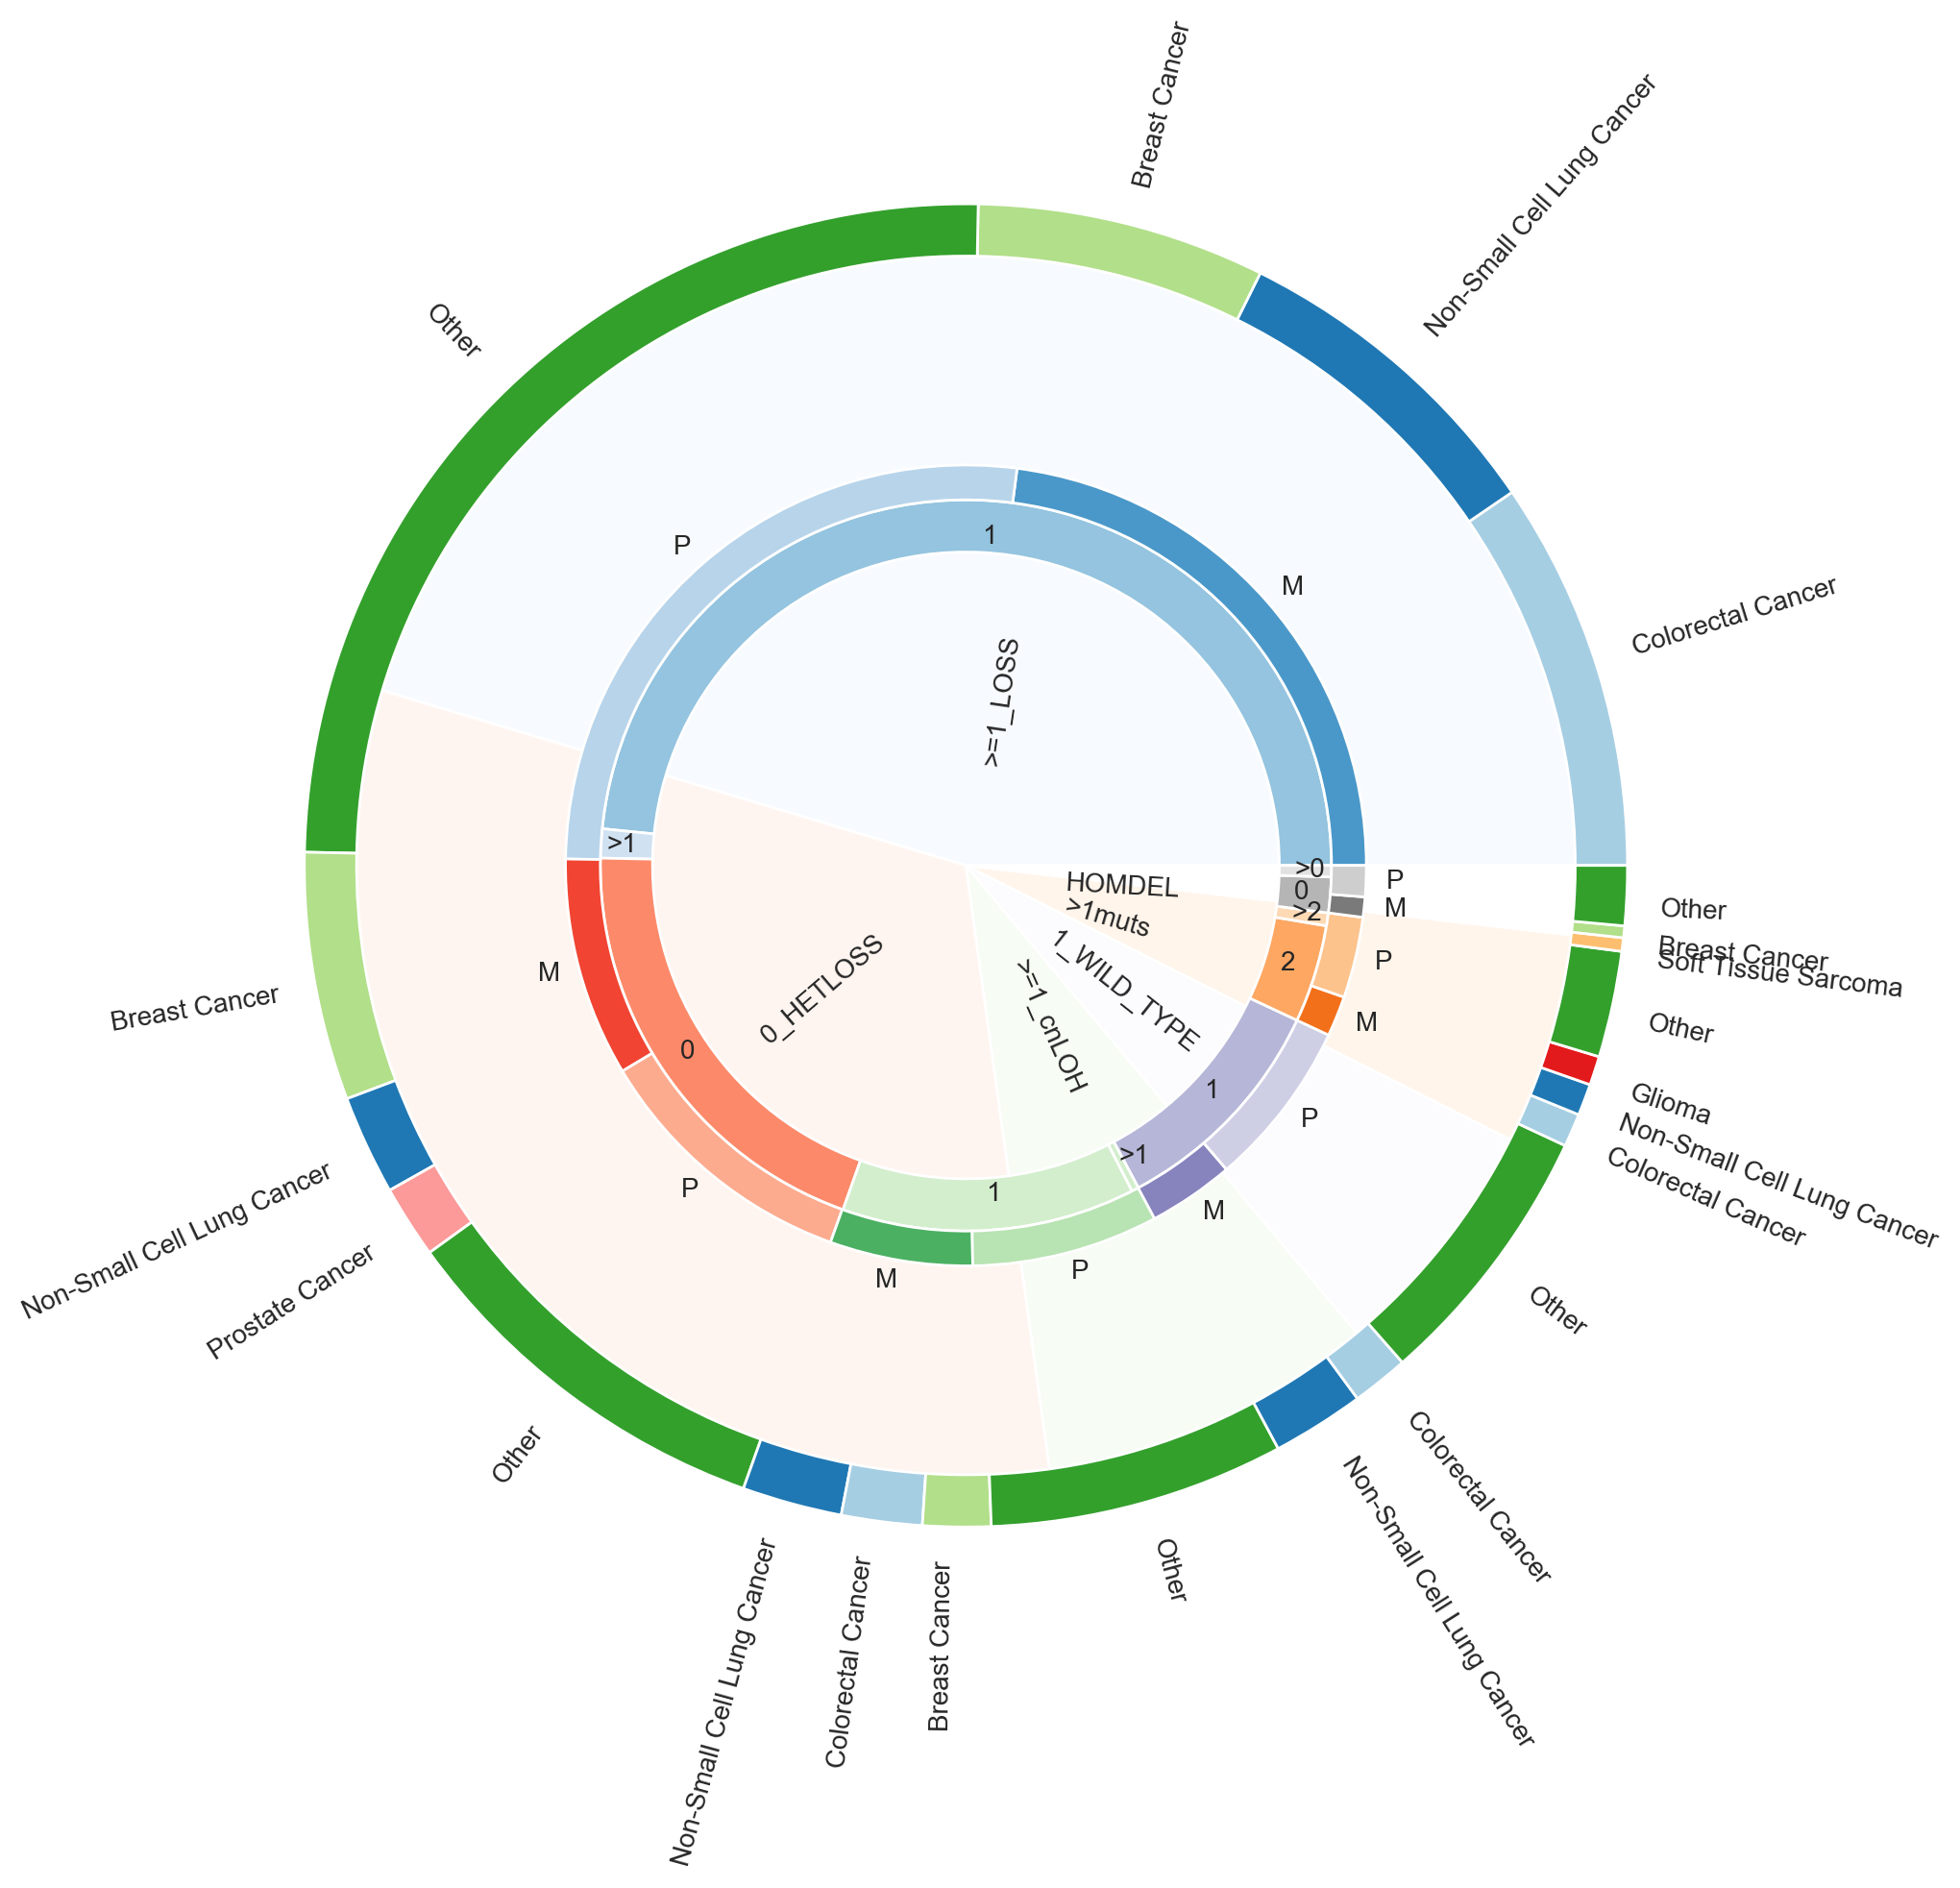

In [17]:
mut_tp53_count = pd.DataFrame(master[['tp53_group', 'tp53_count']].groupby(
    ['tp53_group', 'tp53_count'], sort=True).size())
mut_tp53_count.columns = ['count']

group_sample_count = pd.DataFrame(master[['tp53_group',
                                          'Sample_Type']].groupby(
                                              ['tp53_group', 'Sample_Type'],
                                              sort=True).size())
group_sample_count.columns = ['count']

# We select the 3 biggest cancers per subgroup.
cancers_per_group = pd.DataFrame(master[['tp53_group',
                                         'Cancer_Type']].groupby(
                                             ['tp53_group', 'Cancer_Type'],
                                             sort=True).size())
cancers_per_group.columns = ['count']
cancers_per_group = cancers_per_group['count'].groupby(level=0,
                                                       group_keys=False)
cancers_per_group = cancers_per_group.apply(
    lambda x: x.sort_values(ascending=False).head(3))

group_names = [
    '>=1_LOSS', '0_HETLOSS', '>=1_cnLOH', '1_WILD_TYPE', '>1muts', 'HOMDEL'
]
group_size = sorted(list(
    mut_tp53_count.groupby(['tp53_group']).sum()['count']),
                    reverse=True)

subgroup_size = [6904, 183, 2833, 1850, 45, 1457, 616, 81, 224, 72]
subgroup_names = [1, '>1', 0, 1, '>1', 1, 2, '>2', 0, '>0']

sample_size = [3271, 3816, 1260, 1556, 821, 1074, 494, 963, 232, 465, 116, 179]
sample_names = ['M', 'P', 'M', 'P', 'M', 'P', 'M', 'P', 'M', 'P', 'M', 'P']

cancer_size = [
    1361, 1158, 1005, 3563, 864, 347, 254, 1368, 348, 281, 237, 1029, 322, 198,
    937, 116, 110, 101, 370, 47, 41, 208
]

cancer_names = [
    'Colorectal Cancer', 'Non-Small Cell Lung Cancer', 'Breast Cancer',
    'Other', 'Breast Cancer', 'Non-Small Cell Lung Cancer', 'Prostate Cancer',
    'Other', 'Non-Small Cell Lung Cancer', 'Colorectal Cancer',
    'Breast Cancer', 'Other', 'Non-Small Cell Lung Cancer',
    'Colorectal Cancer', 'Other', 'Colorectal Cancer',
    'Non-Small Cell Lung Cancer', 'Glioma', 'Other', 'Soft Tissue Sarcoma',
    'Breast Cancer', 'Other'
]

group_count = get_groupby(master, 'tp53_group',
                          'count').sort_values(by='count', ascending=False)

display_side_by_side(group_count, mut_tp53_count, group_sample_count,
                     pd.DataFrame(cancers_per_group))

# Create colors
a, b, c, d, e, f, g = [
    plt.cm.Blues, plt.cm.Reds, plt.cm.Greens, plt.cm.Purples, plt.cm.Oranges,
    plt.cm.Greys, plt.cm.Paired
]

my_colors = [
    g(0),
    g(1),
    g(2),
    g(3),
    g(2),
    g(1),
    g(4),
    g(3),
    g(1),
    g(0),
    g(2),
    g(3),
    g(1),
    g(0),
    g(3),
    g(0),
    g(1),
    g(5),
    g(3),
    g(6),
    g(2),
    g(3)
]
# First Ring (outside)
fig, ax = plt.subplots()
ax.axis('equal')
mypie, _ = ax.pie(group_size,
                  radius=1.4,
                  colors=[a(0.6),
                          b(0.6),
                          c(0.6),
                          d(0.6),
                          e(0.6),
                          f(0.6)])
plt.setp(mypie, width=0.3, edgecolor='white')

mypie2, _ = ax.pie(group_size,
                   radius=1.9,
                   labels=group_names,
                   labeldistance=0.15,
                   rotatelabels=True,
                   colors=[a(0), b(0), c(0),
                           d(0), e(0), f(0)])
plt.setp(mypie2, width=1.9, edgecolor='white')
plt.margins(0, 0)

mypie2, _ = ax.pie(cancer_size,
                   radius=1.9,
                   labels=cancer_names,
                   labeldistance=1.05,
                   rotatelabels=True,
                   colors=my_colors)
plt.setp(mypie2, width=0.15, edgecolor='white')
plt.margins(0, 0)

# Second Ring (Inside)
mypie3, _ = ax.pie(subgroup_size,
                   radius=1.4 - 0.35,
                   labels=subgroup_names,
                   labeldistance=0.9,
                   colors=[
                       a(0.4),
                       a(0.2),
                       b(0.4),
                       c(0.2),
                       c(0.2),
                       d(0.4),
                       e(0.4),
                       e(0.2),
                       f(0.4),
                       f(0.2)
                   ])
plt.setp(mypie3, width=0.15, edgecolor='white')
plt.margins(0, 0)

# Third Ring (Middle)
mypie4, _ = ax.pie(sample_size,
                   radius=1.4 - 0.25,
                   labels=sample_names,
                   labeldistance=1.05,
                   colors=[
                       a(0.6),
                       a(0.3),
                       b(0.6),
                       b(0.3),
                       c(0.6),
                       c(0.3),
                       d(0.6),
                       d(0.3),
                       e(0.6),
                       e(0.3),
                       f(0.6),
                       f(0.3)
                   ])
plt.setp(mypie4, width=0.1, edgecolor='white')
plt.margins(0, 0)

#fig.savefig("tp53_subgroups.png", dpi=300, bbox_inches = 'tight')

We display it properly thanks to HTML tags

In [18]:
title = "tp53_subgroups"
html = prefix.replace('title', title)+mut_tp53_count.to_html()+suffix.replace('pic_file.png', title+".png")
IPython.display.display_html(html, raw=True)

<!DOCTYPE html>
 
 

 
 

 tp53_subgroups 

 
 
 
 
 
 
 
 count 
 
 
 tp53_group 
 tp53_count 
 
 
 
 
 
 0_HETLOSS 
 0 
 2431 
 
 
 1_WILD_TYPE 
 1 
 496 
 
 
 >1muts 
 2 
 364 
 
 
 3 
 54 
 
 
 4 
 8 
 
 
 5 
 2 
 
 
 >=1_LOSS 
 1 
 3346 
 
 
 2 
 103 
 
 
 3 
 13 
 
 
 4 
 3 
 
 
 >=1_cnLOH 
 1 
 657 
 
 
 2 
 19 
 
 
 3 
 3 
 
 
 HOMDEL 
 0 
 96 
 
 
 1 
 36 
 
 
 2 
 6 
 
 
 4 
 1

count
tp53_group        
OTHER         7877
>=1_LOSS      3465
0_HETLOSS     2431
>=1_cnLOH      679
1_WILD_TYPE    496
>1muts         428
HOMDEL         139

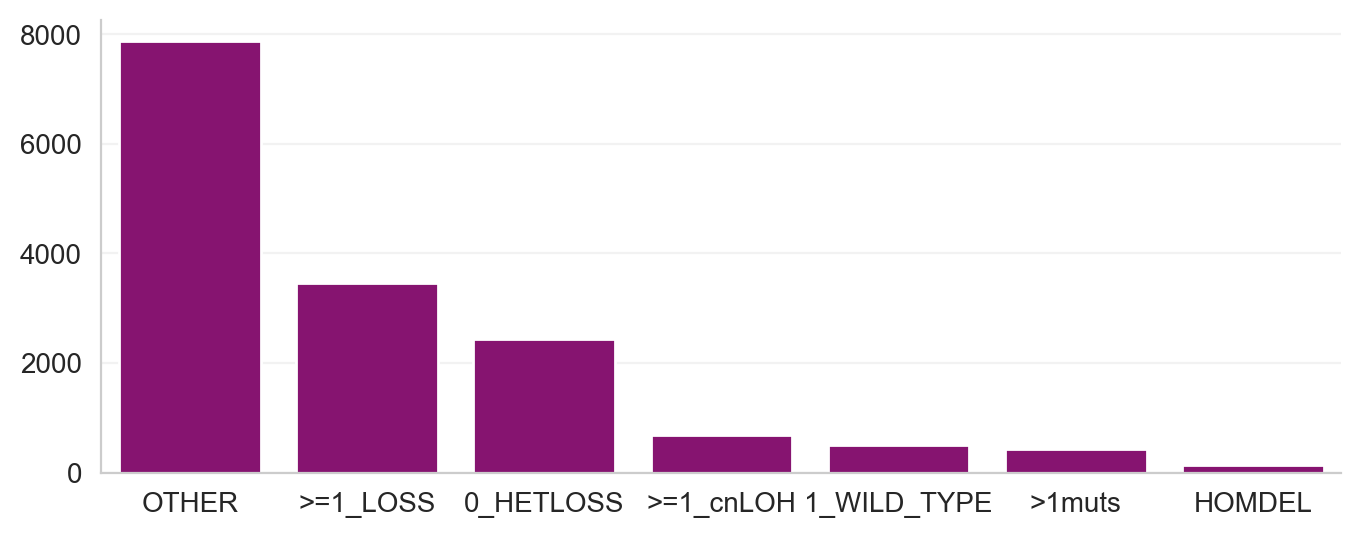

In [19]:
count = get_groupby(master, 'tp53_group', 'count')
count.loc['OTHER'] = [len(master) - int(get_groupby(master, 'tp53_group', 'count').sum())]
count = count.sort_values(by=['count'], ascending=False)
display(count)
get_ploth('count', count.index, count, '', '', '',color=plt.cm.RdPu(0.8), figsize=(8,3), perc=False)
plt.show()

---
* **What percentage of the tp53 samples do they represent?**

count 
 
 
 tp53_group 
 
 
 
 
 
 1_WILD_TYPE 
 496 
 
 
 >1muts 
 428 
 
 
 >=1_LOSS 
 3465 
 
 
 >=1_cnLOH 
 679 
 
 
 HOMDEL 
 43 
 
 
 OTHER 
 71 
 
 
 0_HETLOSS 
 0 
 
 
 
 
 
 
 % 
 
 
 tp53_group 
 
 
 
 
 
 >=1_LOSS 
 66.9 
 
 
 >=1_cnLOH 
 13.1 
 
 
 1_WILD_TYPE 
 9.6 
 
 
 >1muts 
 8.3 
 
 
 OTHER 
 1.4 
 
 
 HOMDEL 
 0.8 
 
 
 0_HETLOSS 
 0.0

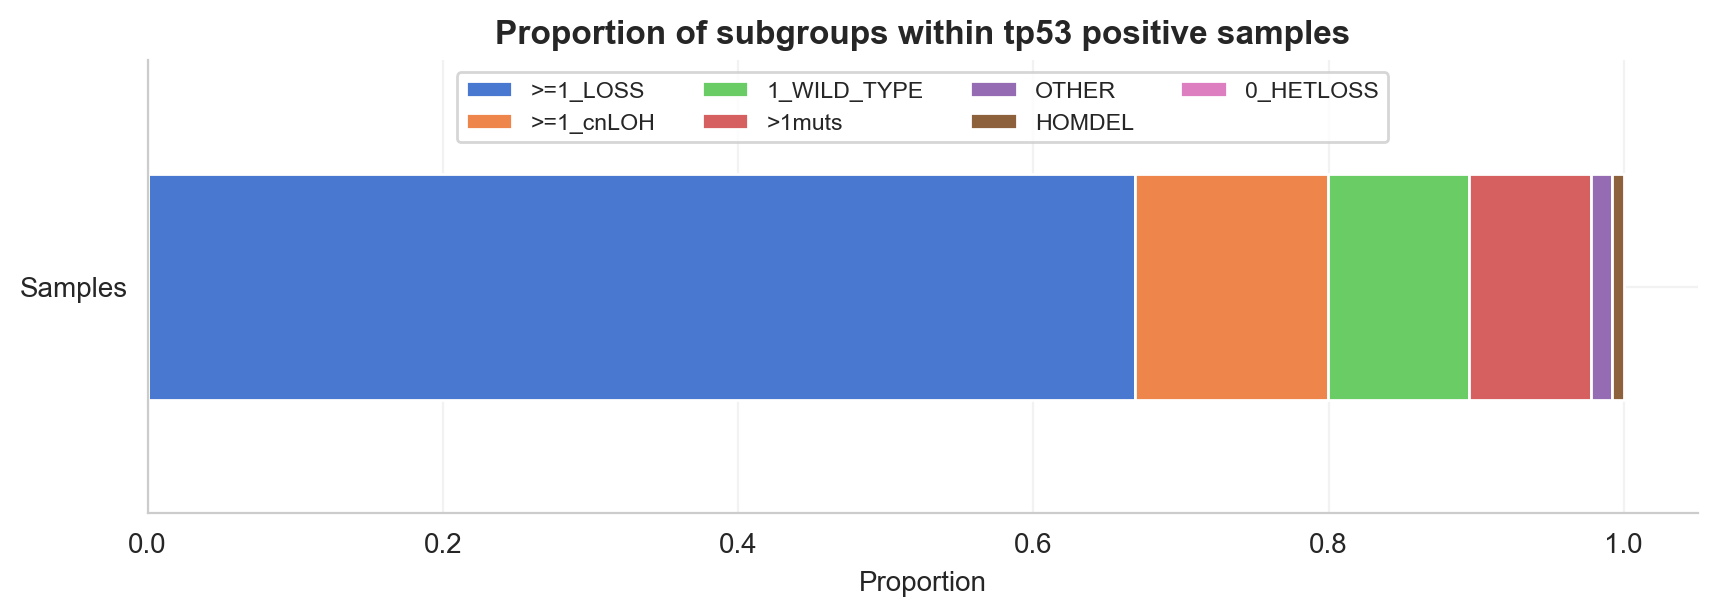

In [20]:
from itertools import cycle, islice

master_mult = filter_muts(master, [1,2,3,4,5])

# We verify that our notebooks 
assert( len(master_mult) == master_mult.tp53_group.isna().sum() + int(get_groupby(master_mult, 'tp53_group', 'count').sum()))

count = get_groupby(master_mult, 'tp53_group', 'count')
count.loc['OTHER'] = [len(master_mult) - int(get_groupby(master_mult, 'tp53_group', 'count').sum())]
count.loc['0_HETLOSS'] = [0]

freq = pd.DataFrame(count['count']).sort_values(by=['count'], ascending=False)/ pd.DataFrame(count['count']).sum()
freq.columns=['%']
display_side_by_side(count, round(100*freq,1))

#Plotting it
fig, ax = plt.subplots()
my_colors = list(islice(cycle(list(sns.color_palette("muted"))), None, len(count)))
freq.T.plot(kind = 'barh', stacked=True, figsize = (10,3), ax=ax, yticks=[], color=my_colors)
plt.title('Proportion of subgroups within tp53 positive samples', weight = 'bold')
plt.legend(loc = 'upper center', fontsize='small', ncol=4)
ax.yaxis.set_major_formatter(matplotlib.ticker.IndexFormatter(['Samples']))
ax.spines['right'].set_visible(False)
ax.set_xlabel('Proportion')
ax.spines['top'].set_visible(False)
plt.show()

---
What cn_state are present in the OTHER subgroup, and what is the number of people?

count     %
tp53_cn_state              
CNLOH & GAIN       36  50.7
GAIN               33  46.5
AMP                 1   1.4
AMP (BALANCED)      1   1.4

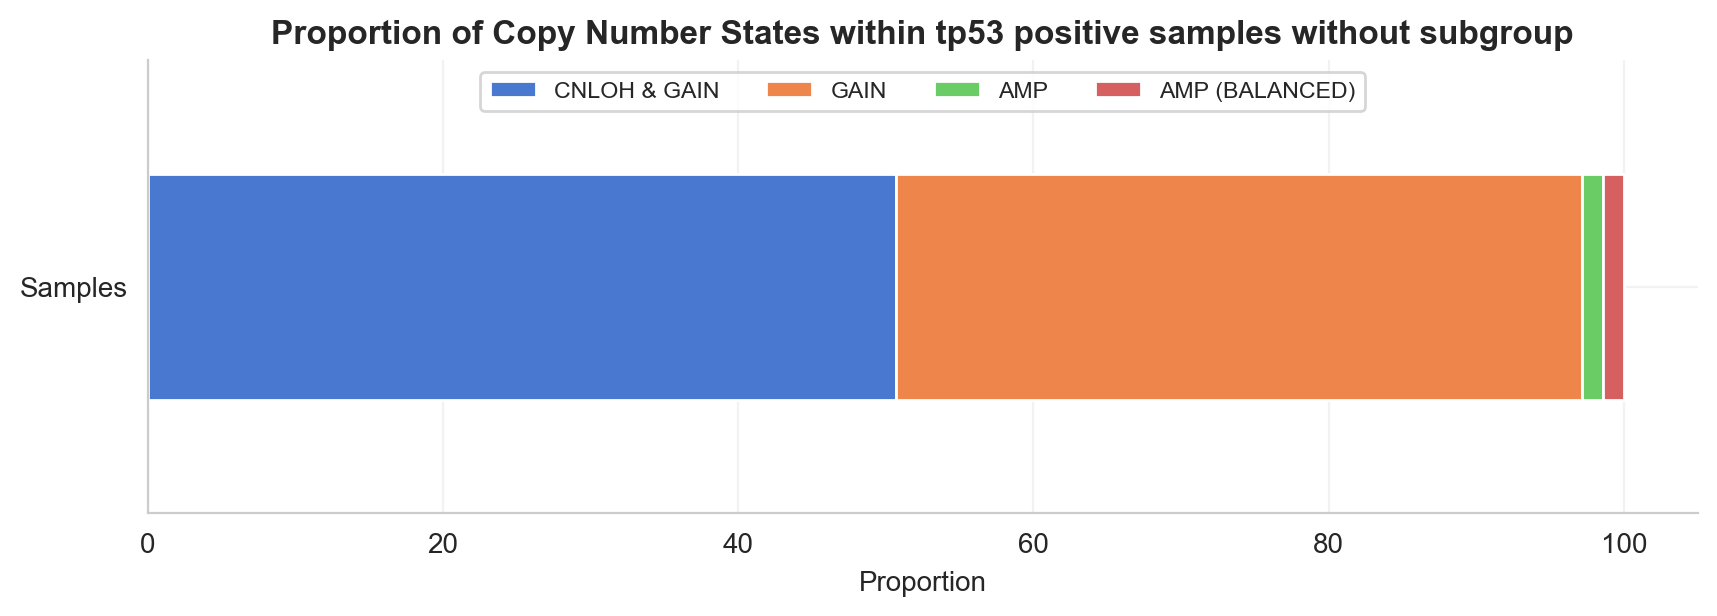

In [21]:
master_mult = filter_muts(master, [1,2,3,4,5])
master_mult = filter_general(master_mult, 'tp53_group',[None])
count = get_groupby(master_mult, 'tp53_cn_state', 'count').sort_values(by=['count'], ascending=False)
count['%'] = round(100*pd.DataFrame(count['count']).sort_values(by=['count'], ascending=False)/ pd.DataFrame(count['count']).sum(),1)
#freq.columns = ['%']
display(count)

#Plotting it
fig, ax = plt.subplots()
my_colors = list(islice(cycle(list(sns.color_palette("muted"))), None, len(count)))
count[['%']].T.plot(kind = 'barh', stacked=True, figsize = (10,3), ax=ax, yticks=[], color=my_colors)
plt.title('Proportion of Copy Number States within tp53 positive samples without subgroup', weight = 'bold')
plt.legend(loc = 'upper center', fontsize='small', ncol=5)
ax.yaxis.set_major_formatter(matplotlib.ticker.IndexFormatter(['Samples']))
ax.spines['right'].set_visible(False)
ax.set_xlabel('Proportion')
ax.spines['top'].set_visible(False)
plt.show()


## Individual Group - TP53 State Description

The following plots describe the different subgroups we created.
* *nb_muts_density*: nb of tp53 mutations we select to plot the densities (vaf, ccf, purity)
* *nb_muts_scatter*: nb of tp53 mutations we select to plot the scatters (VAF1/VAF2 and CCF1/CCF2) (0 means no plot because no multiple mutations)
* *mut_cn_group*: condition parameter to plot (not important)

**NB**: For now, 0_HETLOSS does not have anything because the subgroup does not include any tp53 mutation, same for HOMDEL. Tomorrow (Wednesday) I will compute visual summaries for them.

count 
 
 
 tp53_cn_state 
 
 
 
 
 
 HETLOSS 
 3148 
 
 
 
 
 
 
 count 
 
 
 Cancer_Type 
 
 
 
 
 
 Colorectal Cancer 
 588 
 
 
 Breast Cancer 
 461 
 
 
 Pancreatic Cancer 
 382 
 
 
 Non-Small Cell Lung Cancer 
 360 
 
 
 Prostate Cancer 
 192 
 
 
 Ovarian Cancer 
 156 
 
 
 Endometrial Cancer 
 120 
 
 
 Cancer of Unknown Primary 
 101 
 
 
 Hepatobiliary Cancer 
 90 
 
 
 Small Cell Lung Cancer 
 90 
 
 
 Esophagogastric Cancer 
 87 
 
 
 Glioma 
 73 
 
 
 Bladder Cancer 
 70 
 
 
 Soft Tissue Sarcoma 
 63 
 
 
 Melanoma 
 48 
 
 
 
 
 
 
 count 
 
 
 tp53_count 
 
 
 
 
 
 1 
 3041 
 
 
 2 
 95 
 
 
 3 
 12

<Figure size 600x600 with 0 Axes>

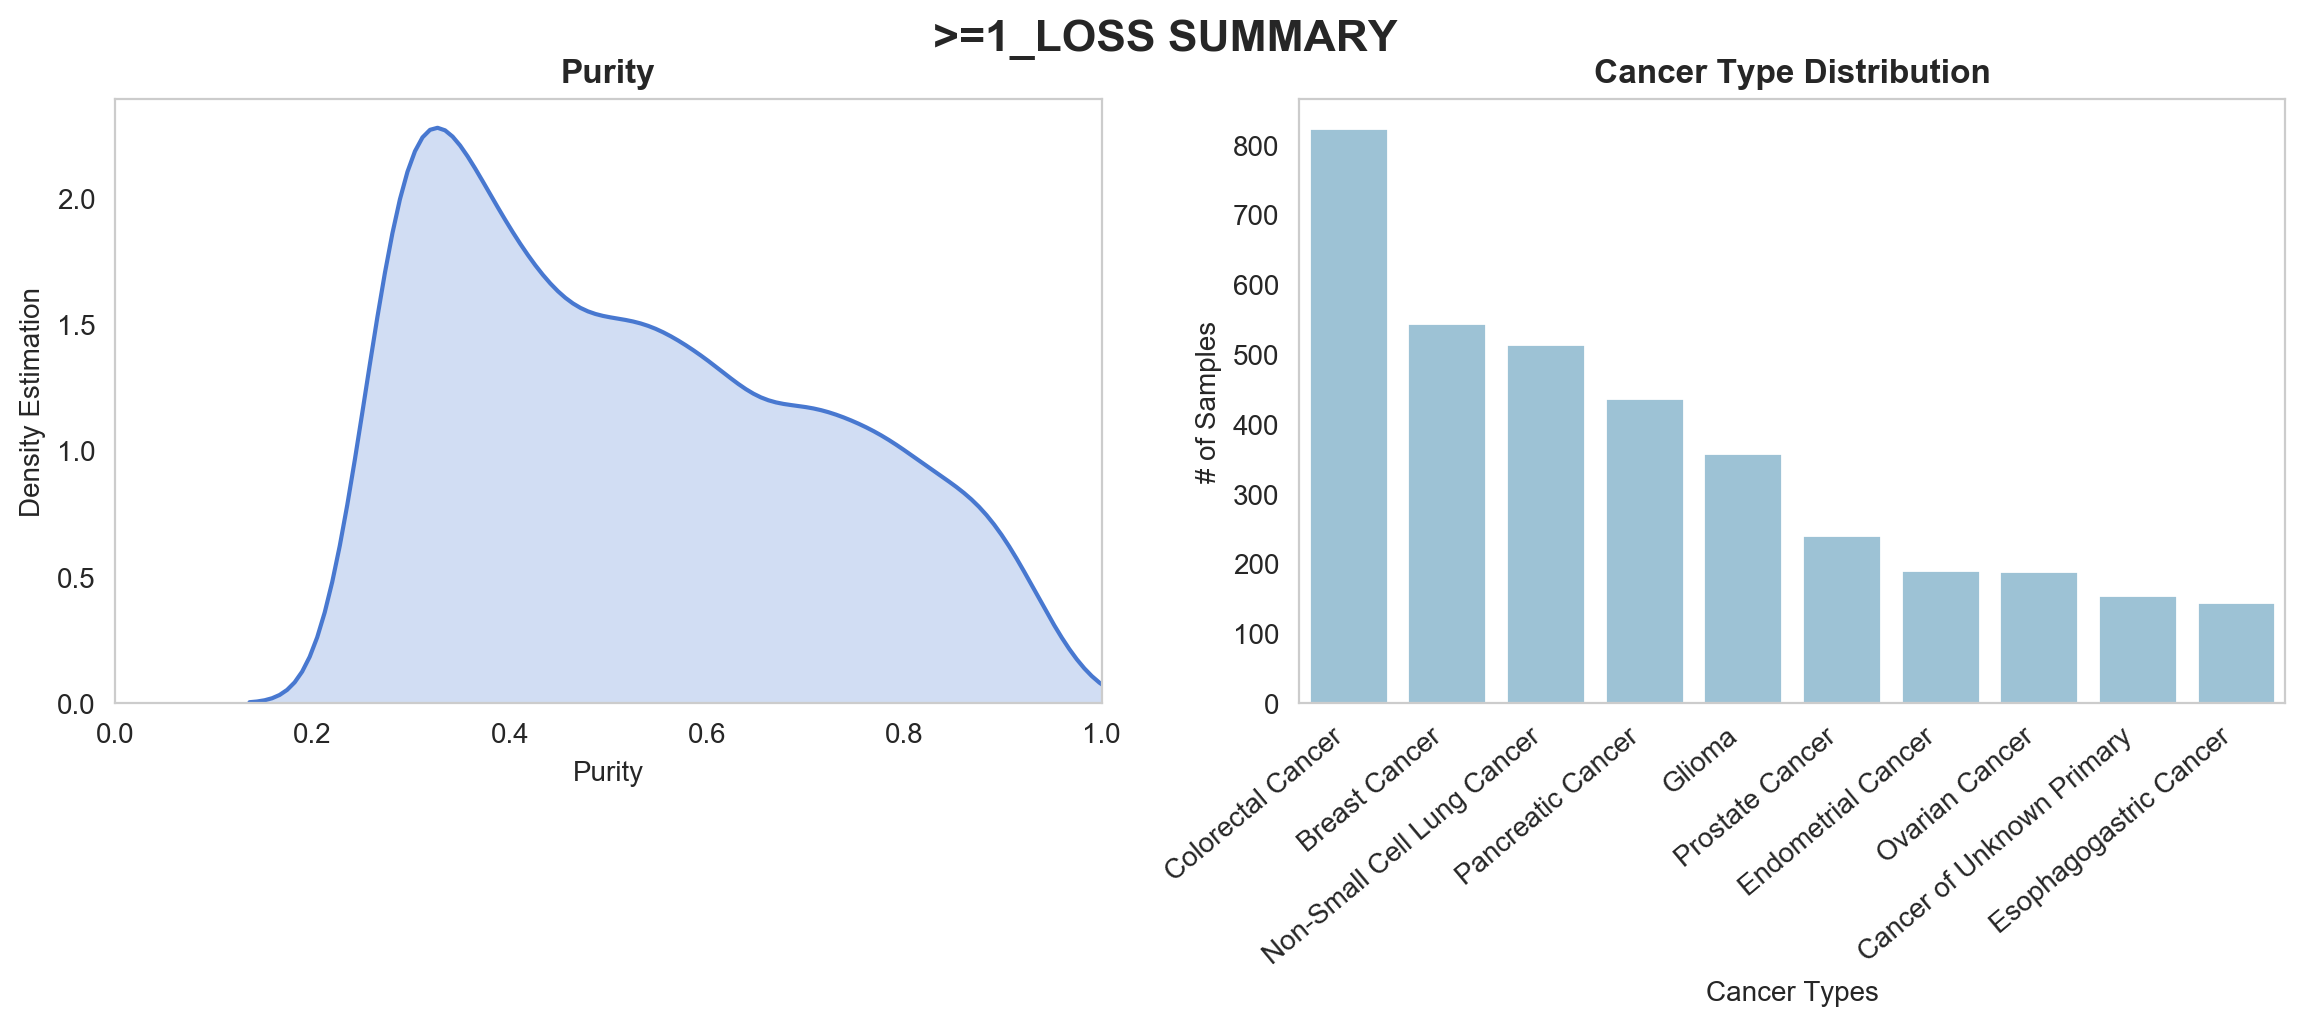

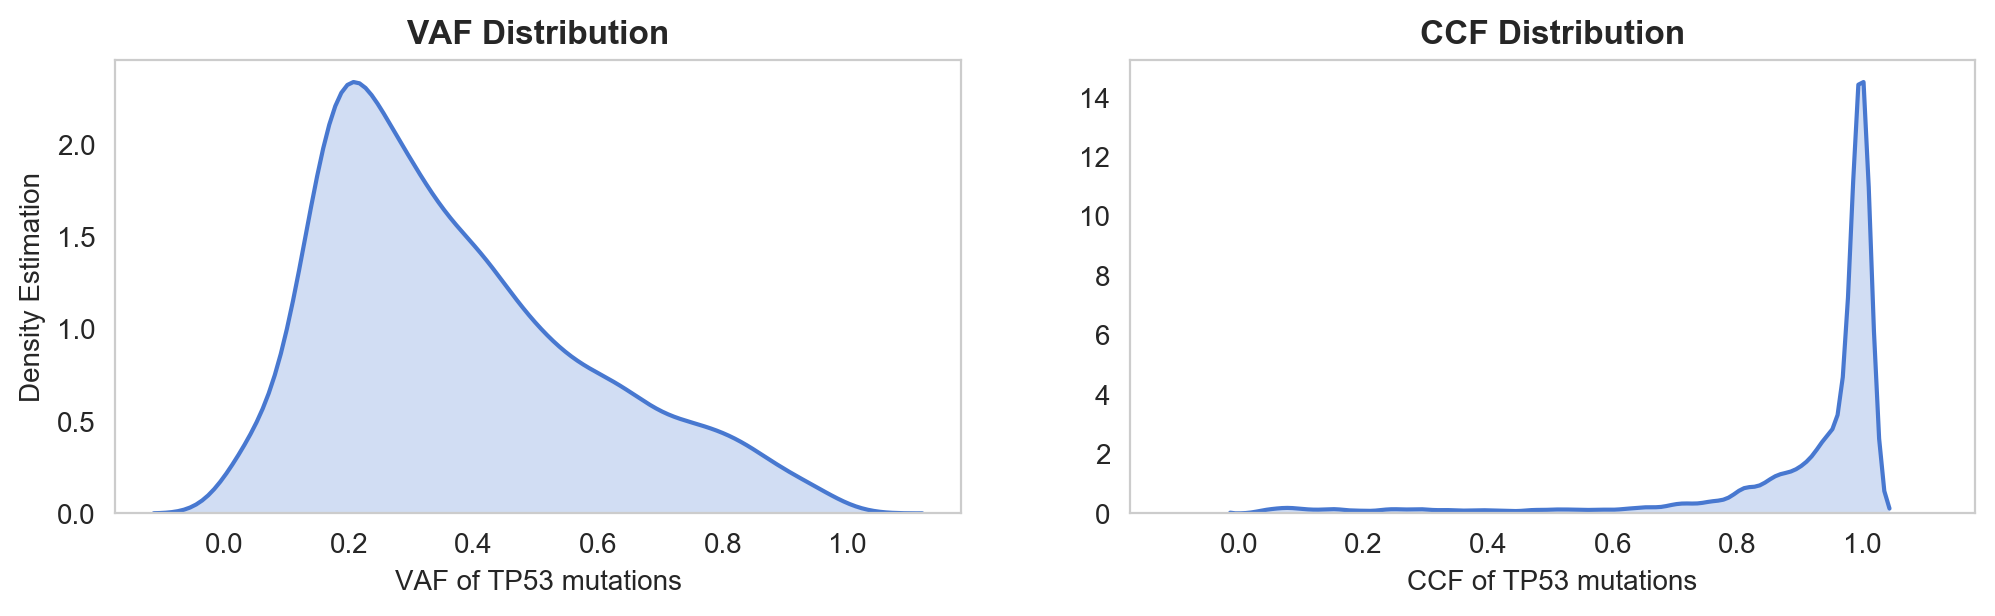

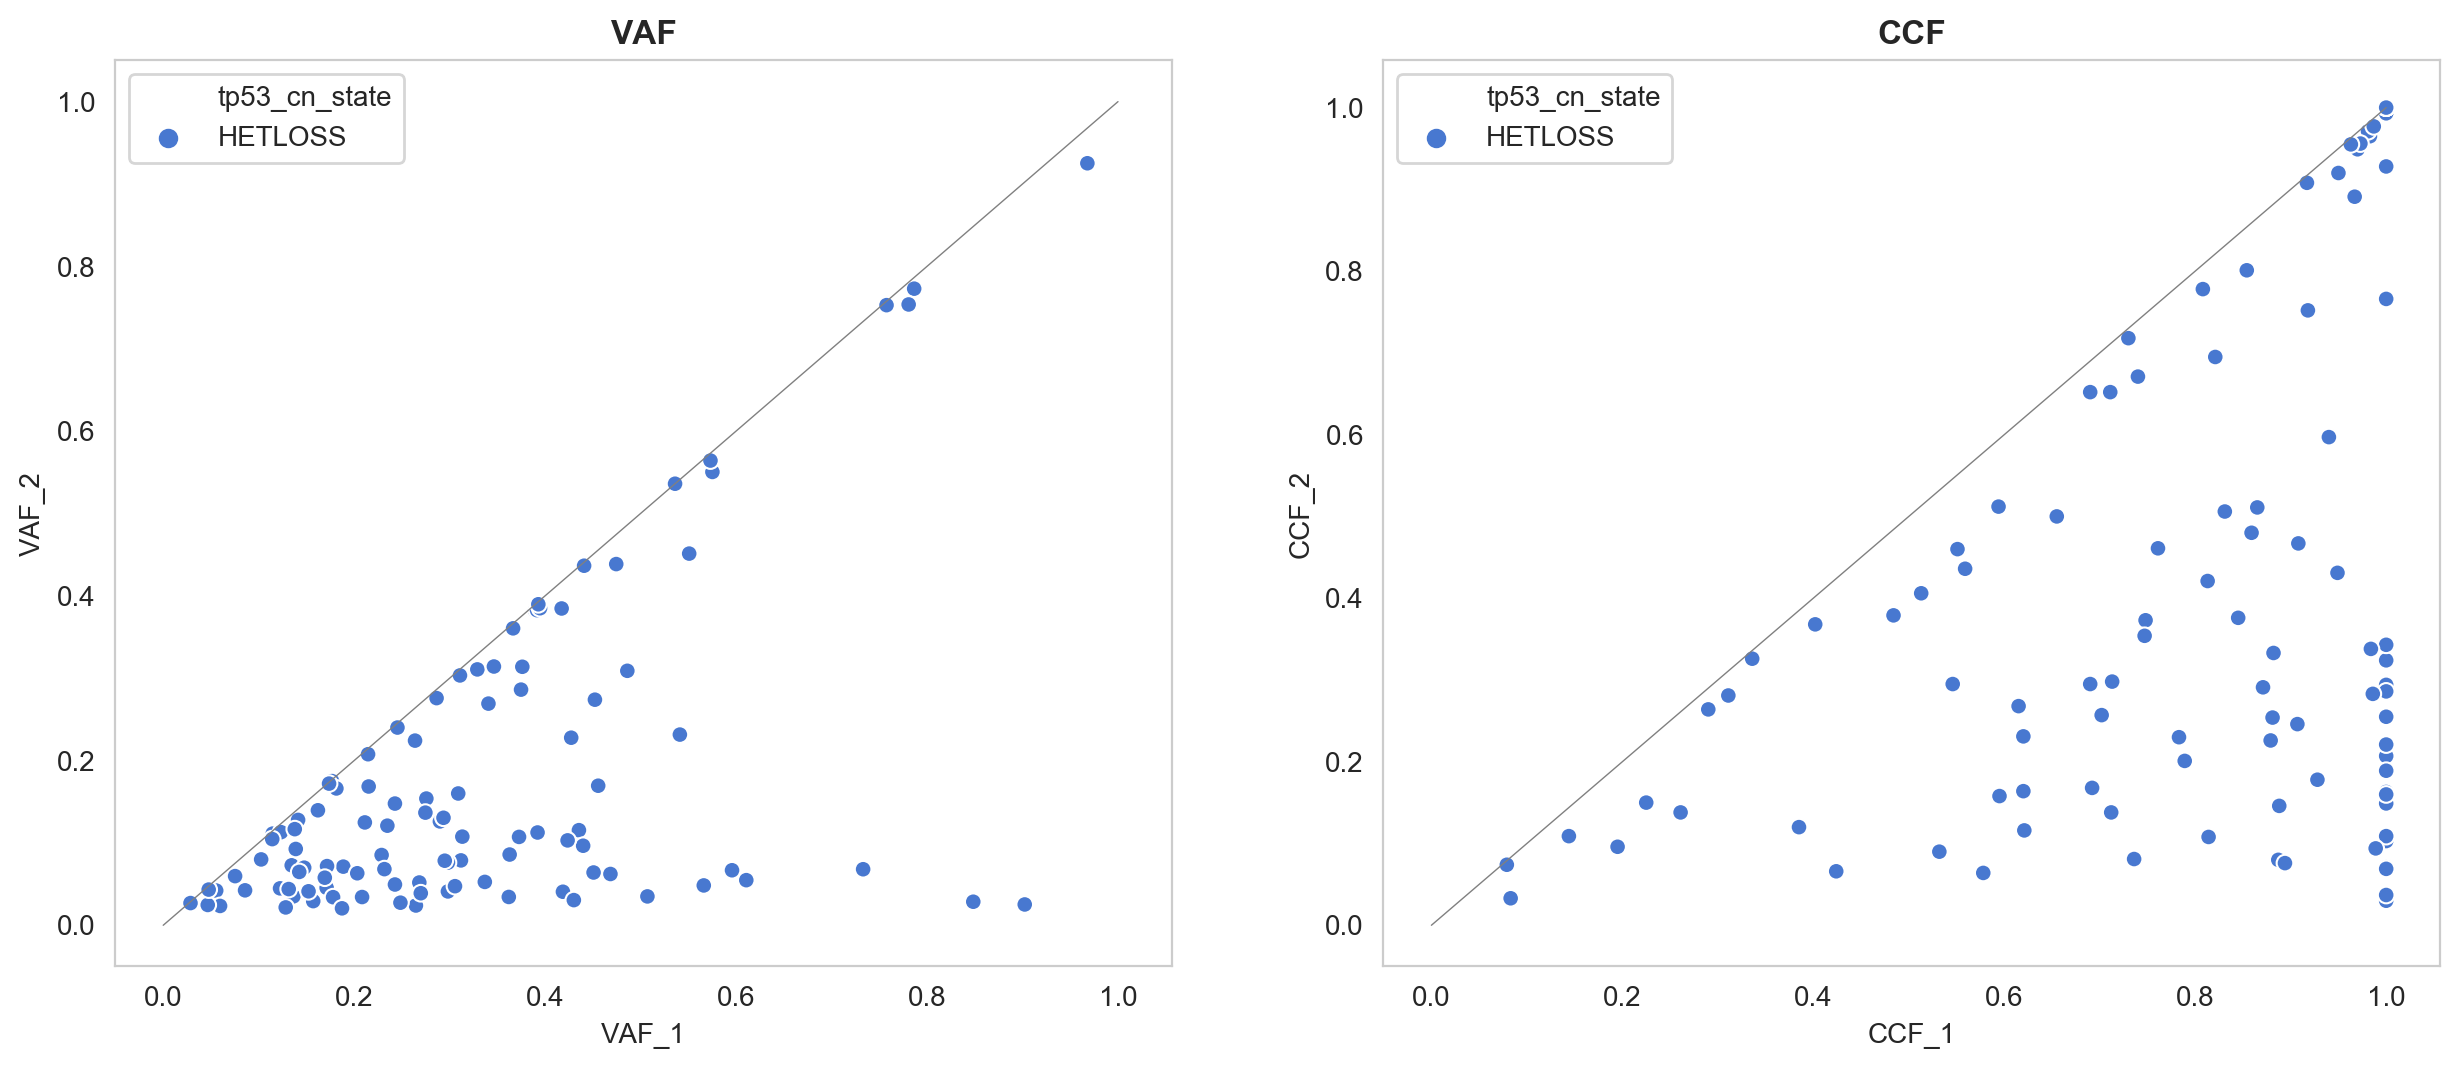

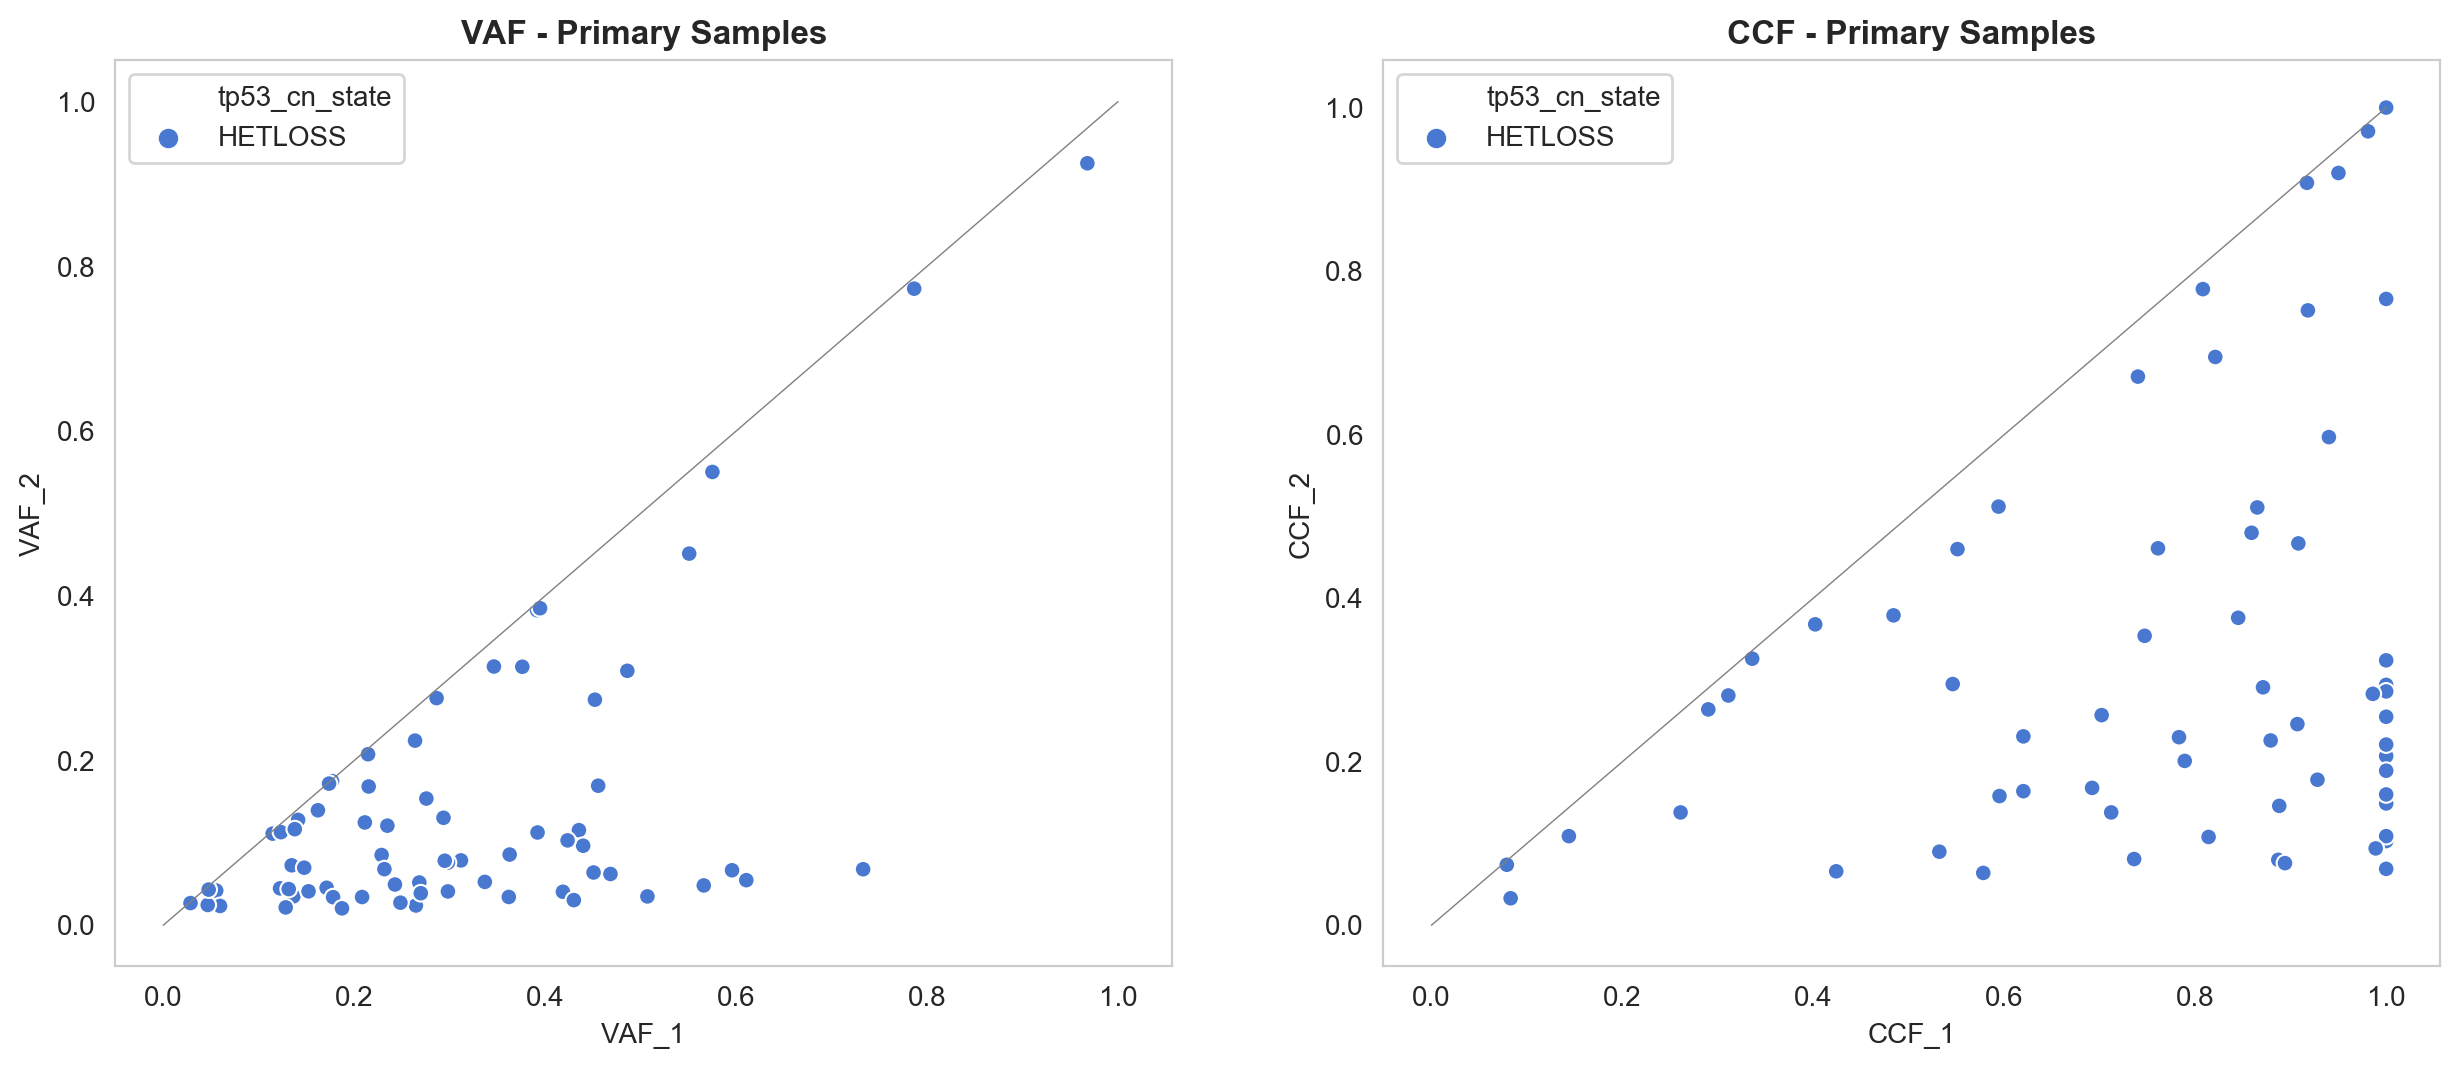

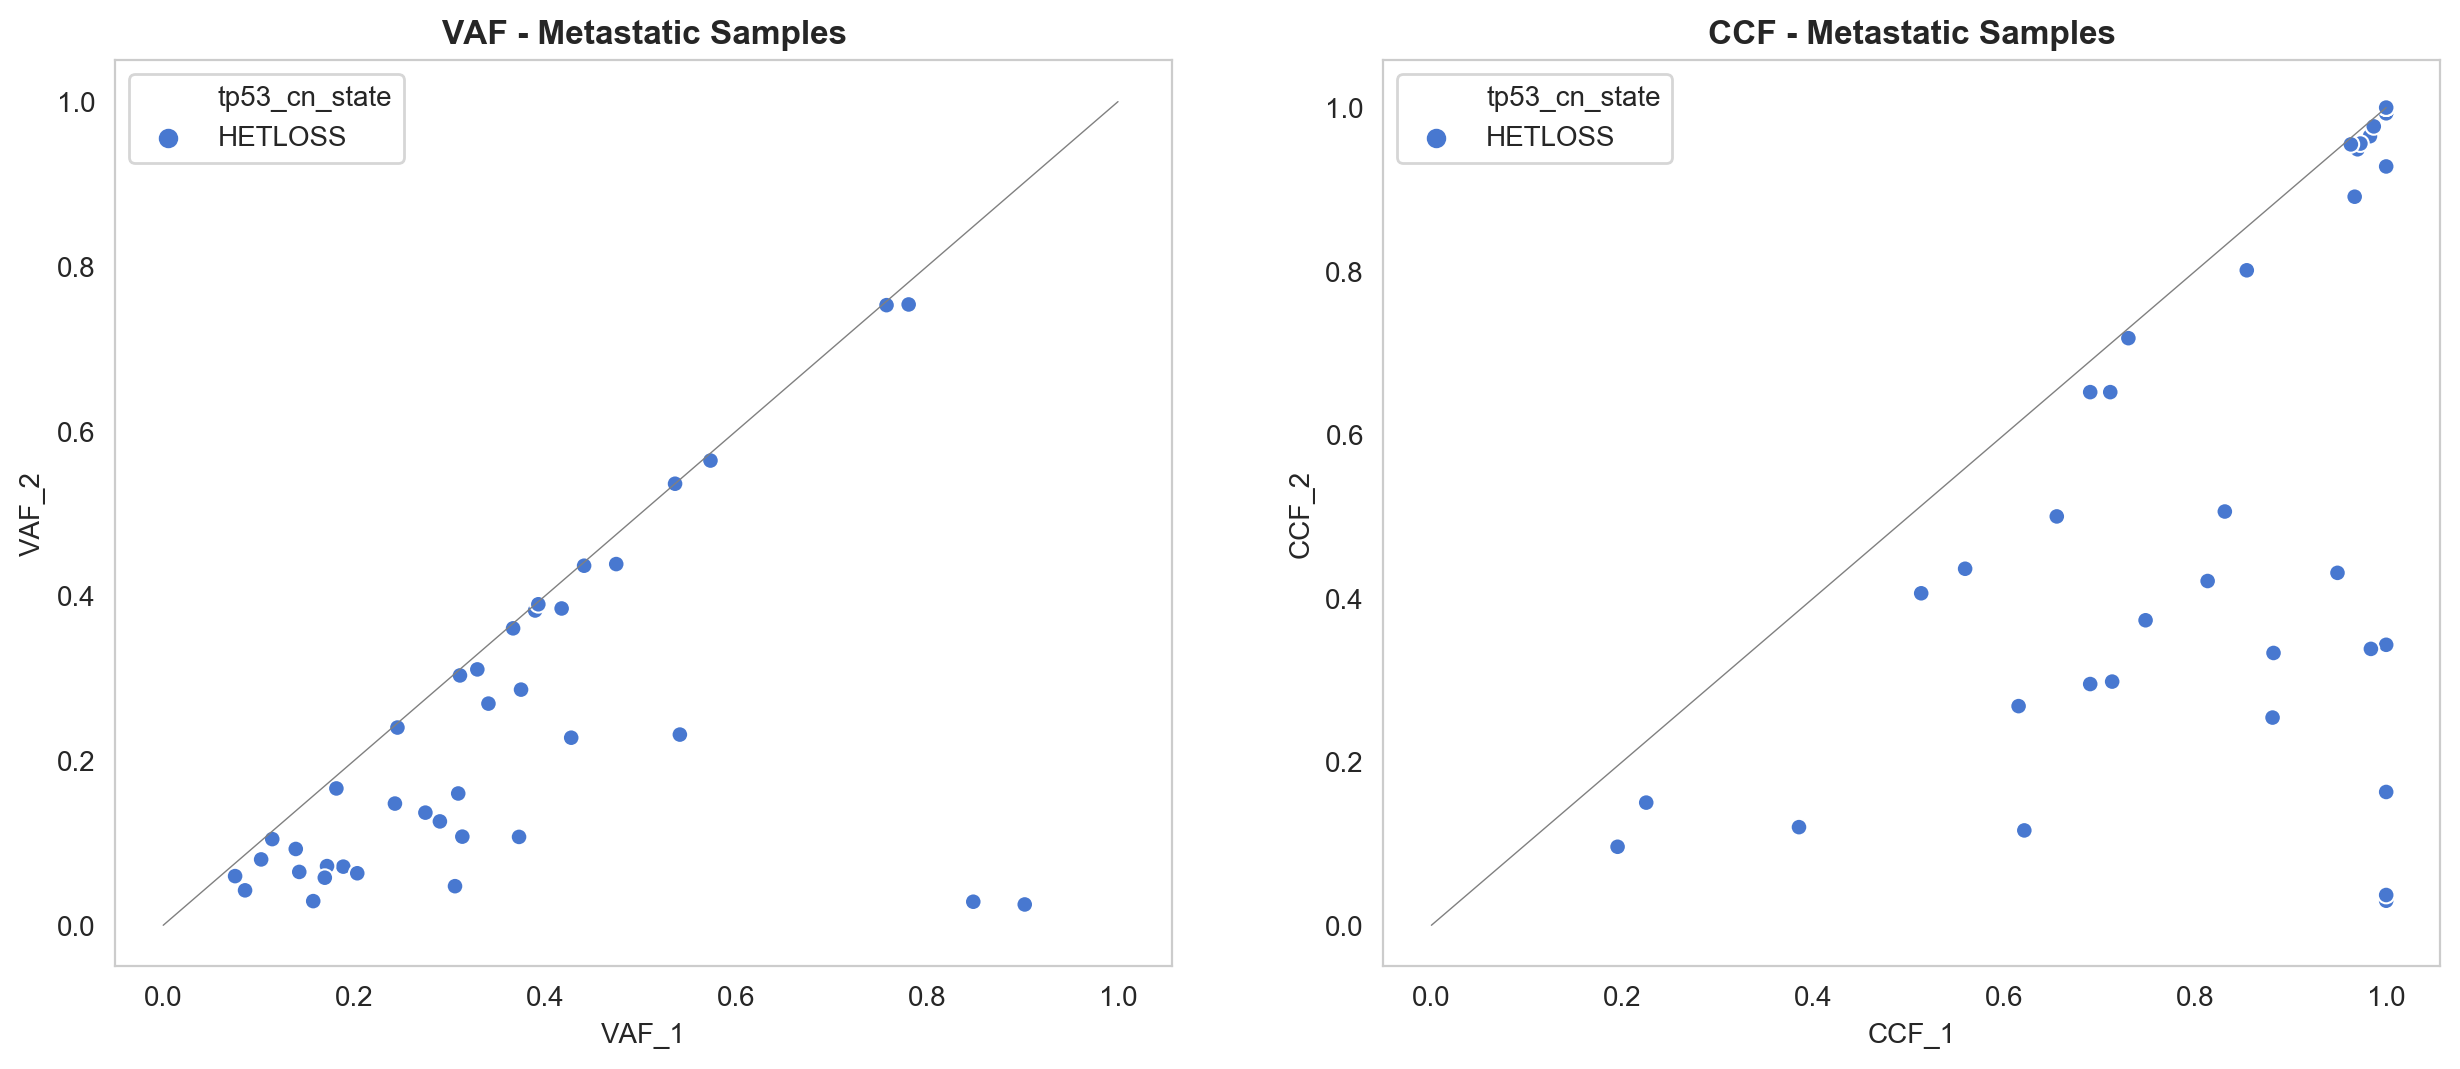

ValueError: There must be at least two hue levels to use `split`.'

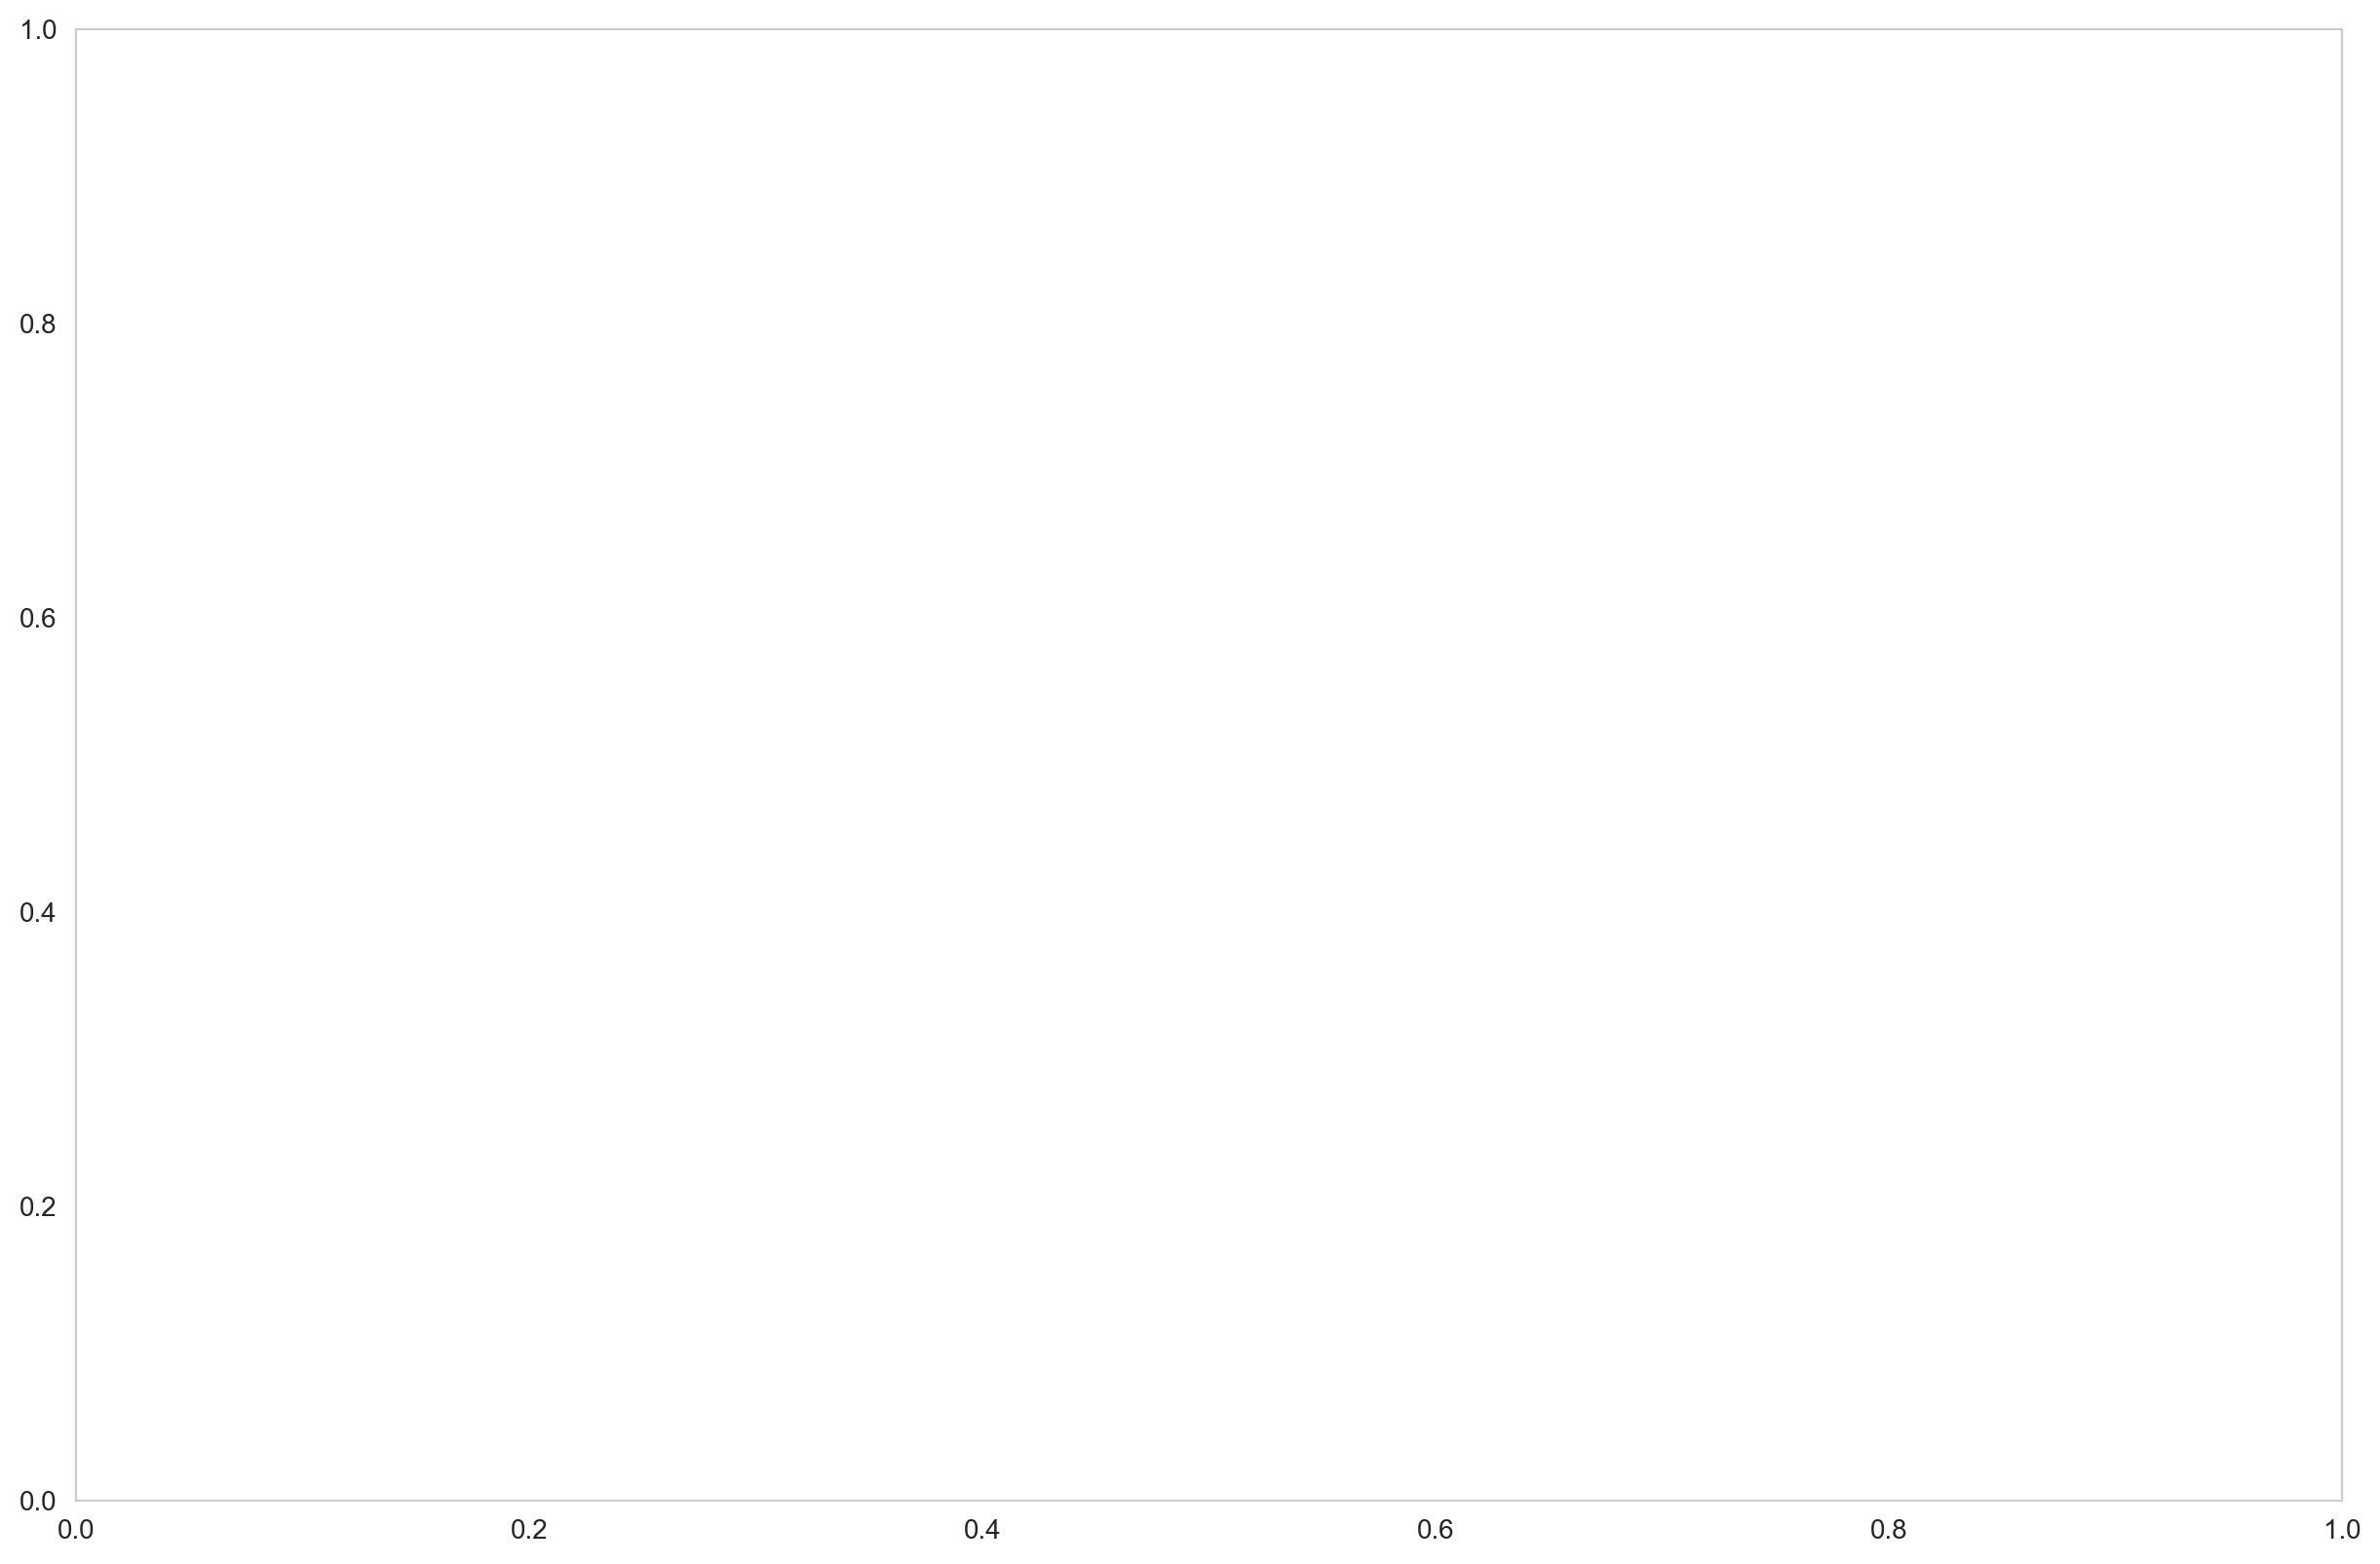

In [22]:
plot_summary(group=['>=1_LOSS'],group_name='>=1_LOSS',nb_muts_density=[1,2,3],nb_muts_scatter=[2,3], mut_cn_group=True, sample_type=True)

In [ ]:
plot_summary(group=['>=1_cnLOH'],group_name='>=1_cnLOH',nb_muts_density=[1,2,3], nb_muts_scatter=[2,3], mut_cn_group=True, sample_type=True)

In [ ]:
plot_summary(group=['1_WILD_TYPE'],group_name='1_WILD_TYPE',nb_muts_density=[1, 2],nb_muts_scatter=0, mut_cn_group=True, sample_type=True)

In [ ]:
plot_summary(group=['>1muts'],group_name='>1muts',nb_muts_density=[2,3,4,5],nb_muts_scatter=[2,3,4,5], mut_cn_group=True, sample_type=True)

In [ ]:
plot_summary(group=['HOMDEL'],group_name='HOMDEL',nb_muts_density=[1,2,4],nb_muts_scatter=[2,3,4,5], mut_cn_group=True, sample_type=True)

In [ ]:
master_demo = master[master['tp53_cn_state'] == 'CNLOH BEFORE & LOSS']
dx="tp53_tcn"; dy="tp53_exp_nb_1"; ort="h"; pal = "muted"; dhue = "tp53_cn_state"
f, ax = plt.subplots(figsize=(15, 10))

pt.RainCloud(x = dx, y = dy, data = master_demo, palette = pal,
                 width_viol = .6, ax = ax, orient = ort)

plt.title("CNLOH BEFORE & LOSS", weight='bold')
plt.ylabel('Total Copy Number')
plt.xlabel('Expected Number of TP53 mutant copies')